<a href="https://colab.research.google.com/github/aryanmangal769/stress_prediction_from_HRV/blob/main/extra/HRV_from_ecg_all_plots.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# link for hrv from ecg https://www.kaggle.com/stetelepta/exploring-heart-rate-variability-using-python
# https://blog.orikami.nl/exploring-heart-rate-variability-using-python-483a7037c64d


In [ ]:
#youtube
#https://www.youtube.com/c/TalhaIqbal91/playlists
#https://www.youtube.com/watch?v=fdu8PD9Kj_U

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd

In [ ]:
ls /content/drive/MyDrive/HRV/drive01.txt


/content/drive/MyDrive/HRV/drive01.txt


In [ ]:
!pip install opensignalsreader
!pip install pyhrv
!pip install biosppy

     |████████████████████████████████| 55 kB 3.1 MB/s 
     |████████████████████████████████| 3.2 MB 7.8 MB/s 
     |████████████████████████████████| 85 kB 4.1 MB/s 
     |████████████████████████████████| 228 kB 51.1 MB/s 
  Created wheel for biosppy: filename=biosppy-0.7.3-py2.py3-none-any.whl size=95429 sha256=4567c79f981dc785561d88f15b9f1e3dceaf0ea443d88edfdf8b7a877fca4a72
  Stored in directory: /root/.cache/pip/wheels/2f/4f/8f/28b2adc462d7e37245507324f4817ce1c64ef2464f099f4f0b
  Created wheel for spectrum: filename=spectrum-0.8.0-cp37-cp37m-linux_x86_64.whl size=234835 sha256=80c7b0d24acc5bff36f4d464846f9372c55f0f2218b314ccb8480ac1c45816f8
  Stored in directory: /root/.cache/pip/wheels/ac/a0/2b/aba9ac3cce046bc454a44d0db5b711b4e927a0dd33a93e9d98
Successfully built biosppy spectrum


In [ ]:
from pyhrv.hrv import hrv
from opensignalsreader import OpenSignalsReader
from biosppy.signals.ecg import ecg

In [ ]:
pip install pyhrv

In [ ]:
df= pd.read_excel("/content/drive/MyDrive/HRV/drive01.xlsx")
file = pd.DataFrame(df, index = None)
file

-0.03
0     -0.026
1     -0.016
2     -0.020
3     -0.395
4      0.007
...      ...
61493  0.075
61494  0.090
61495  0.067
61496  0.054
61497  0.049

[61498 rows x 1 columns]

In [ ]:
X=file.columns
X=X[2:]
#X=df[X]
X

Float64Index([], dtype='float64')

# **HRV !**

In [ ]:
ls /content/drive/MyDrive/HRV/Github_Dataset/ecg.csv

/content/drive/MyDrive/HRV/Github_Dataset/ecg.csv


In [ ]:
pip install wfdb


In [ ]:
# system imports
import os
import sys

# data science
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import seaborn as sns

# signal processing
from scipy import signal
from scipy.ndimage import label
from scipy.stats import zscore
from scipy.interpolate import interp1d
from scipy.integrate import trapz

# physionet data
import wfdb
from wfdb import processing

### Global settings

In [ ]:
# path settings
project_path = os.path.join(os.getcwd(), os.pardir)
data_path = os.path.join(project_path, '/content/drive/MyDrive/HRV/Github_Dataset/')
output_path = os.path.join(project_path, '/content/drive/MyDrive/HRV/Github_Dataset/output')

# style settings
sns.set(style='whitegrid', rc={'axes.facecolor': '#EFF2F7'})

# sample frequency for Bobbi sensor
settings = {}
settings['fs'] = 500

### Helper functions

In [ ]:
def get_plot_ranges(start=10, end=20, n=5):
    '''
    Make an iterator that divides into n or n+1 ranges. 
    - if end-start is divisible by steps, return n ranges
    - if end-start is not divisible by steps, return n+1 ranges, where the last range is smaller and ends at n
    
    # Example:
    >> list(get_plot_ranges())
    >> [(0.0, 3.0), (3.0, 6.0), (6.0, 9.0)]

    '''
    distance = end - start
    for i in np.arange(start, end, np.floor(distance/n)):
        yield (int(i), int(np.minimum(end, np.floor(distance/n) + i)))

In [ ]:
def group_peaks(p, threshold=5):
    '''
    The peak detection algorithm finds multiple peaks for each QRS complex. 
    Here we group collections of peaks that are very near (within threshold) and we take the median index 
    '''
    # initialize output
    output = np.empty(0)

    # label groups of sample that belong to the same peak
    peak_groups, num_groups = label(np.diff(p) < threshold)

    # iterate through groups and take the mean as peak index
    for i in np.unique(peak_groups)[1:]:
        peak_group = p[np.where(peak_groups == i)]
        output = np.append(output, np.median(peak_group))
    return output

In [ ]:
def detect_peaks(ecg_signal, threshold=0.3, qrs_filter=None):
    '''
    Peak detection algorithm using cross corrrelation and threshold 
    '''
    if qrs_filter is None:
        # create default qrs filter
        t = np.linspace(1.5 * np.pi, 3.5 * np.pi, 15)
        qrs_filter = np.sin(t)
    
    # normalize data
    ecg_signal = (ecg_signal - ecg_signal.mean()) / ecg_signal.std()

    # calculate cross correlation
    similarity = np.correlate(ecg_signal, qrs_filter, mode="same")
    similarity = similarity / np.max(similarity)

    # return peaks (values in ms) using threshold
    return ecg_signal[similarity > threshold].index, similarity

## Load data

In [ ]:
# data recorded with the Bobbi sensor
df = pd.read_csv(os.path.join(data_path, "ecg.csv"), sep=";", index_col="ms")

## Explore data

Text(0, 0.5, 'Amplitude (arbitrary unit)')

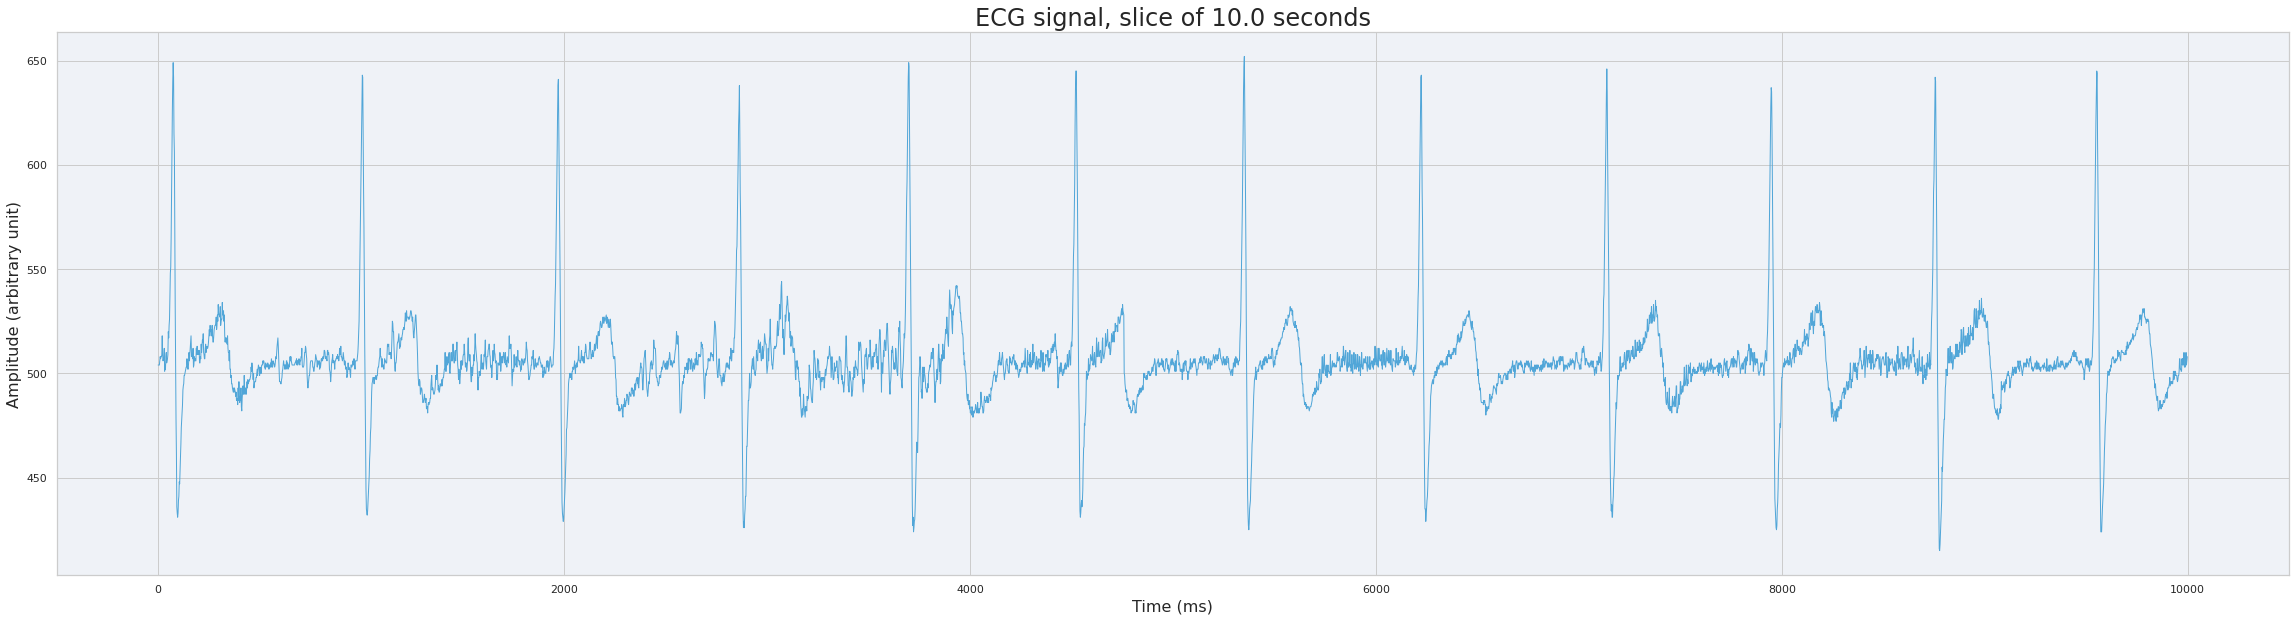

In [ ]:
plt.figure(figsize=(40, 10))
start = 0
stop = 5000
duration = (stop-start) / settings['fs']
plt.title("ECG signal, slice of %.1f seconds" % duration, fontsize=24)
plt.plot(df[start:stop].index, df[start:stop].heartrate, color="#51A6D8", linewidth=1)
plt.xlabel("Time (ms)", fontsize=16)
plt.ylabel("Amplitude (arbitrary unit)", fontsize=16)

## Find RR-intervals

### Peak detection using template matching & threshold

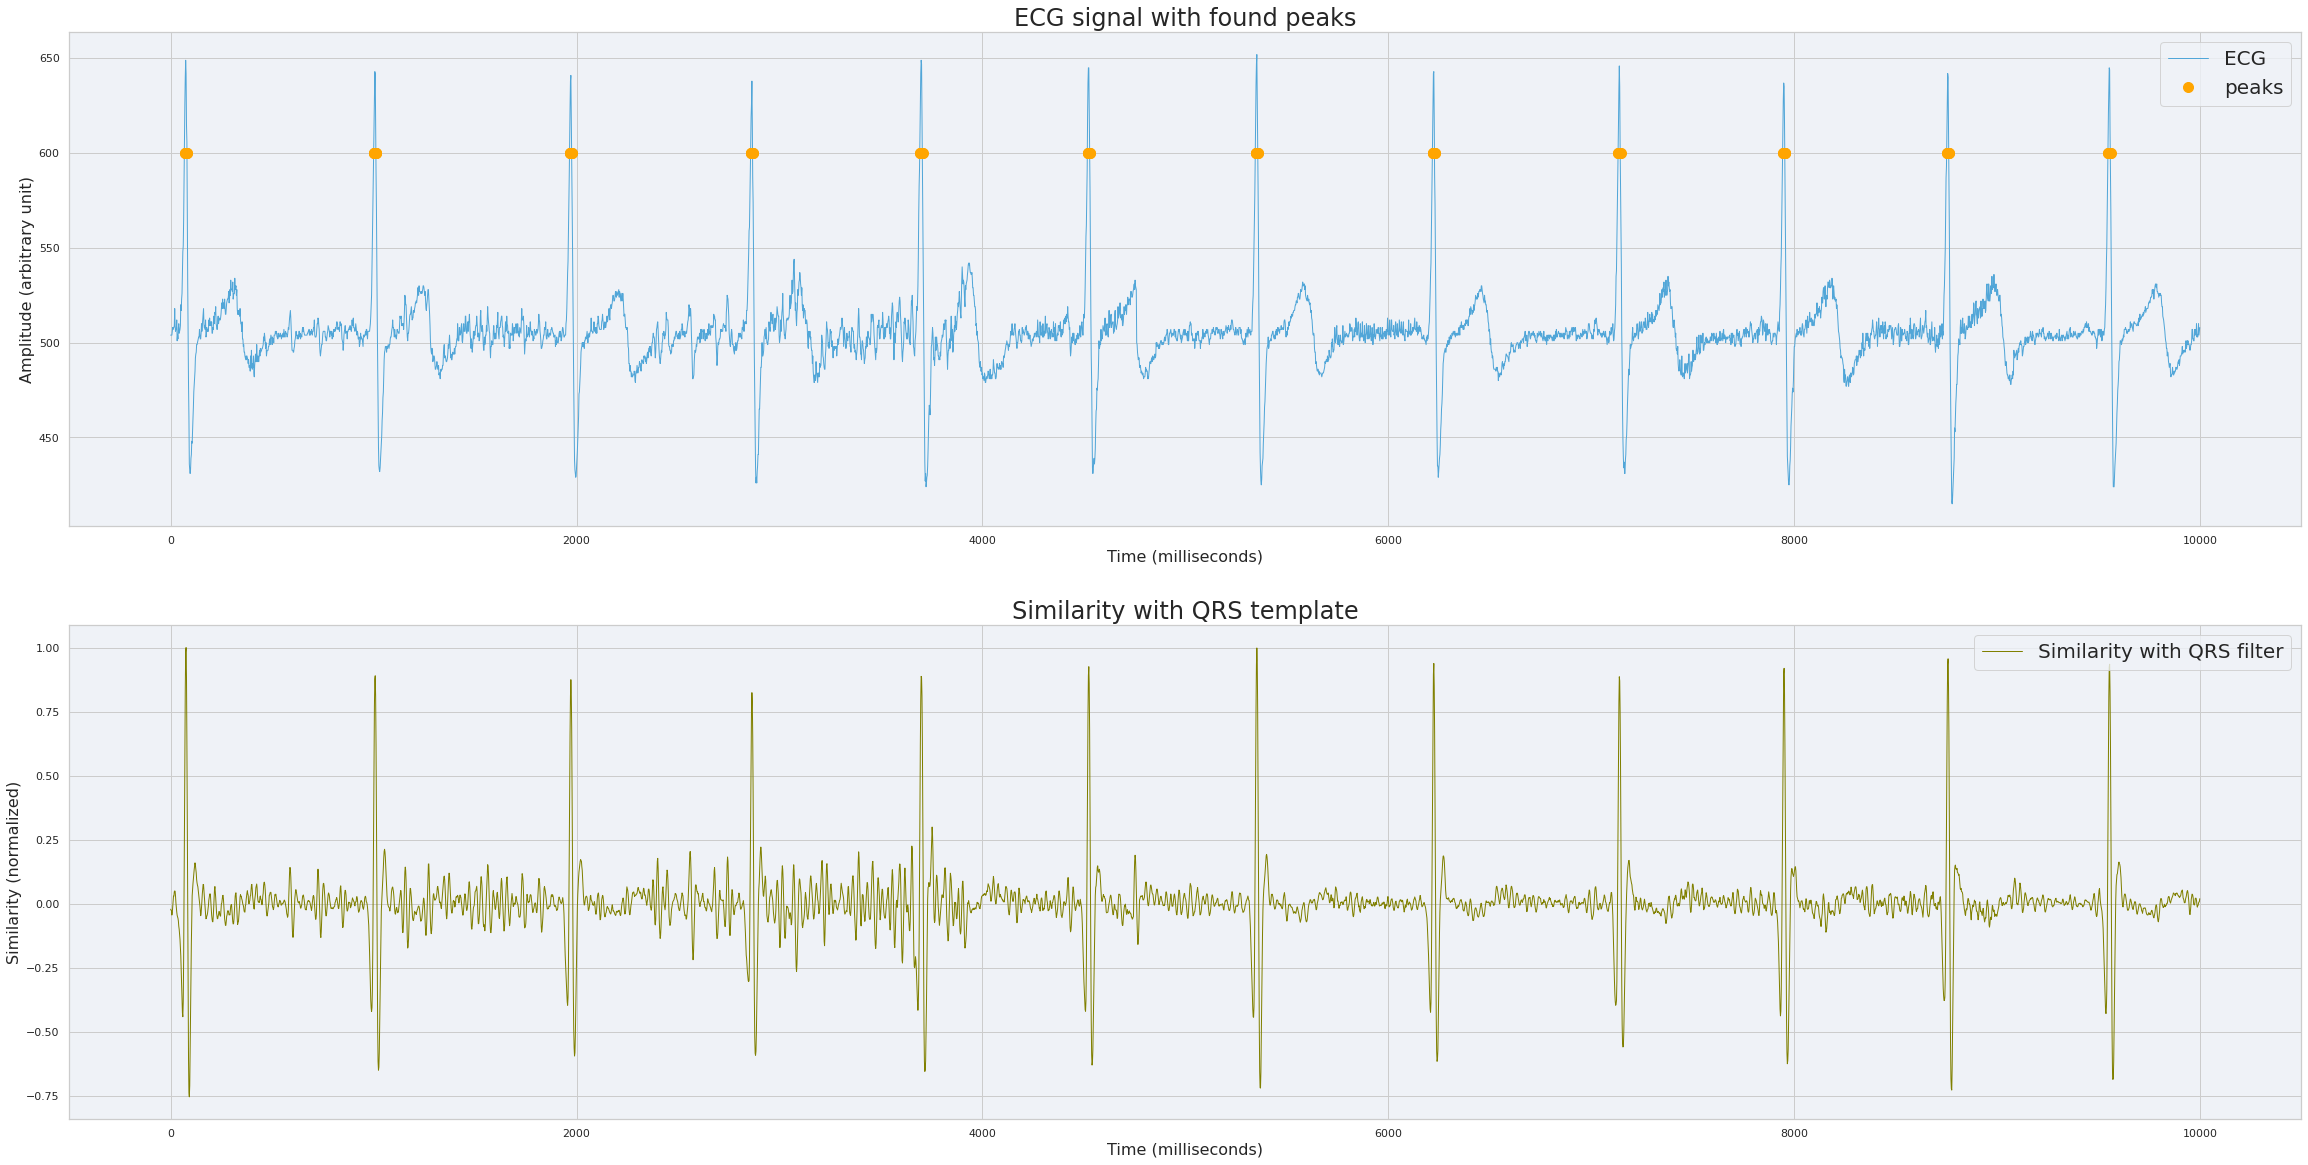

In [ ]:
sampfrom = 0
sampto = 10000
nr_plots = 1

for start, stop in get_plot_ranges(sampfrom, sampto, nr_plots):
    # get slice data of ECG data
    cond_slice = (df.index >= start) & (df.index < stop) 
    ecg_slice = df.heartrate[cond_slice]

    # detect peaks
    peaks, similarity = detect_peaks(ecg_slice, threshold=0.3)
    
    # plot similarity
    plt.figure(figsize=(40, 20))

    plt.subplot(211)
    plt.title("ECG signal with found peaks", fontsize=24)
    plt.plot(ecg_slice.index, ecg_slice, label="ECG", color="#51A6D8", linewidth=1)
    plt.plot(peaks, np.repeat(600, peaks.shape[0]), markersize=10, label="peaks", color="orange", marker="o", linestyle="None")
    plt.legend(loc="upper right", fontsize=20)
    plt.xlabel("Time (milliseconds)", fontsize=16)
    plt.ylabel("Amplitude (arbitrary unit)", fontsize=16)
    
    plt.subplot(212)
    plt.title('Similarity with QRS template', fontsize=24)
    plt.plot(ecg_slice.index, similarity, label="Similarity with QRS filter", color="olive", linewidth=1)
    plt.legend(loc="upper right", fontsize=20)
    plt.xlabel("Time (milliseconds)", fontsize=16)
    plt.ylabel("Similarity (normalized)", fontsize=16)
    
    plt.savefig(os.path.join(output_path, "peaks-%s-%s.png" % (start, stop)))

### Group similar peaks

Int64Index([    70,     72,     74,     76,     78,     80,   1002,   1004,
              1006,   1008,
            ...
            299148, 299150, 299152, 299154, 299156, 299986, 299988, 299990,
            299992, 299994],
           dtype='int64', name='ms', length=2161)


(0.0, 200.0)

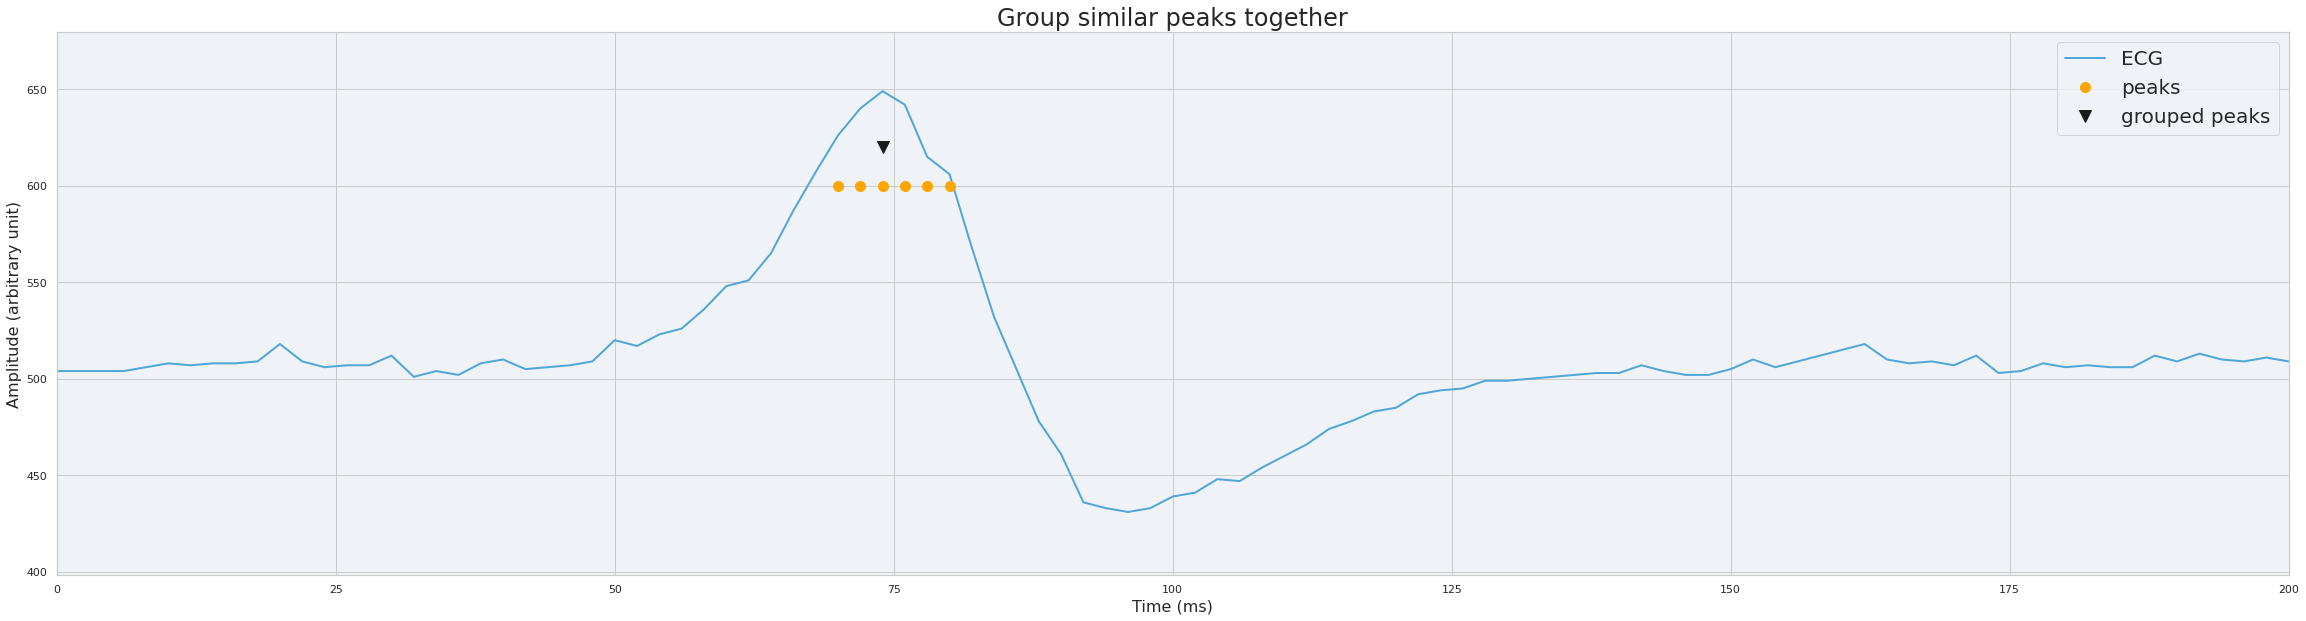

In [ ]:
# detect peaks
peaks, similarity = detect_peaks(df.heartrate, threshold=0.3)
print(peaks)
# group peaks
grouped_peaks = group_peaks(peaks)

# plot peaks
plt.figure(figsize=(40, 10))
plt.title("Group similar peaks together", fontsize=24)
plt.plot(df.index, df.heartrate, label="ECG", color="#51A6D8", linewidth=2)
plt.plot(peaks, np.repeat(600, peaks.shape[0]), markersize=10, label="peaks", color="orange", marker="o", linestyle="None")
plt.plot(grouped_peaks, np.repeat(620, grouped_peaks.shape[0]), markersize=12, label="grouped peaks", color="k", marker="v", linestyle="None")
plt.legend(loc="upper right", fontsize=20)
plt.xlabel("Time (ms)", fontsize=16)
plt.ylabel("Amplitude (arbitrary unit)", fontsize=16)
plt.gca().set_xlim(0, 200)


### RR intervals: difference between successive peaks

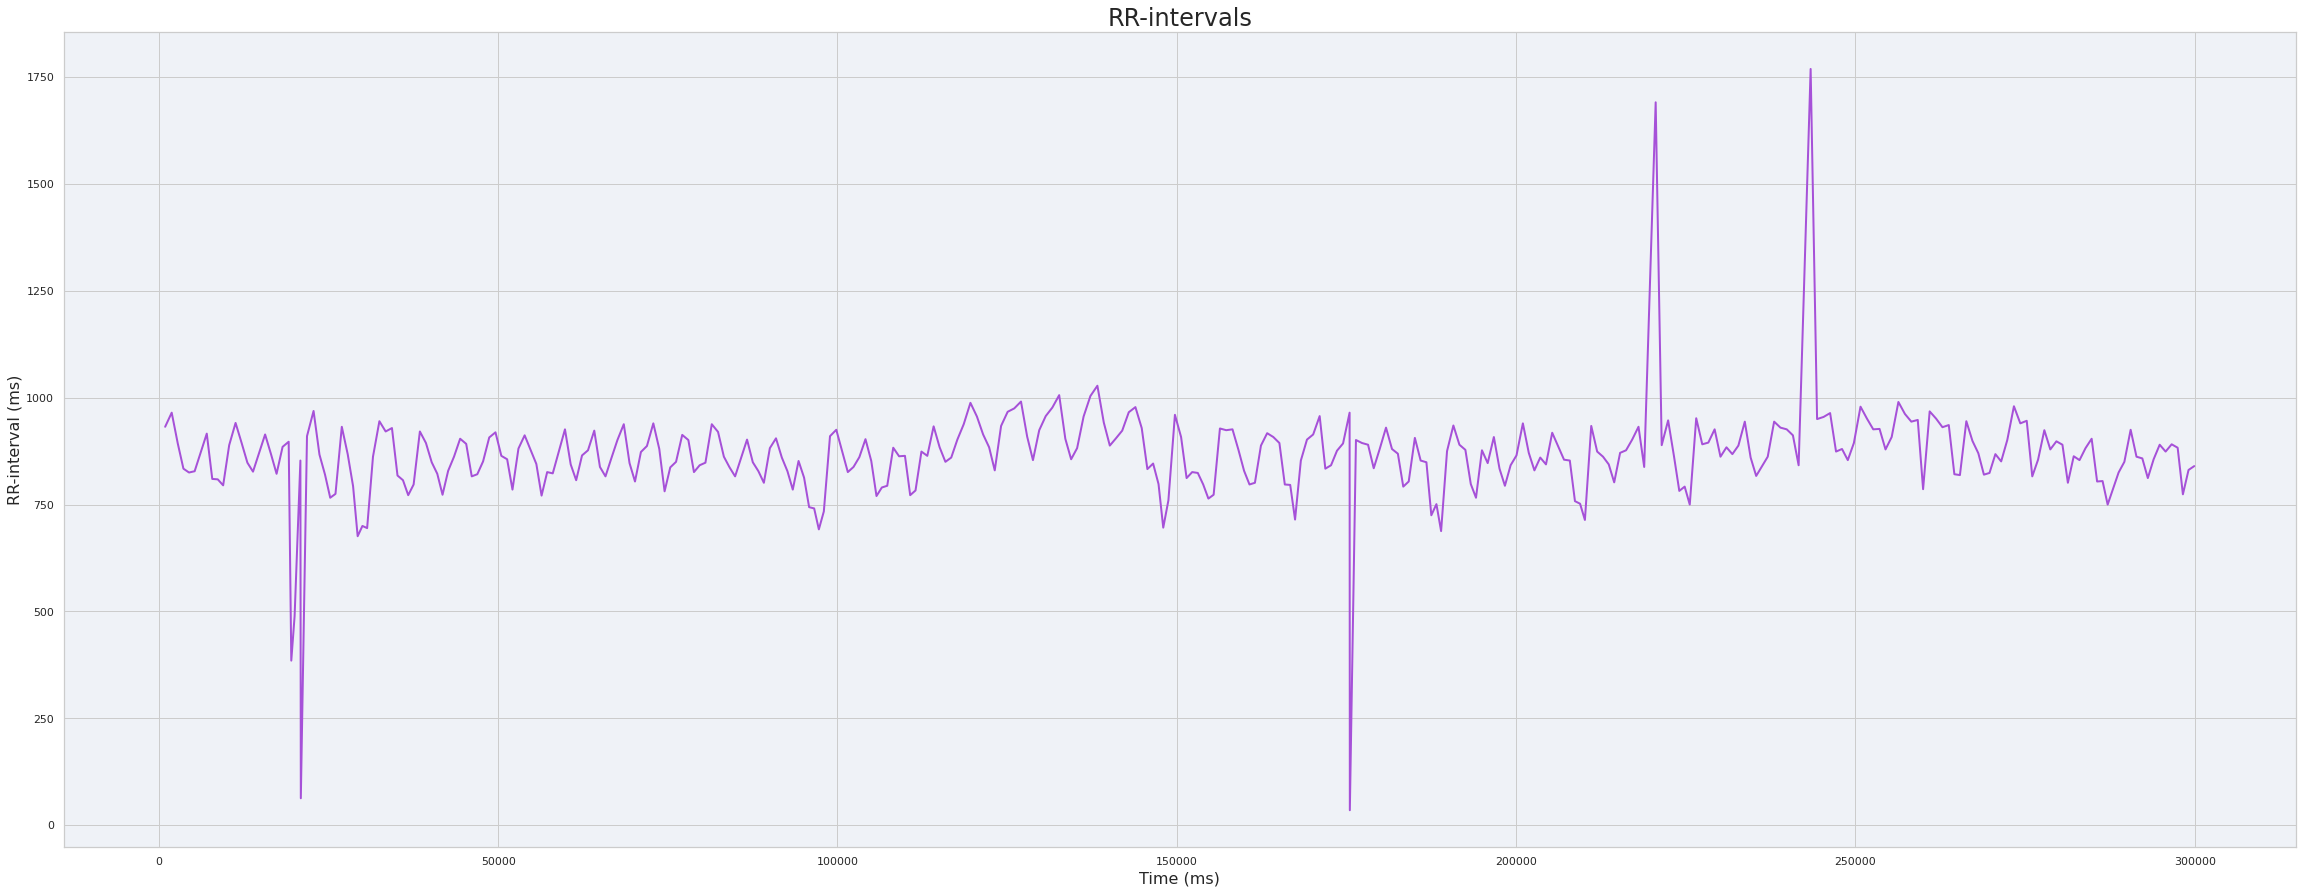

In [ ]:
# detect peaks
peaks, similarity = detect_peaks(df.heartrate, threshold=0.3)

# group peaks so we get a single peak per beat (hopefully)
grouped_peaks = group_peaks(peaks)

# RR-intervals are the differences between successive peaks
rr = np.diff(grouped_peaks)

# plot RR-intervals
plt.figure(figsize=(40, 15))
plt.title("RR-intervals", fontsize=24)
plt.xlabel("Time (ms)", fontsize=16)
plt.ylabel("RR-interval (ms)", fontsize=16)

plt.plot(np.cumsum(rr), rr, label="RR-interval", color="#A651D8", linewidth=2)

### Artifact removal

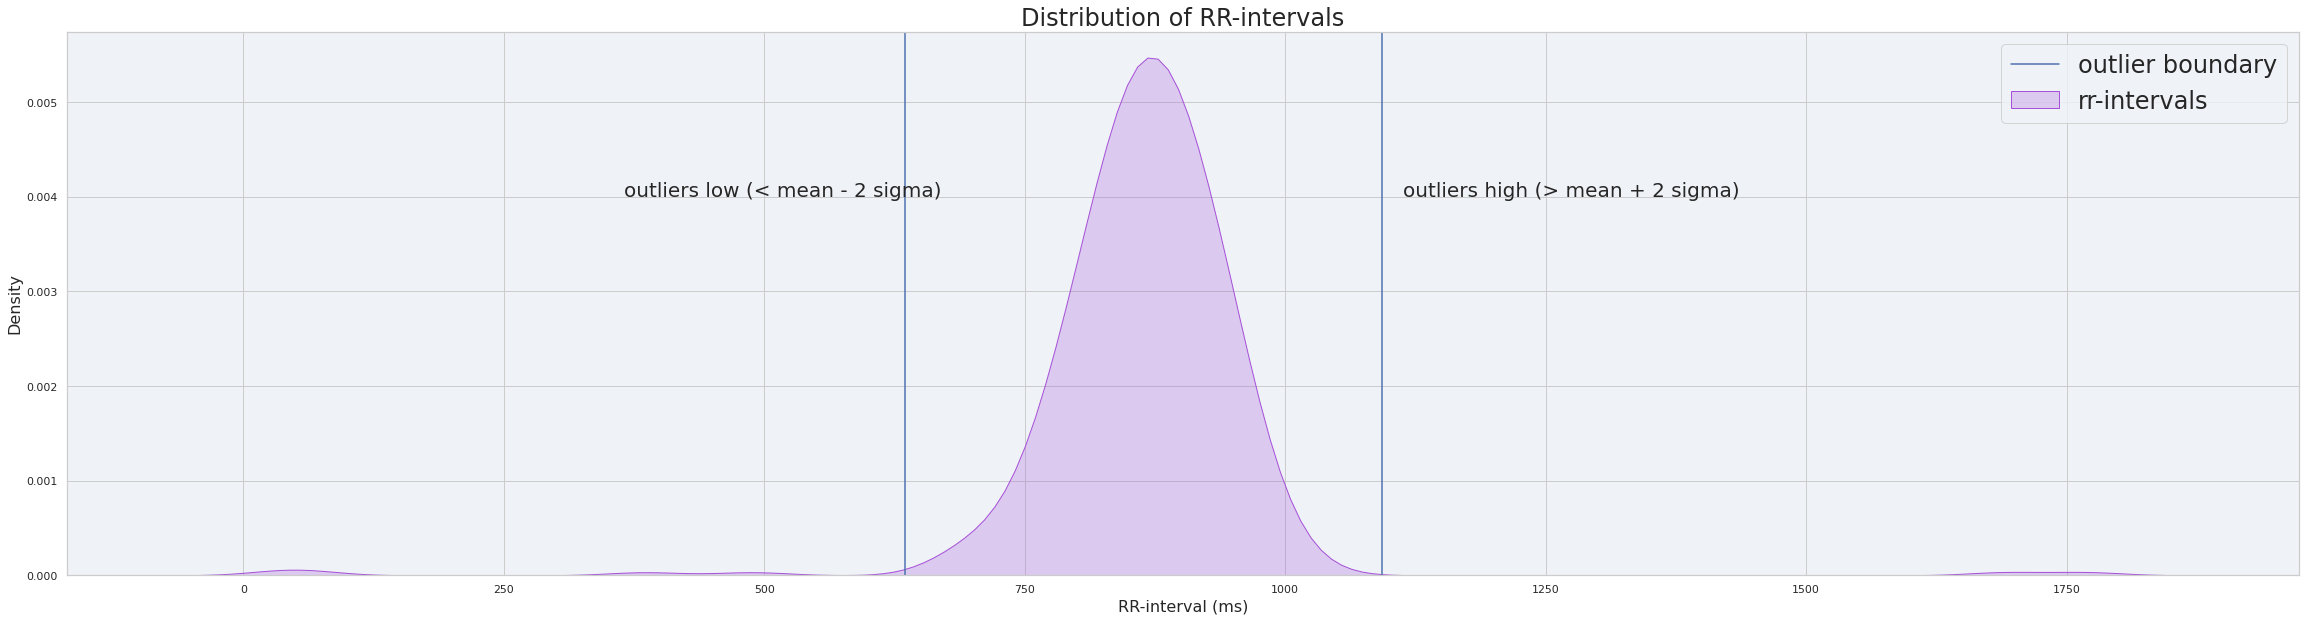

In [ ]:
plt.figure(figsize=(40, 10))
plt.title("Distribution of RR-intervals", fontsize=24)
sns.kdeplot(rr, label="rr-intervals", color="#A651D8", shade=True)

outlier_low = np.mean(rr)-2 * np.std(rr)
outlier_high = np.mean(rr)+2 * np.std(rr)

plt.axvline(x=outlier_low)
plt.axvline(x=outlier_high, label="outlier boundary")
plt.text(outlier_low - 270, 0.004, "outliers low (< mean - 2 sigma)", fontsize=20)
plt.text(outlier_high + 20, 0.004, "outliers high (> mean + 2 sigma)", fontsize=20)

plt.xlabel("RR-interval (ms)", fontsize=16)
plt.ylabel("Density", fontsize=16)

plt.legend(fontsize=24)

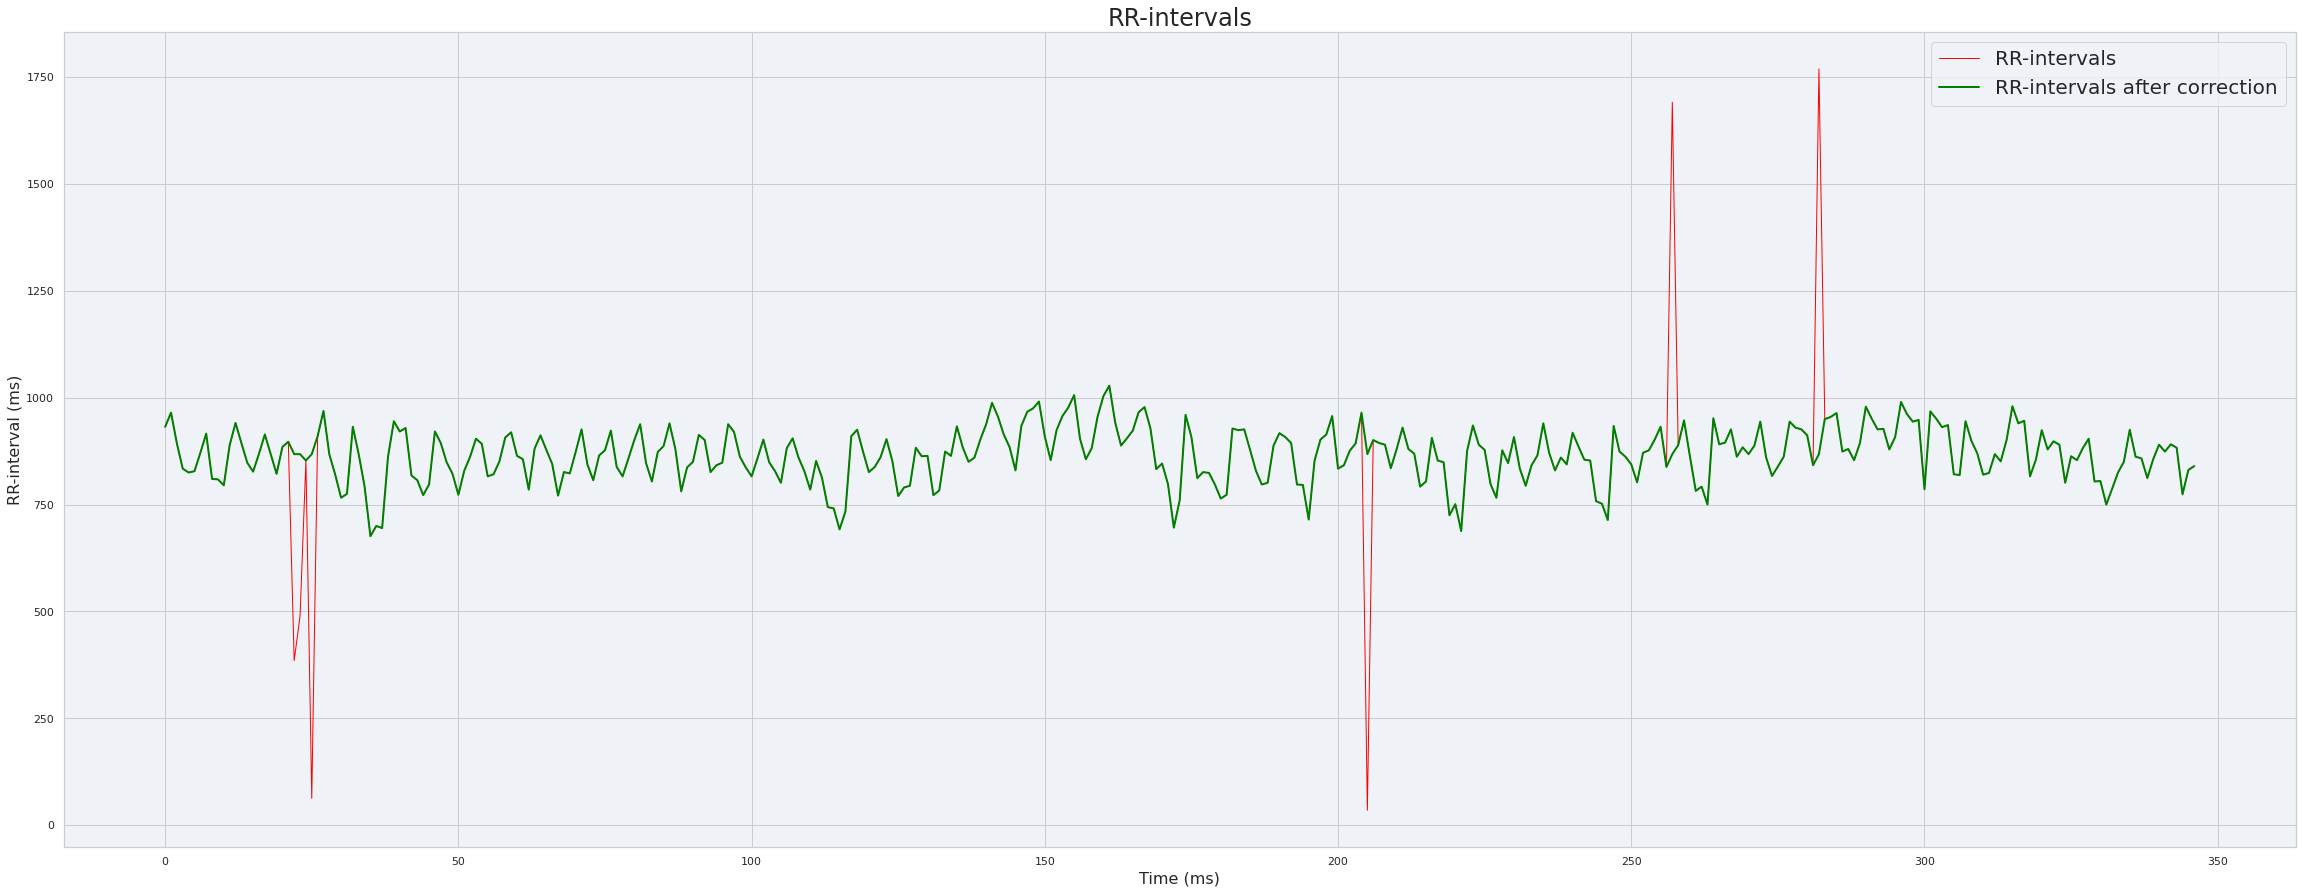

In [ ]:
plt.figure(figsize=(40, 15))

rr_corrected = rr.copy()
rr_corrected[np.abs(zscore(rr)) > 2] = np.median(rr)

plt.title("RR-intervals", fontsize=24)
plt.xlabel("Time (ms)", fontsize=16)
plt.ylabel("RR-interval (ms)", fontsize=16)

plt.plot(rr, color="red", linewidth=1, label="RR-intervals")
plt.plot(rr_corrected, color="green", linewidth=2, label="RR-intervals after correction")
plt.legend(fontsize=20)

### Plot ECG vs RR intervals

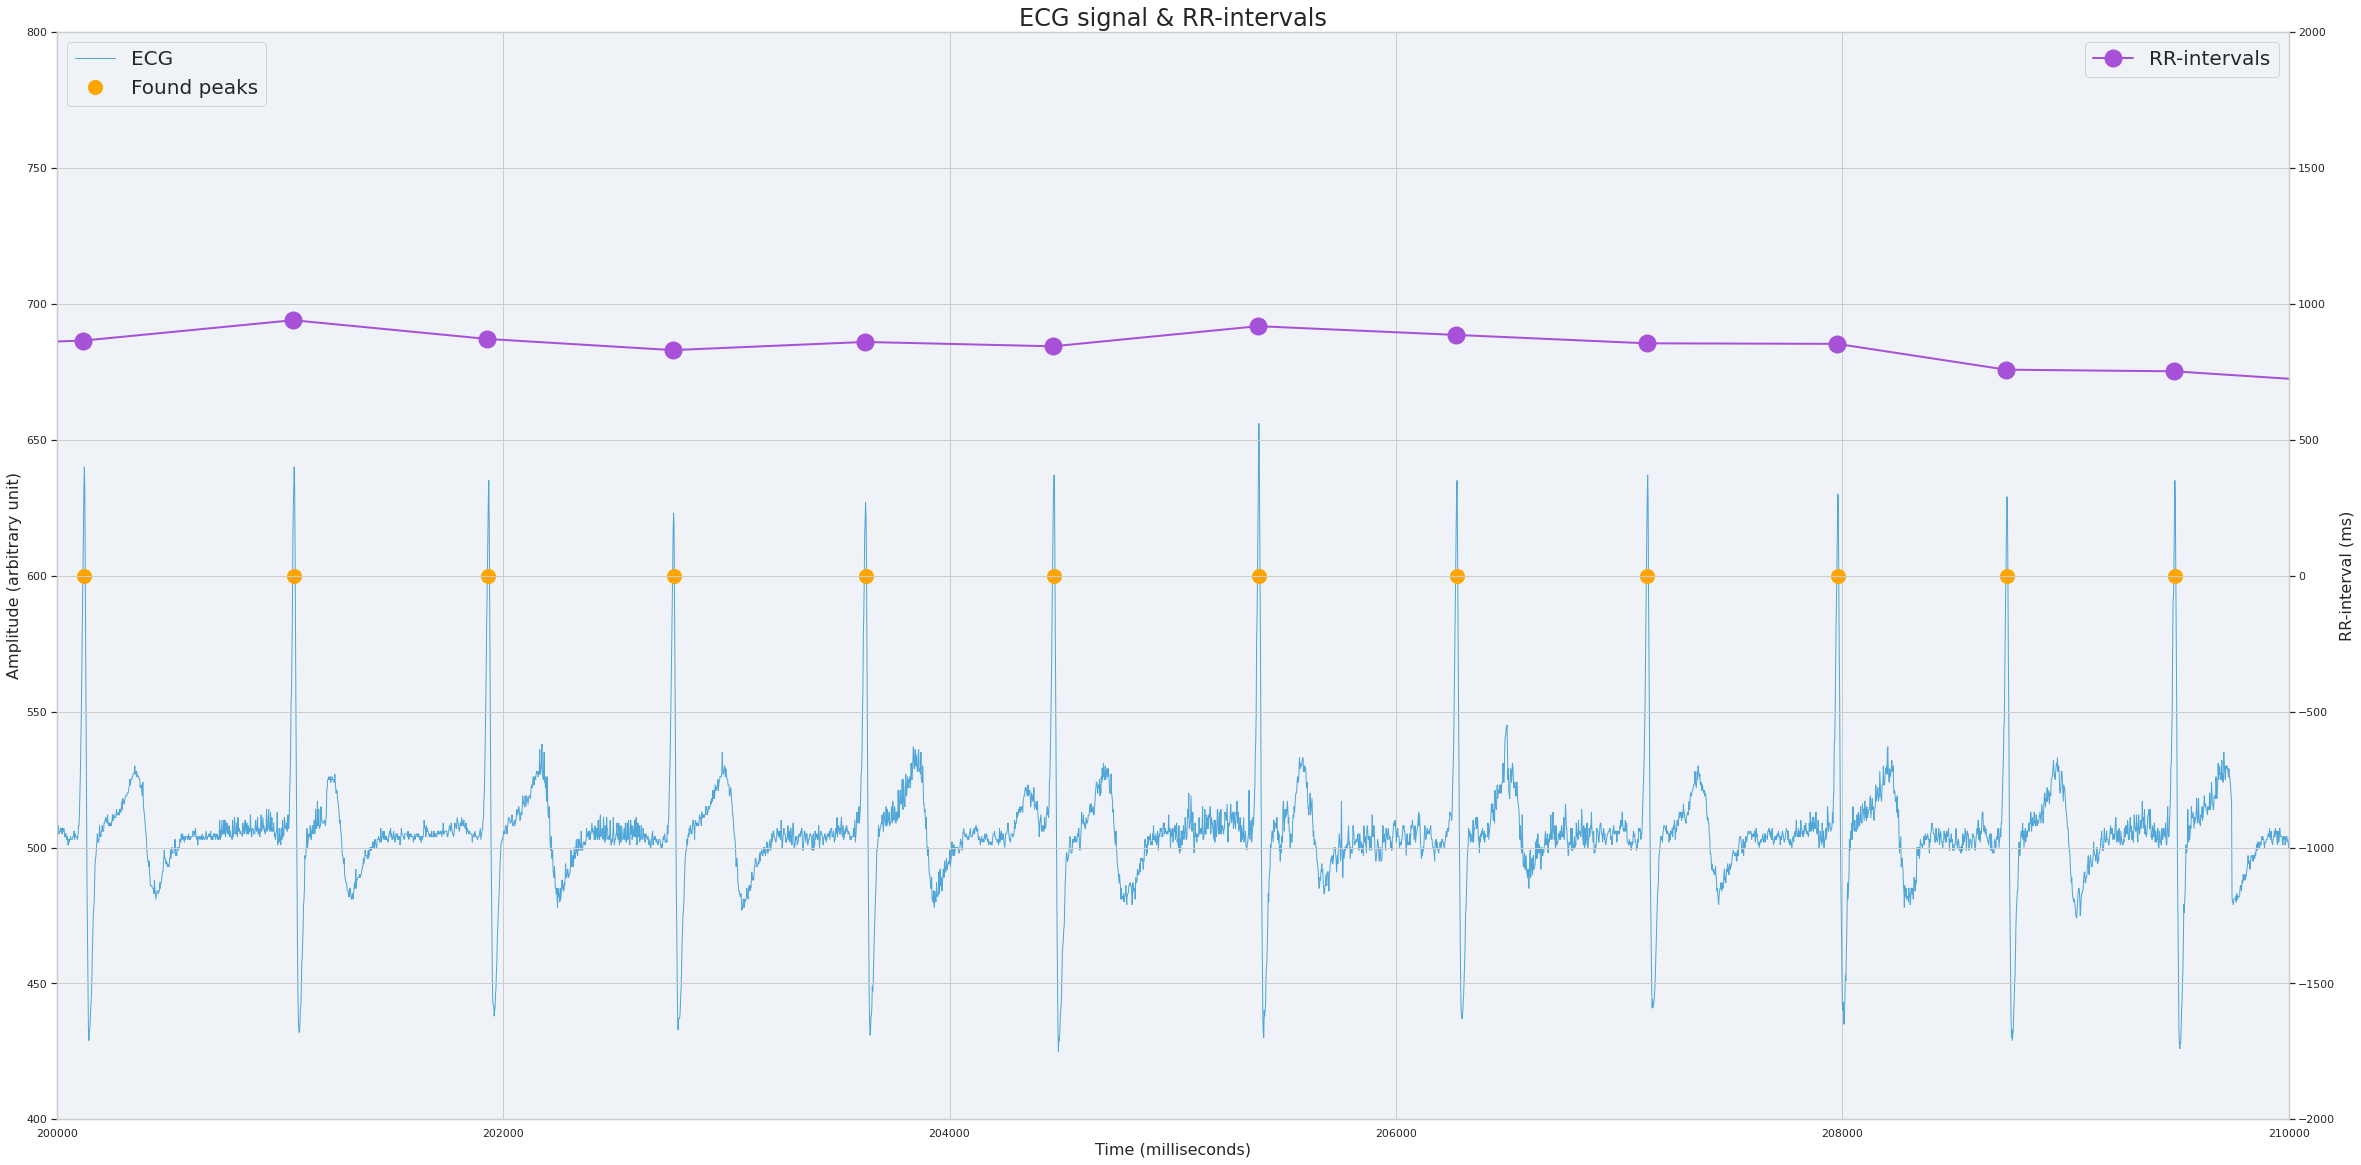

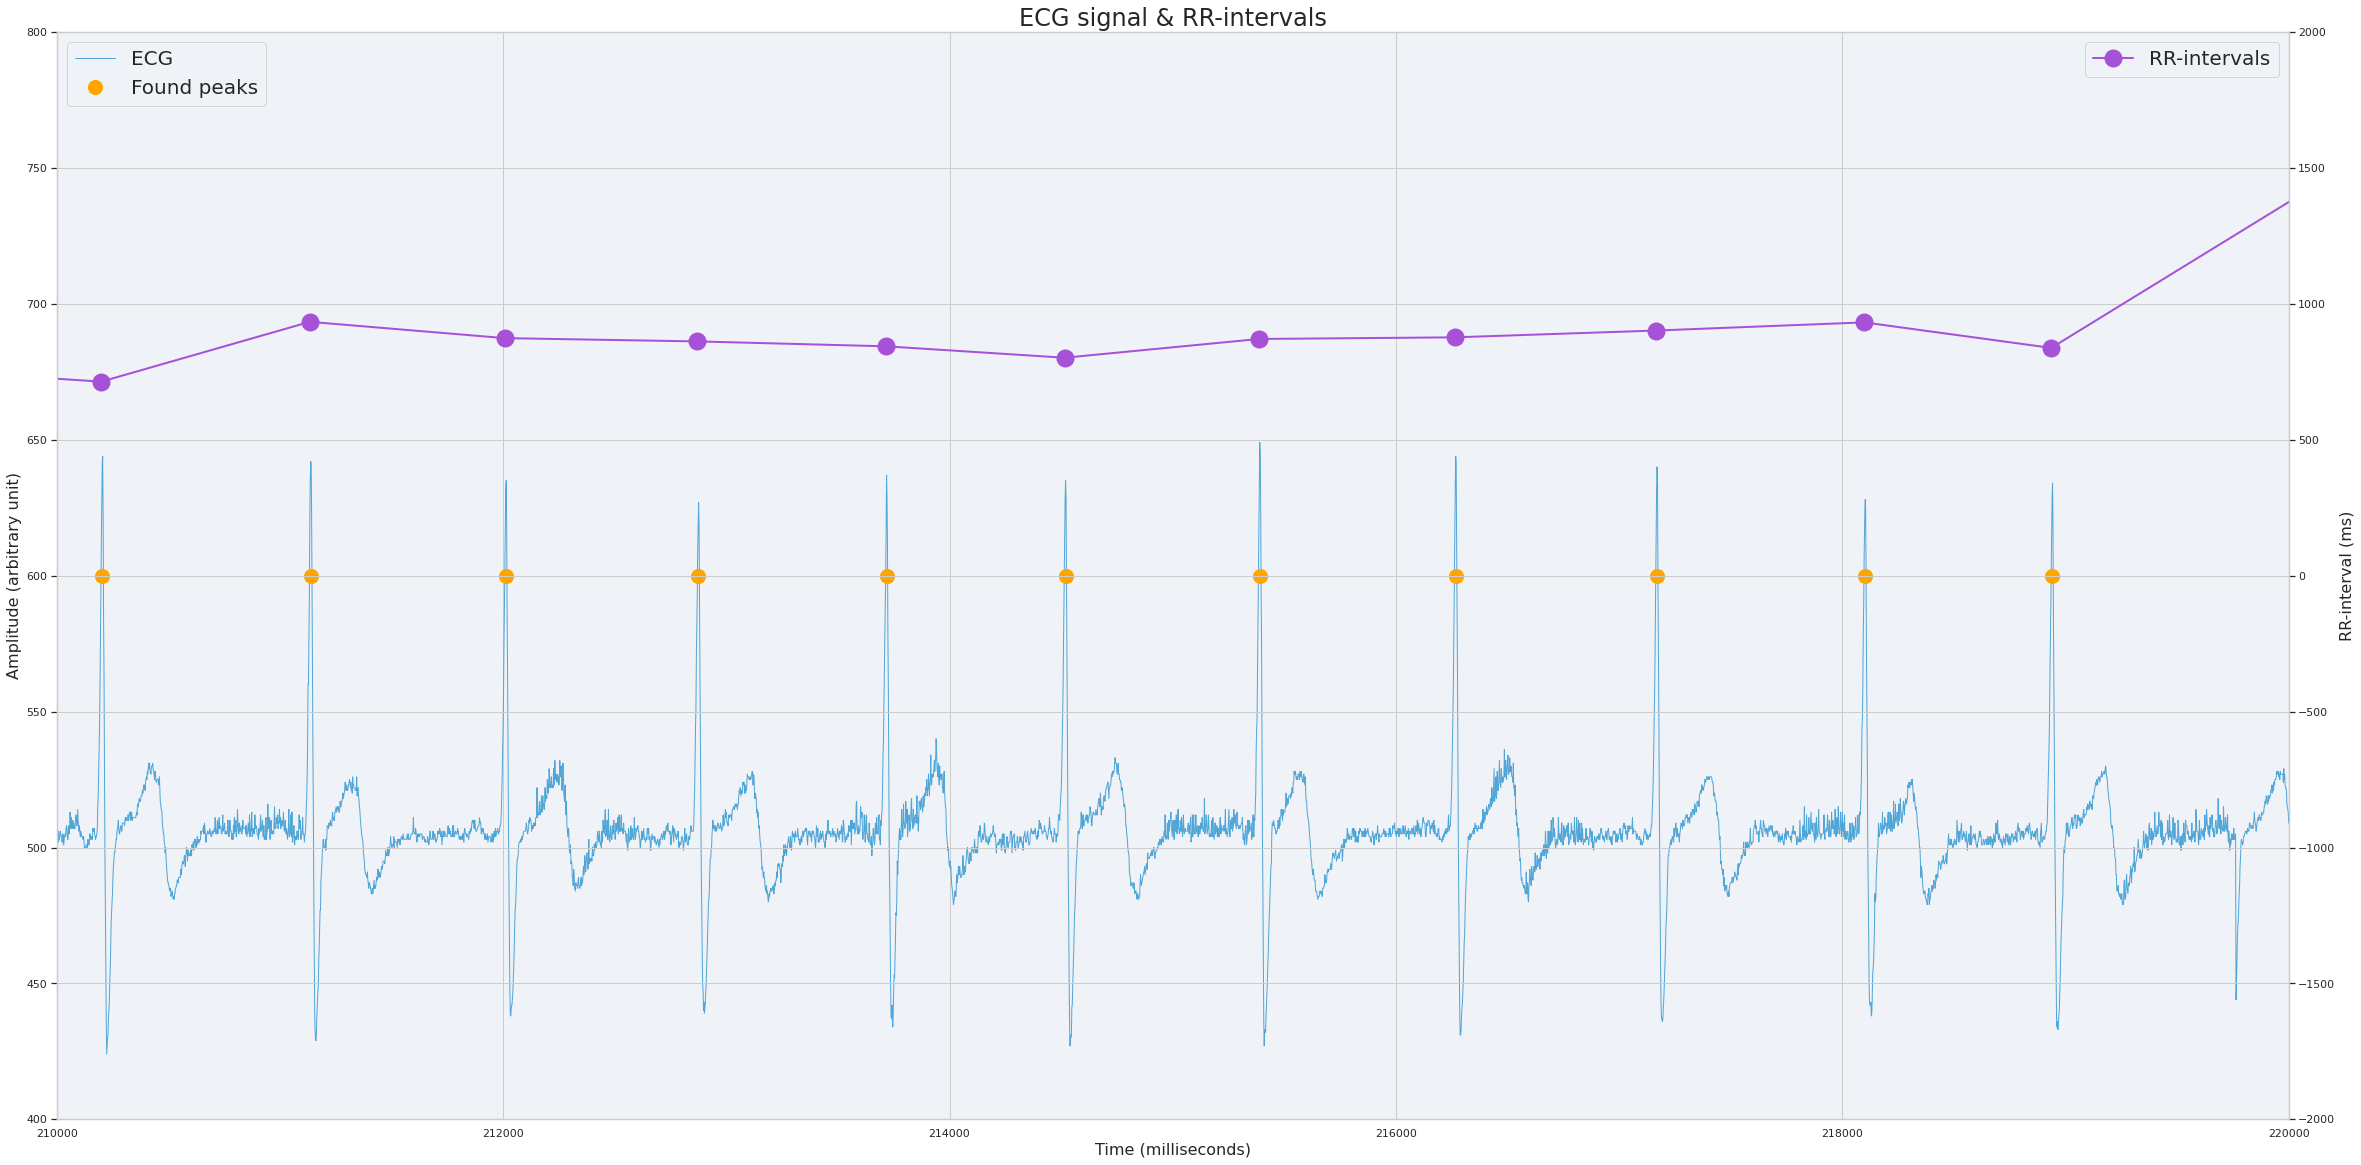

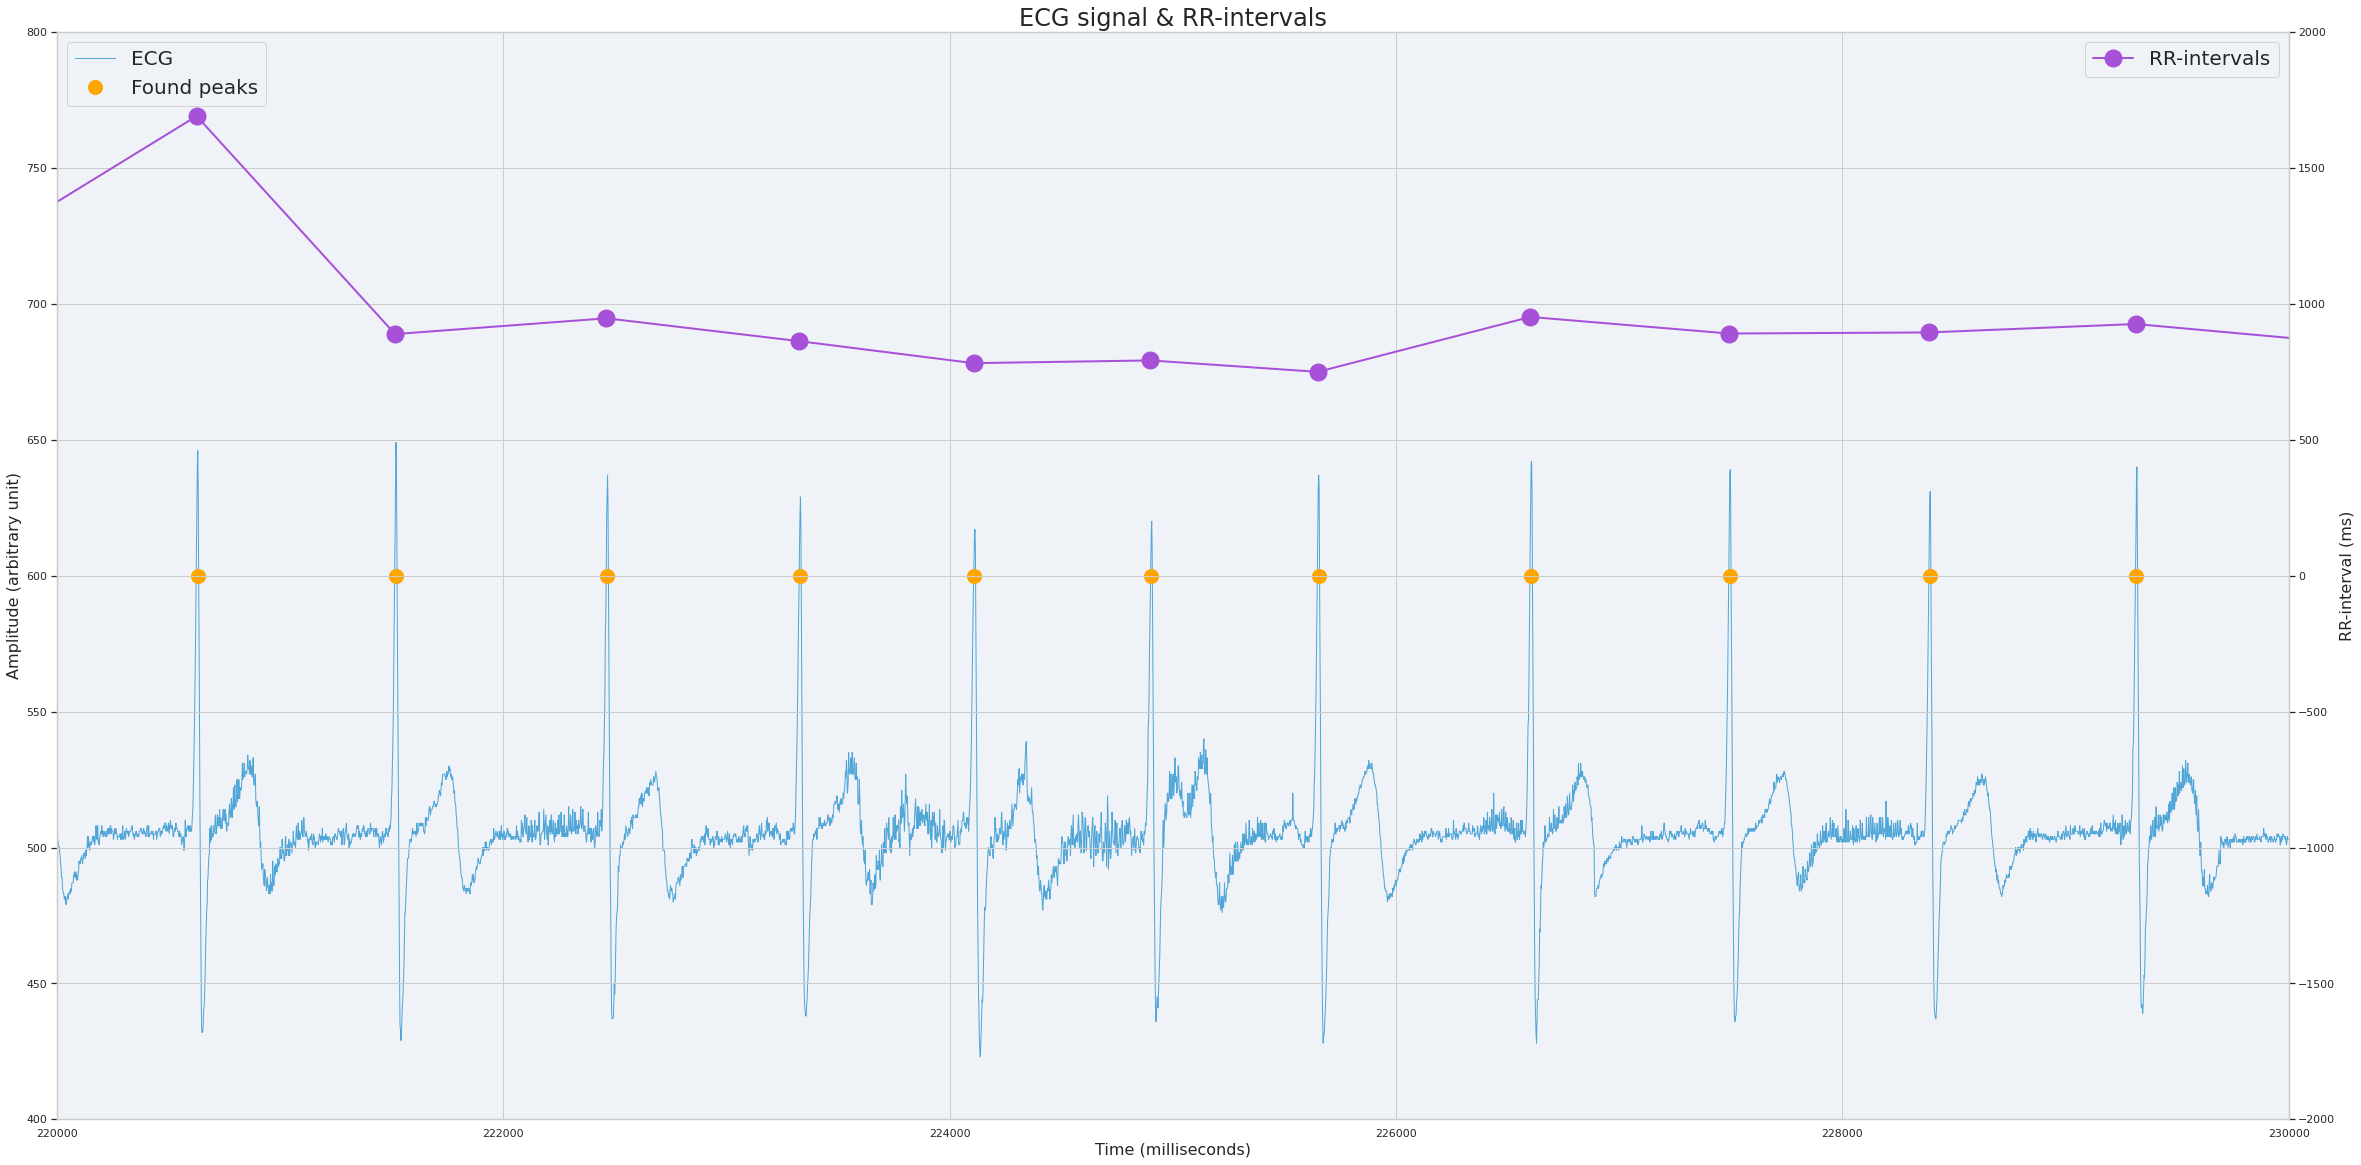

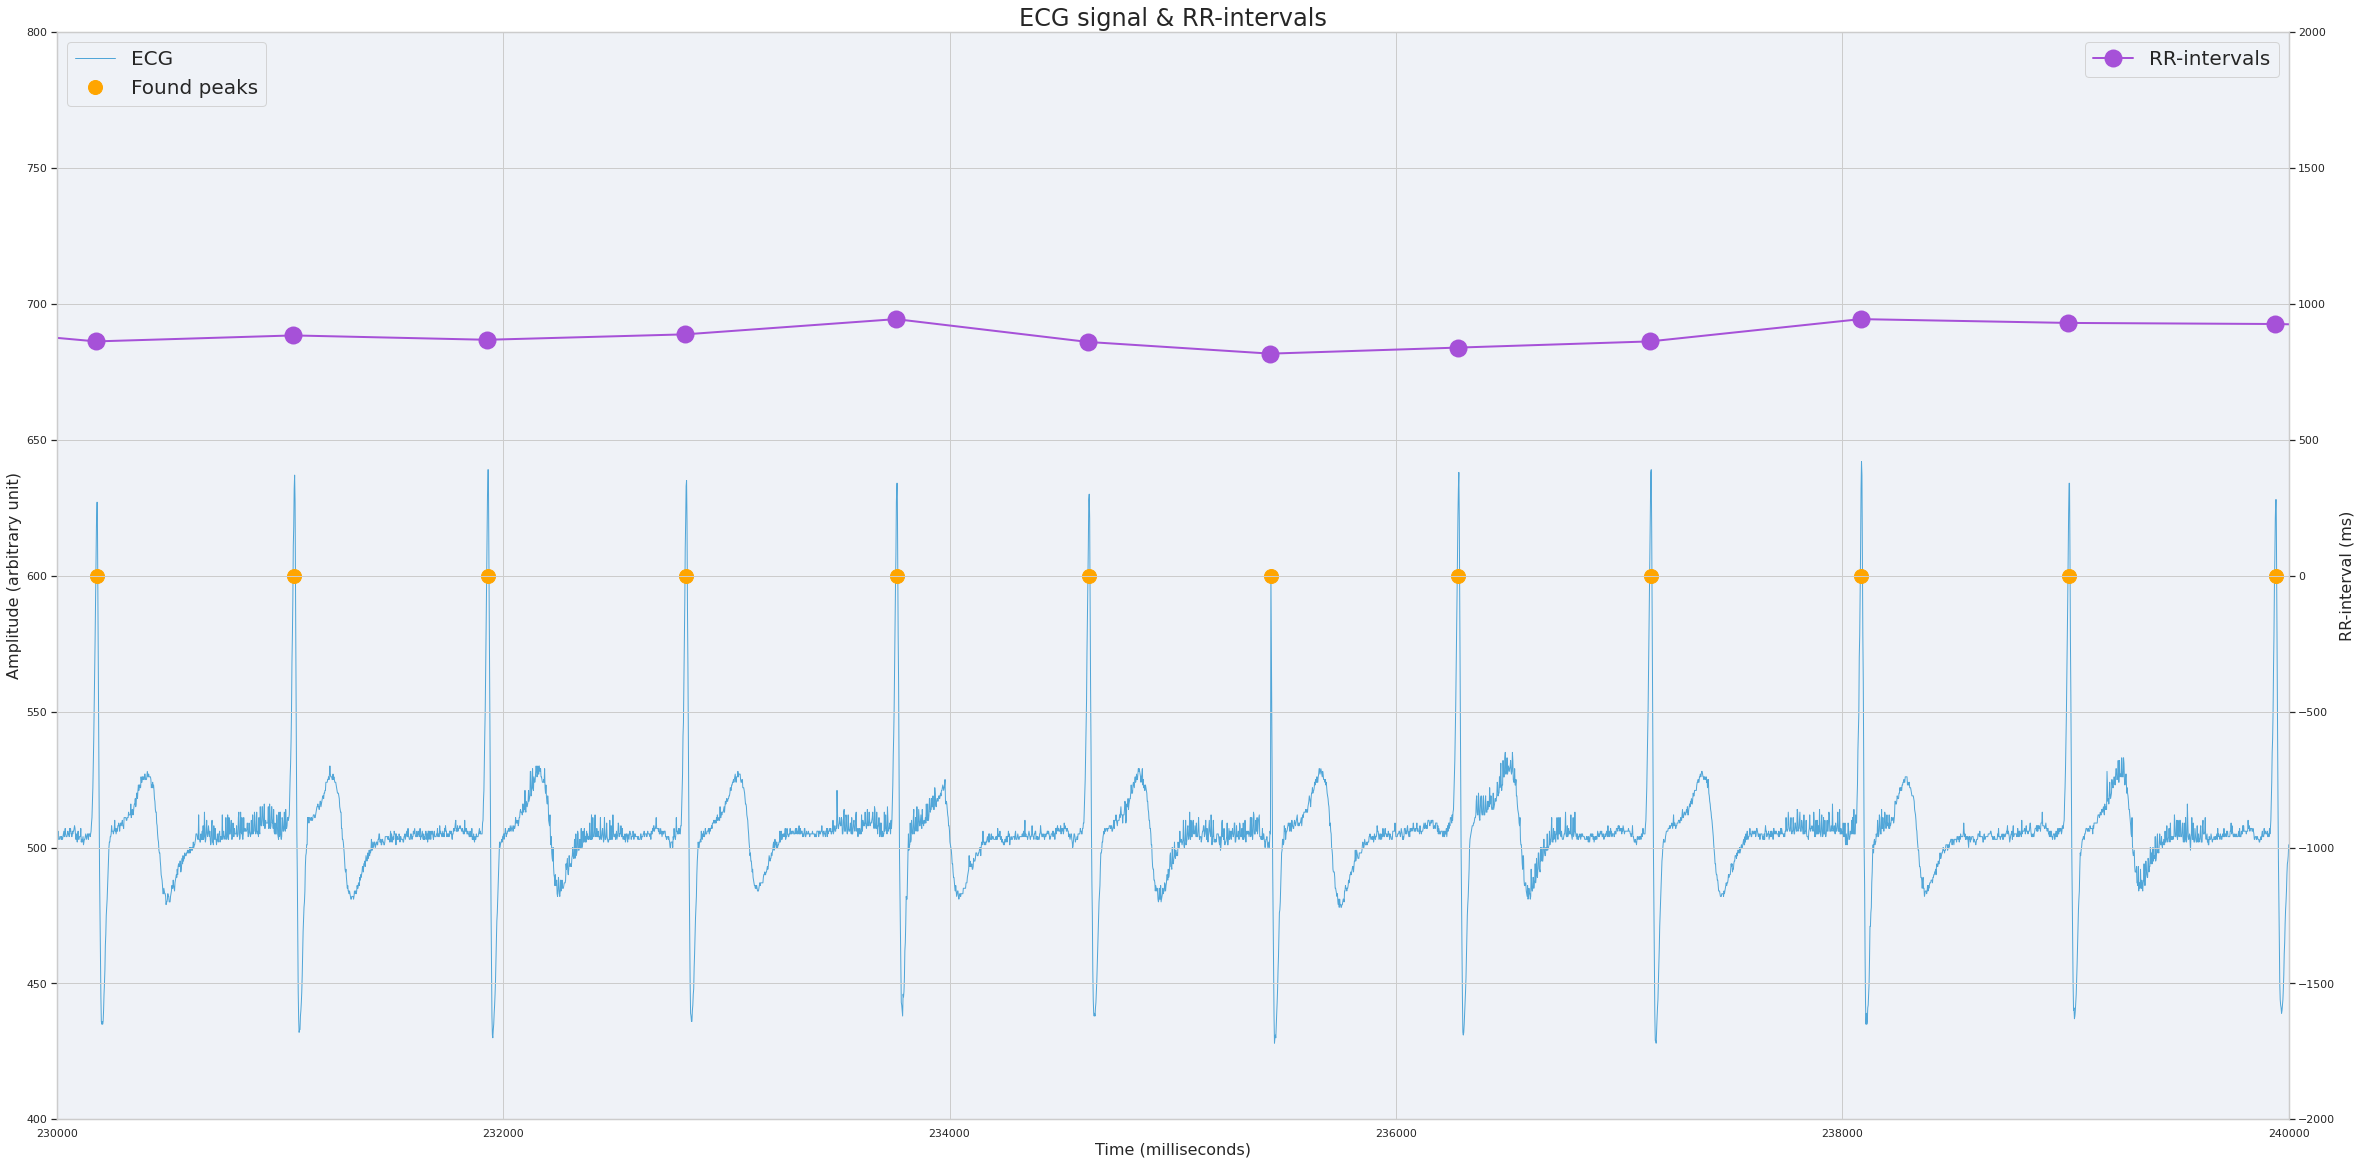

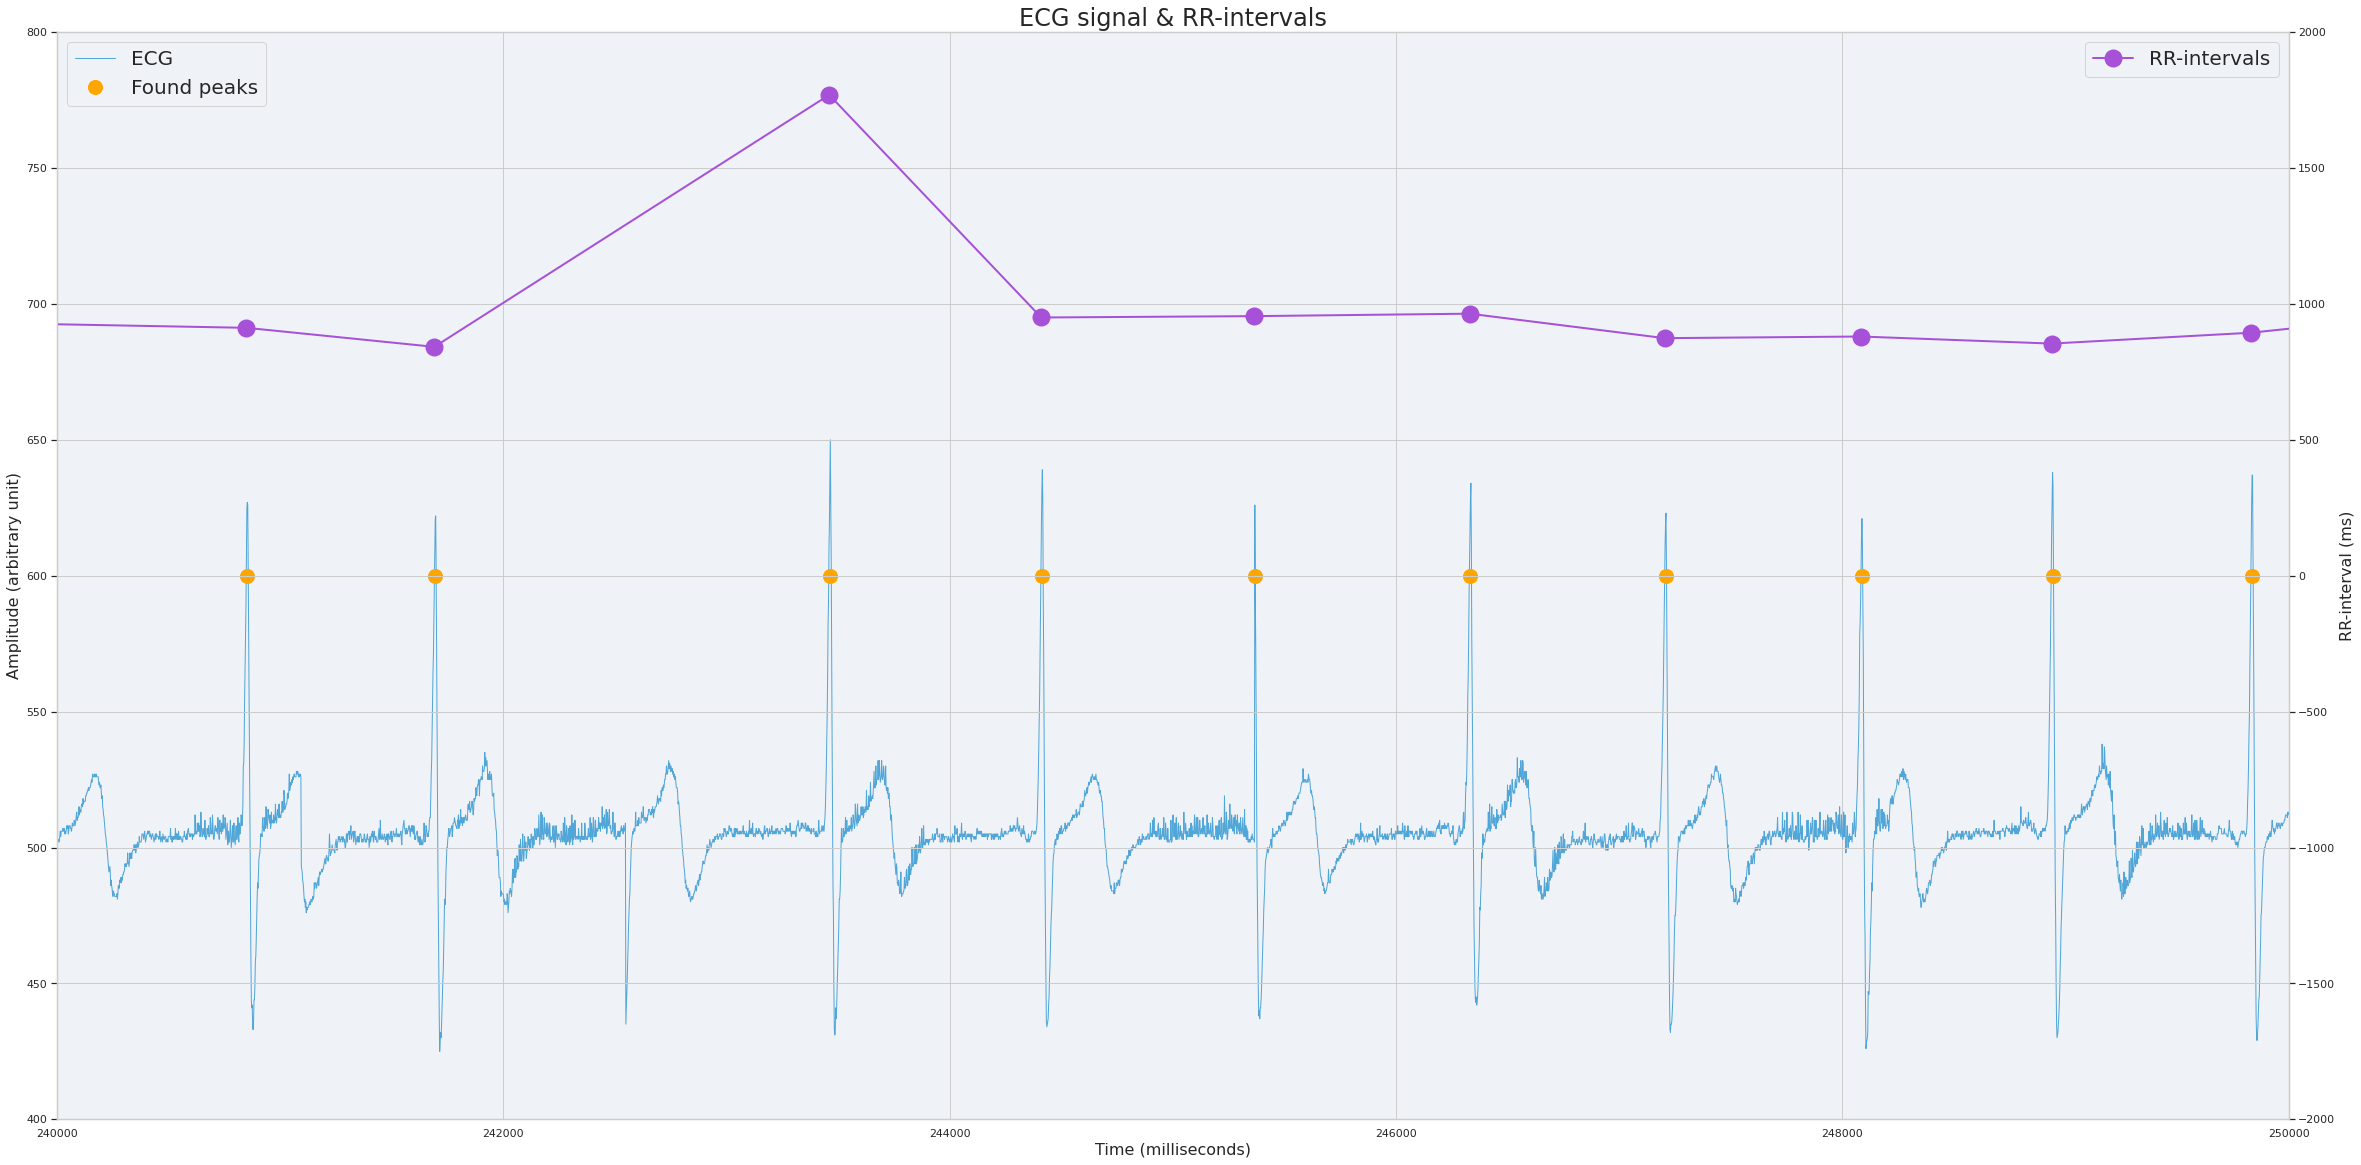

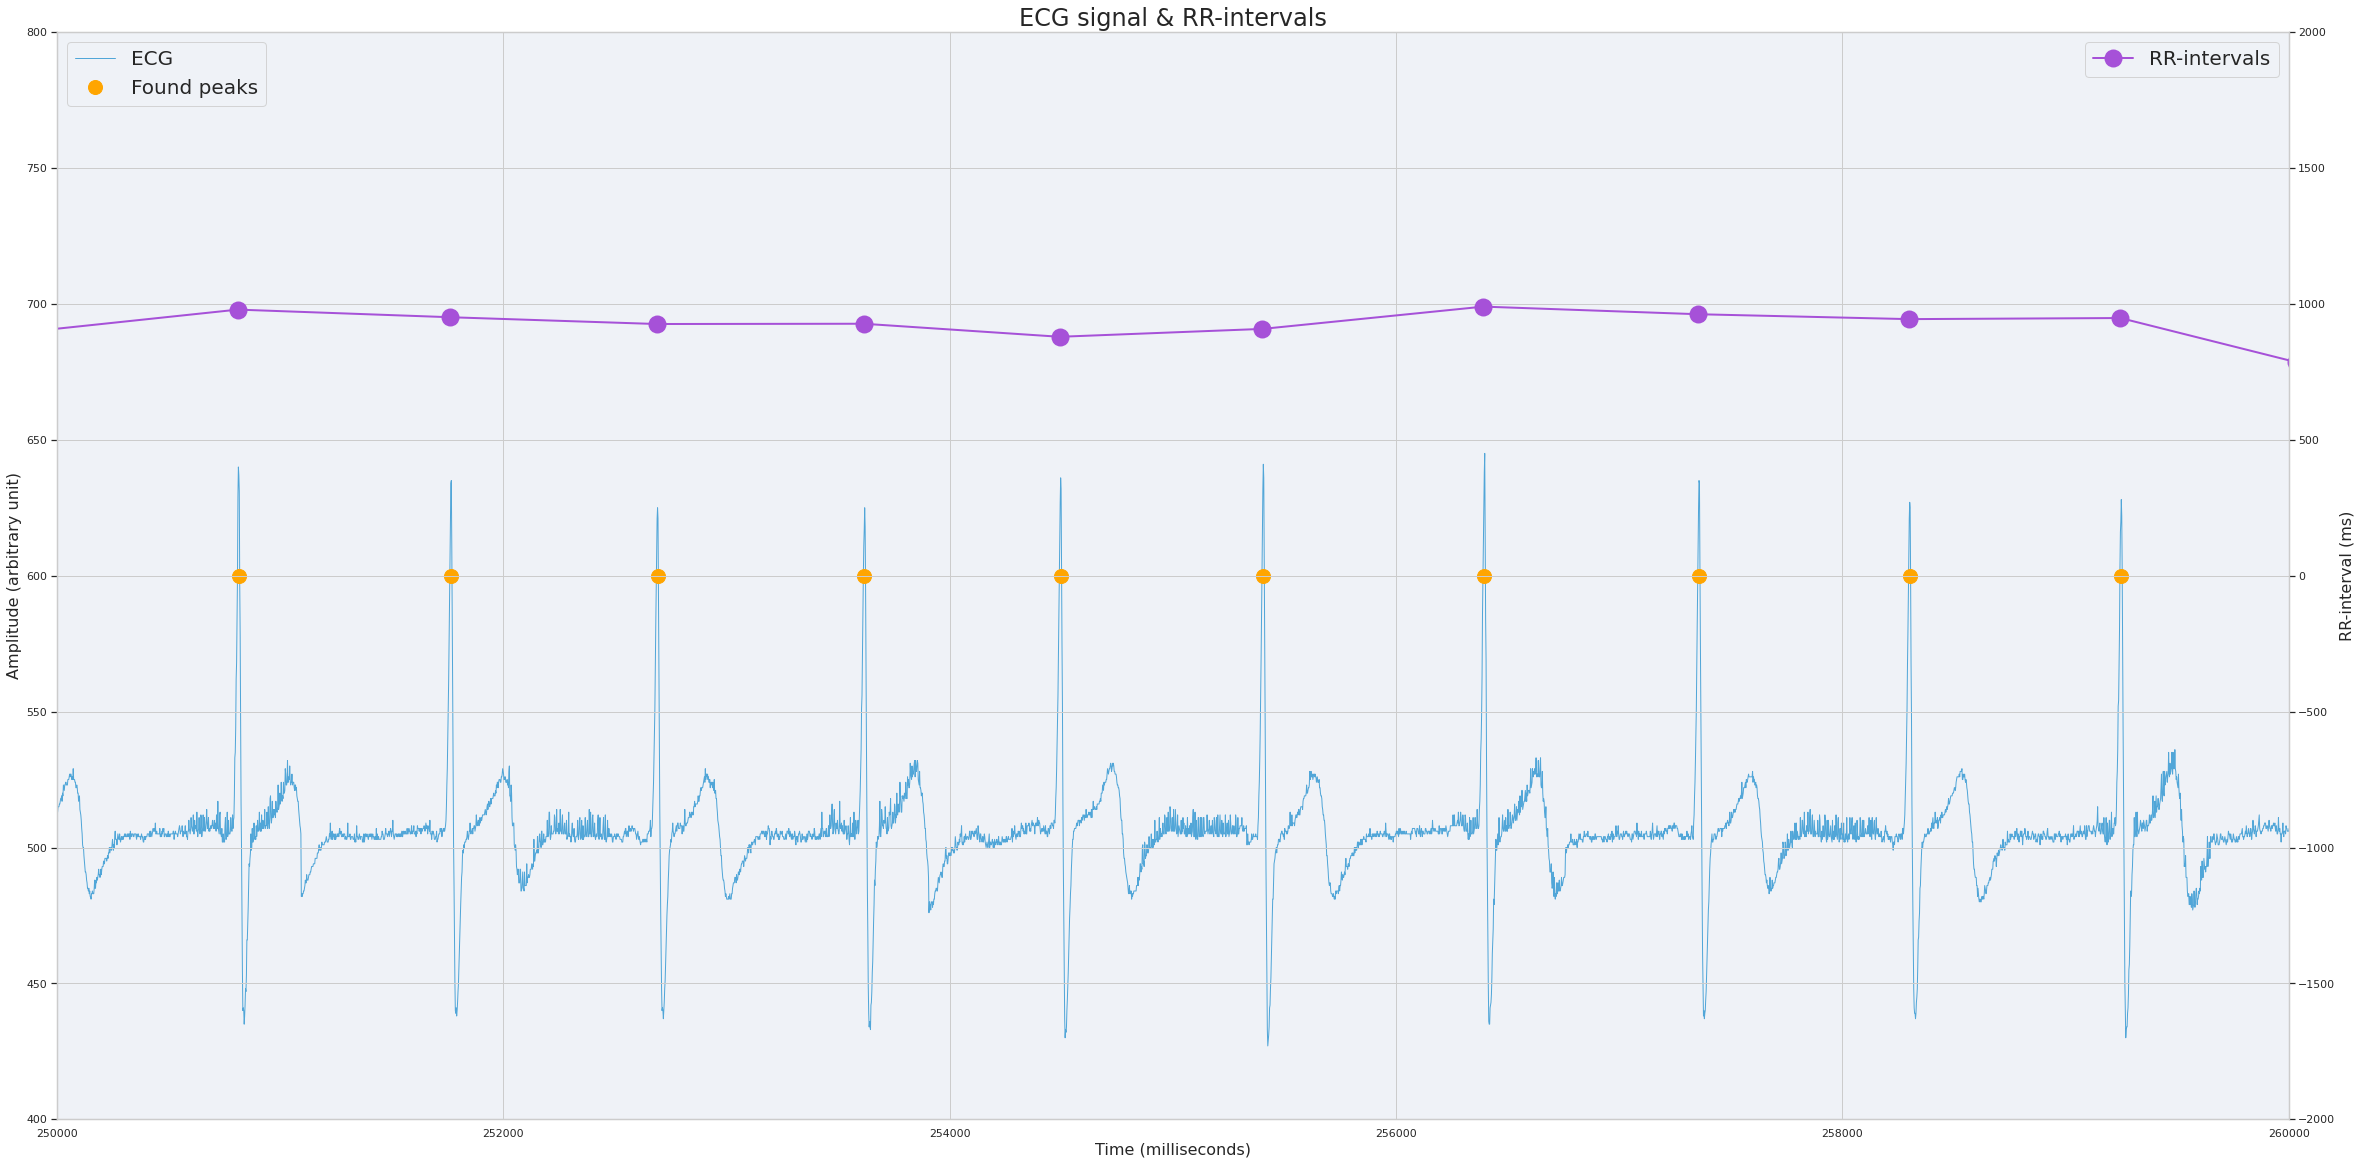

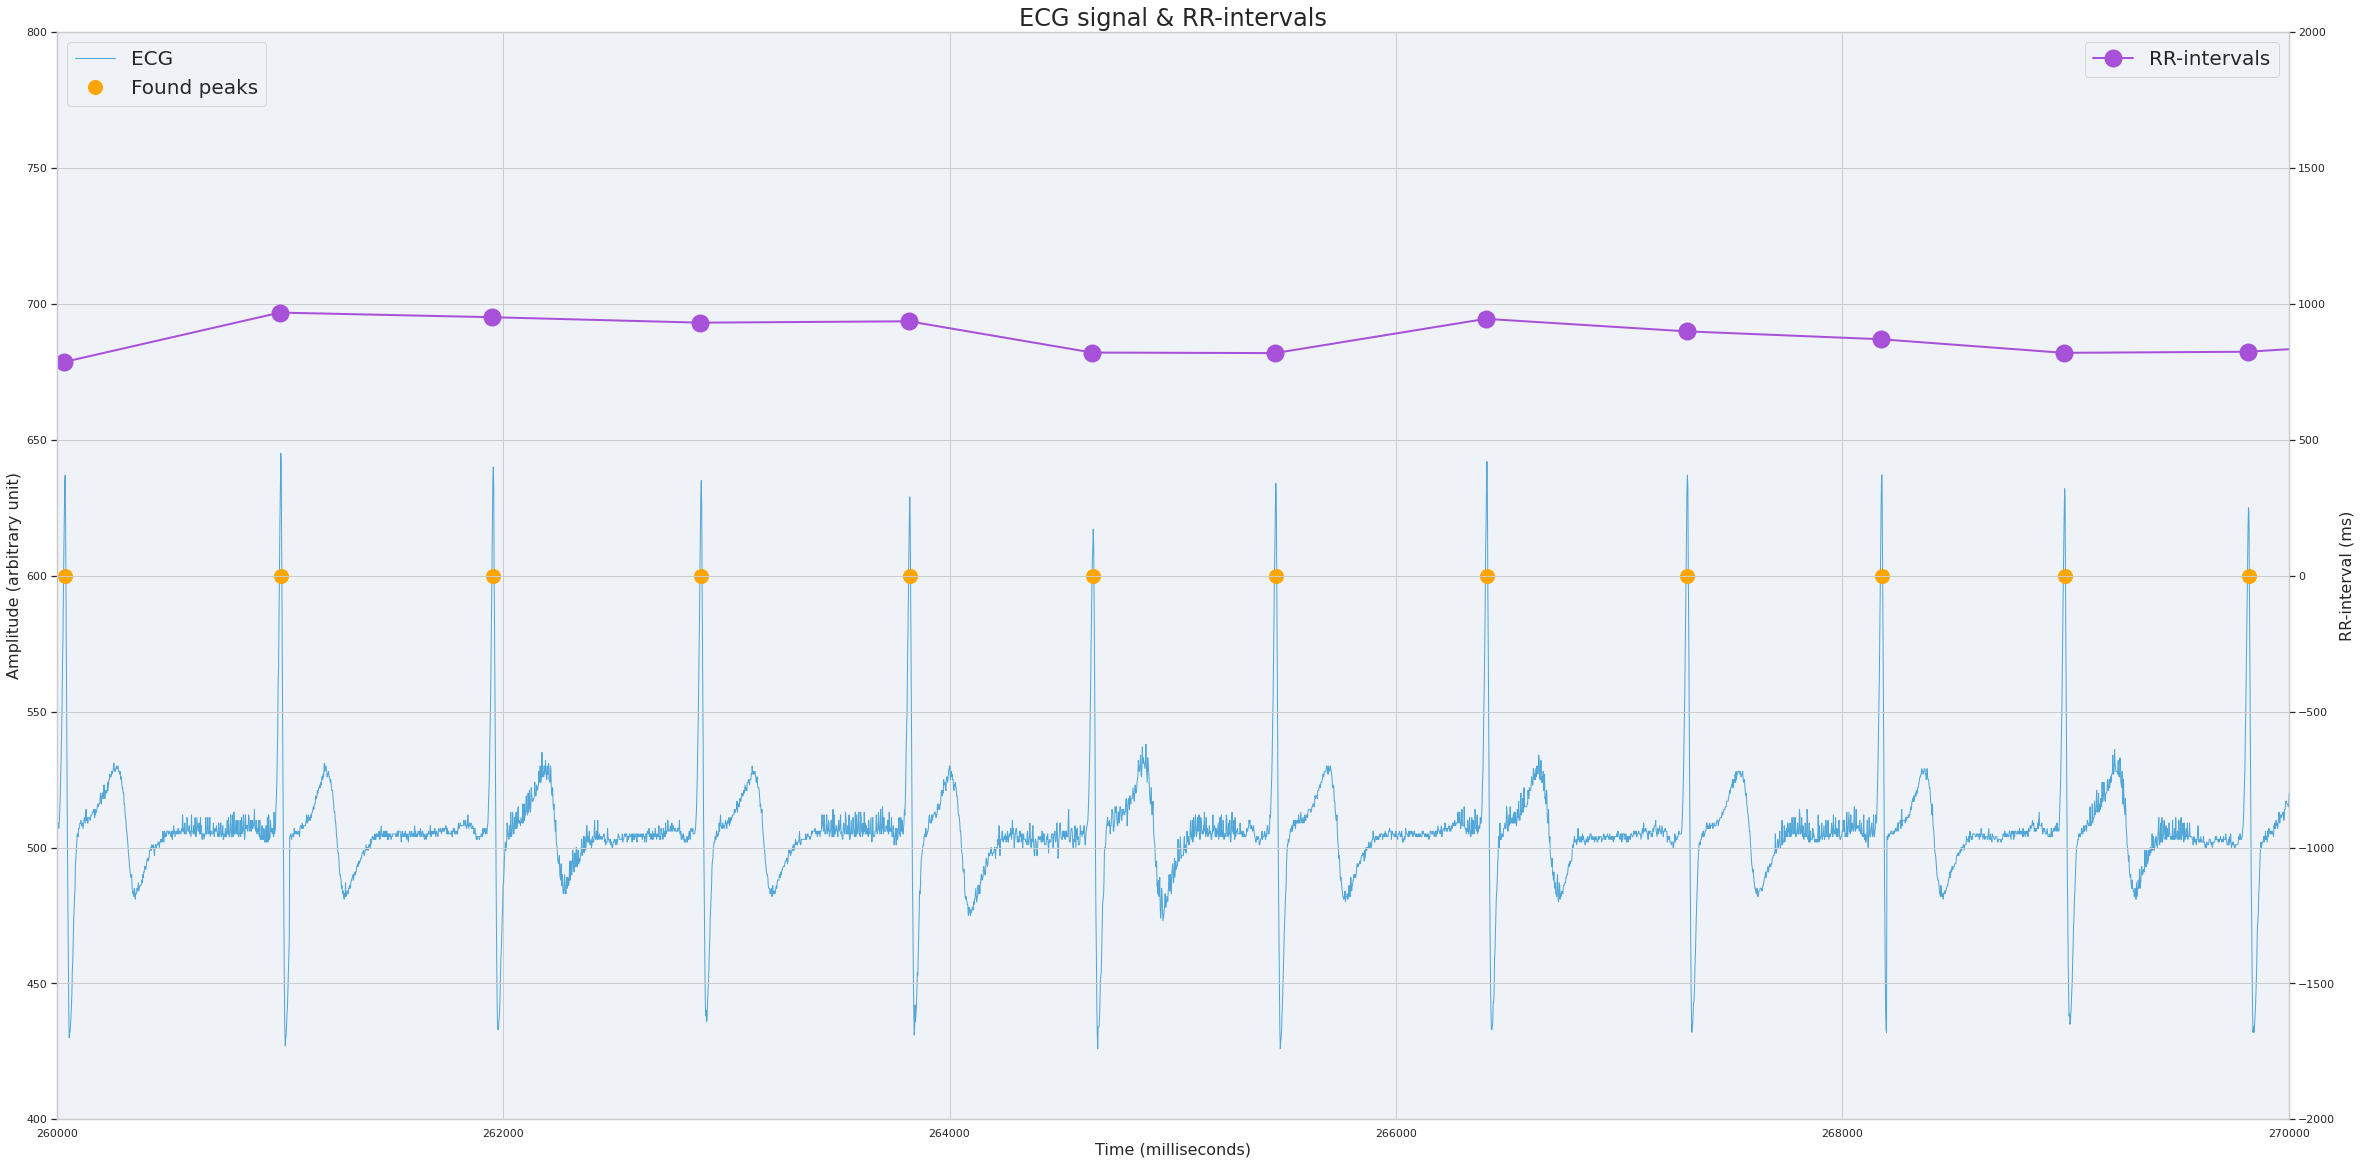

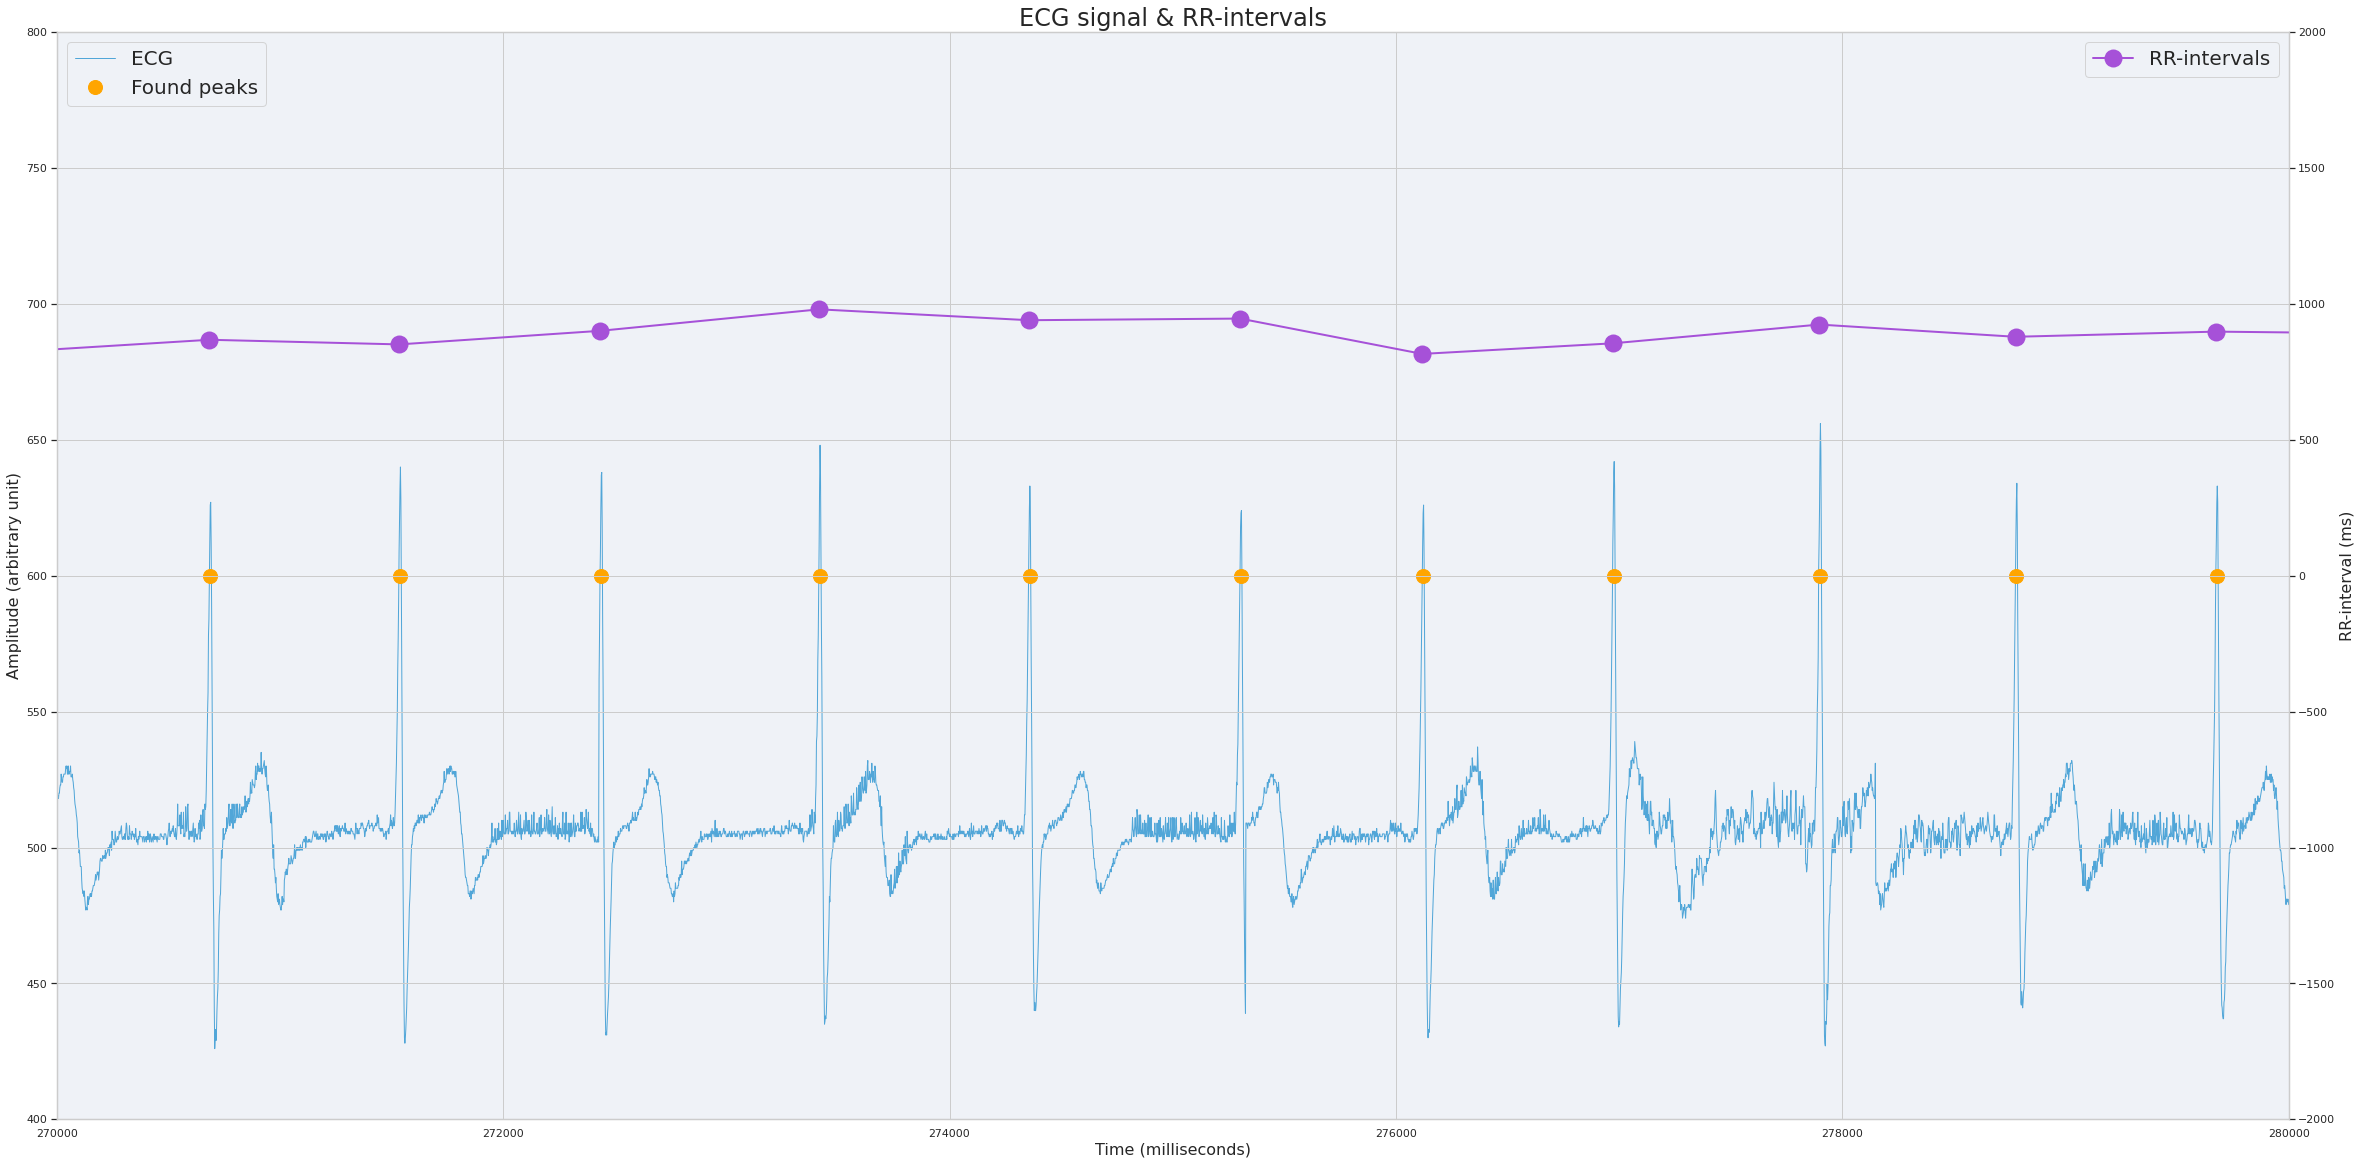

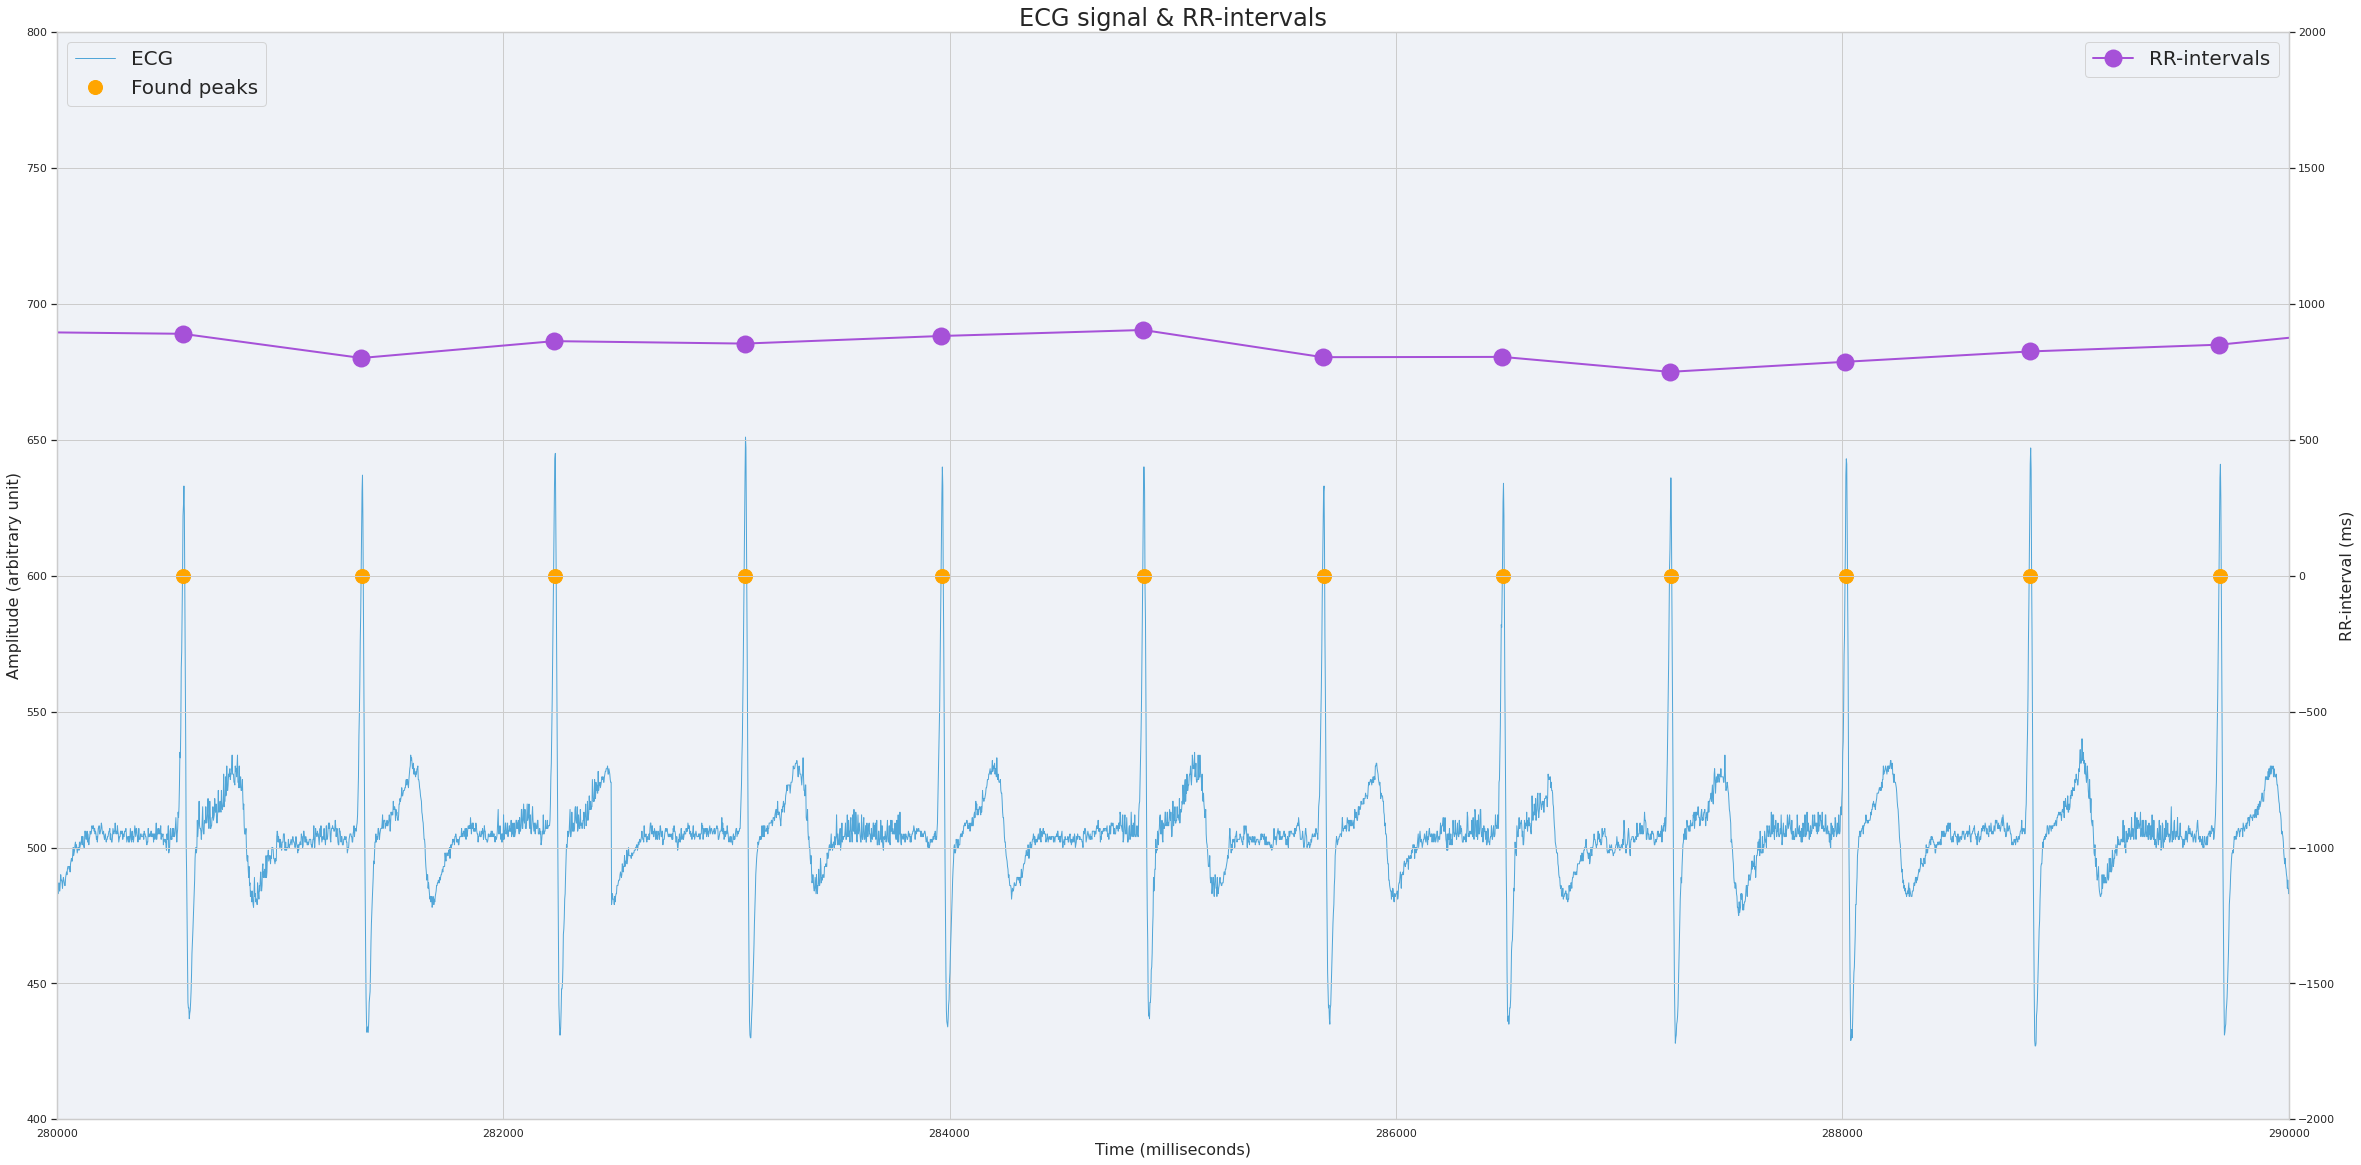

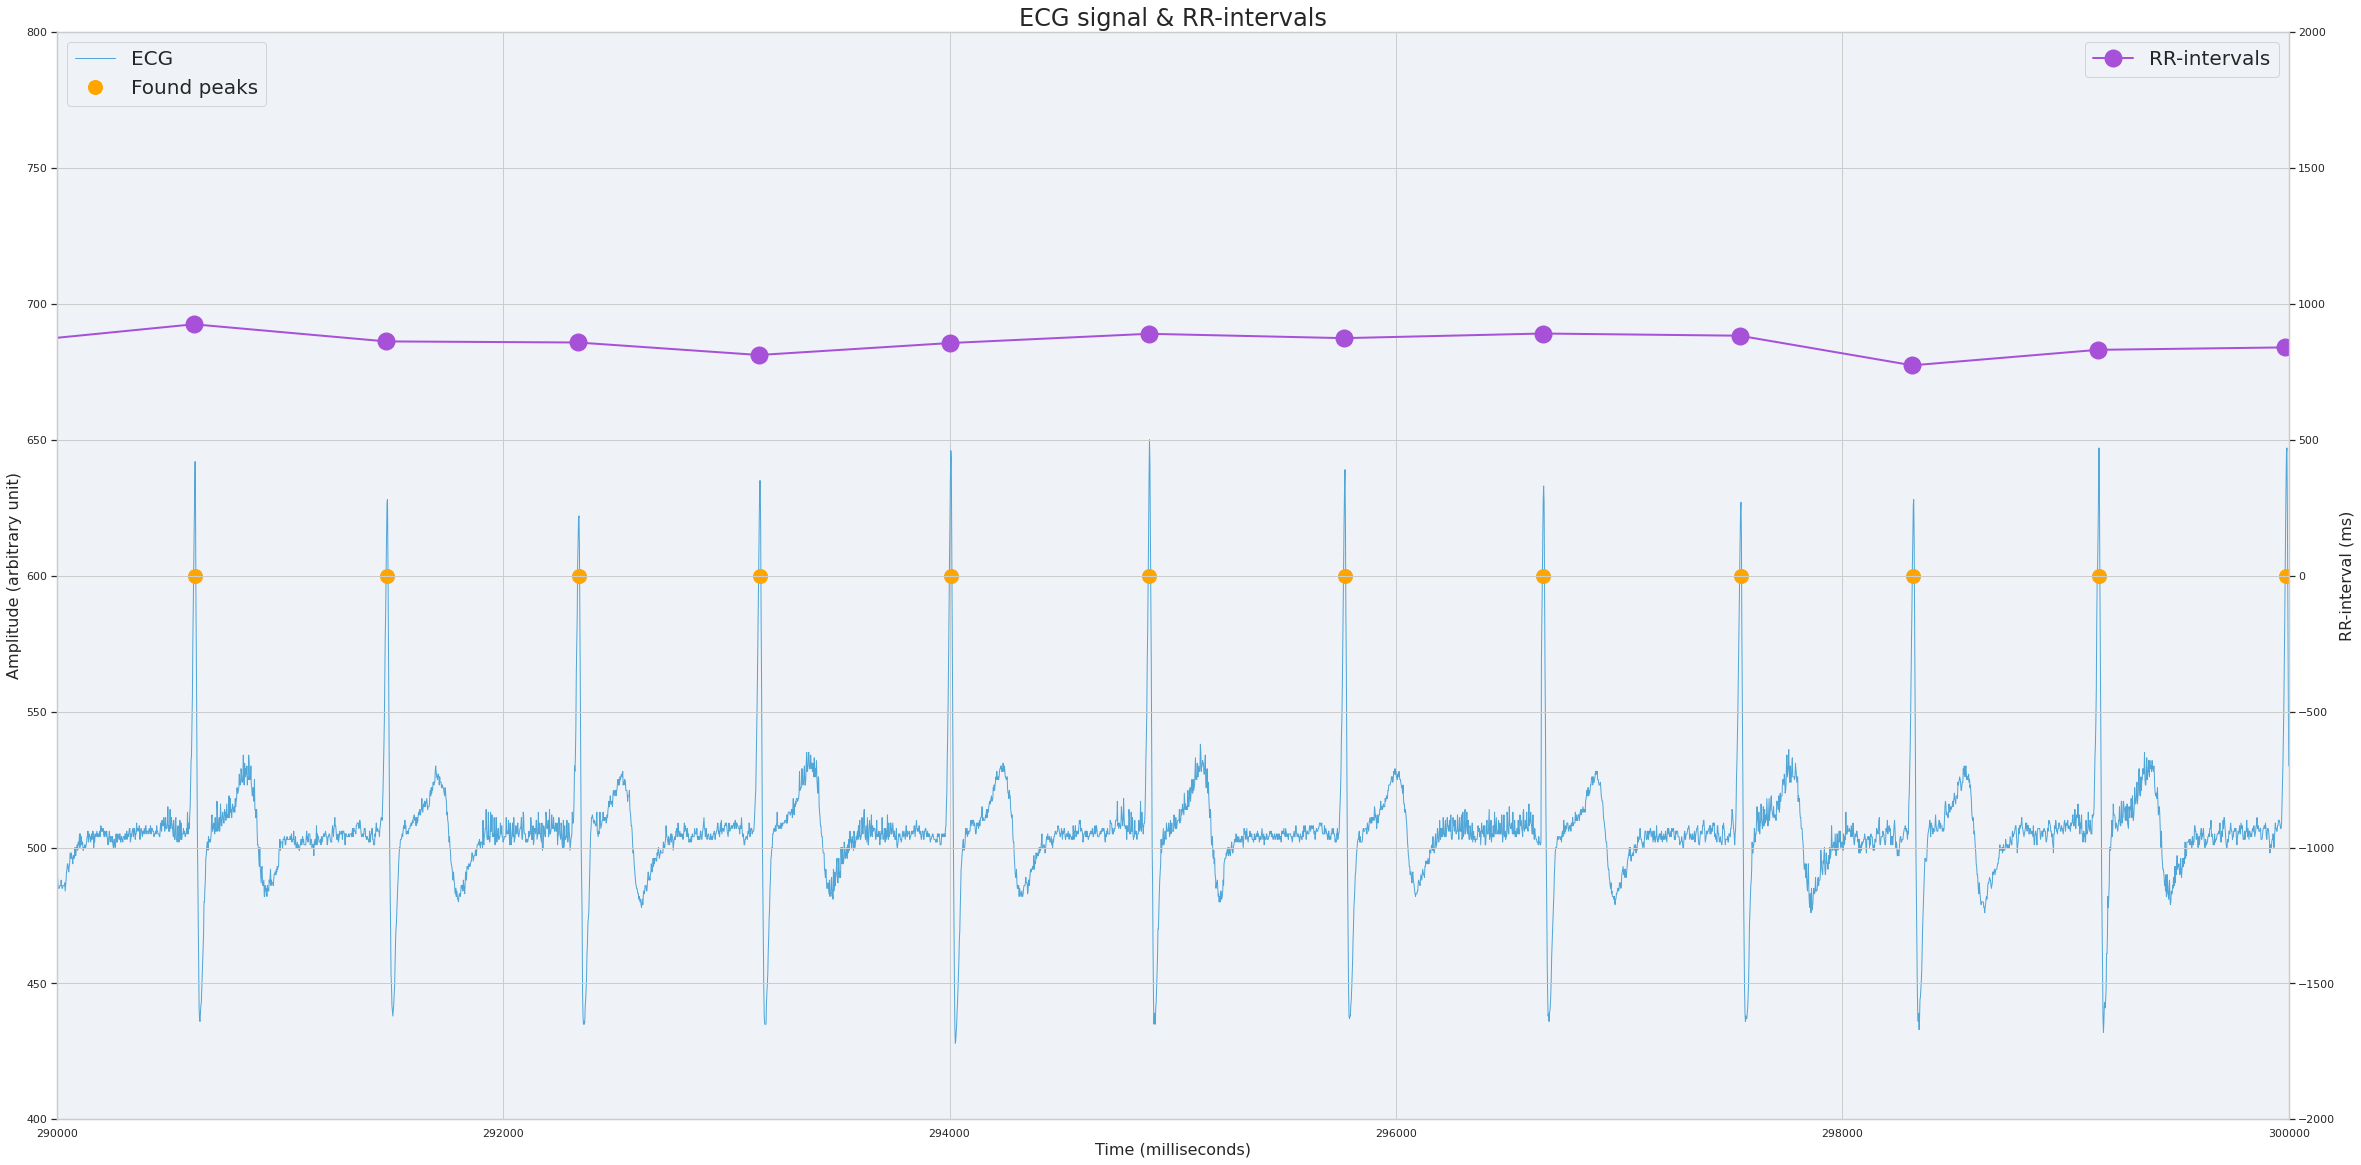

In [ ]:
sampfrom = 200000
sampto = 300000
nr_plots = 10

# detect peaks
peaks, similarity = detect_peaks(df.heartrate, threshold=0.3)

# group peaks so we get a single peak per beat (hopefully)
grouped_peaks = group_peaks(peaks)

# RR-intervals are the differences between successive peaks
rr = np.diff(grouped_peaks)

for start, stop in get_plot_ranges(sampfrom, sampto, nr_plots):
    # plot similarity
    plt.figure(figsize=(40, 20))

    plt.title("ECG signal & RR-intervals", fontsize=24)
    plt.plot(df.index, df.heartrate, label="ECG", color="#51A6D8", linewidth=1)
    plt.plot(grouped_peaks, np.repeat(600, grouped_peaks.shape[0]), markersize=14, label="Found peaks", color="orange", marker="o", linestyle="None")
    plt.legend(loc="upper left", fontsize=20)
    plt.xlabel("Time (milliseconds)", fontsize=16)
    plt.ylabel("Amplitude (arbitrary unit)", fontsize=16)
    plt.gca().set_ylim(400, 800)
    
    ax2 = plt.gca().twinx()
    ax2.plot(np.cumsum(rr)+peaks[0], rr, label="RR-intervals", color="#A651D8", linewidth=2, markerfacecolor="#A651D8", markeredgewidth=0, marker="o", markersize=18)
    ax2.set_xlim(start, stop)
    ax2.set_ylim(-2000, 2000)
    ax2.legend(loc="upper right", fontsize=20)

    plt.xlabel("Time (ms)", fontsize=16)
    plt.ylabel("RR-interval (ms)", fontsize=16)

    plt.savefig(os.path.join(output_path, "ecg-with-rr-%s-%s.png" % (start, stop)))

### Export rr-intervals for analysis in Kubios


In [ ]:
np.savetxt(os.path.join(output_path, "rr.txt"), rr_corrected, fmt='%d')

### Plot ECG vs manually corrected RR intervals

In [ ]:
rr_manual = np.loadtxt(os.path.join(data_path, "manual-correction-rr.txt"), dtype=int)

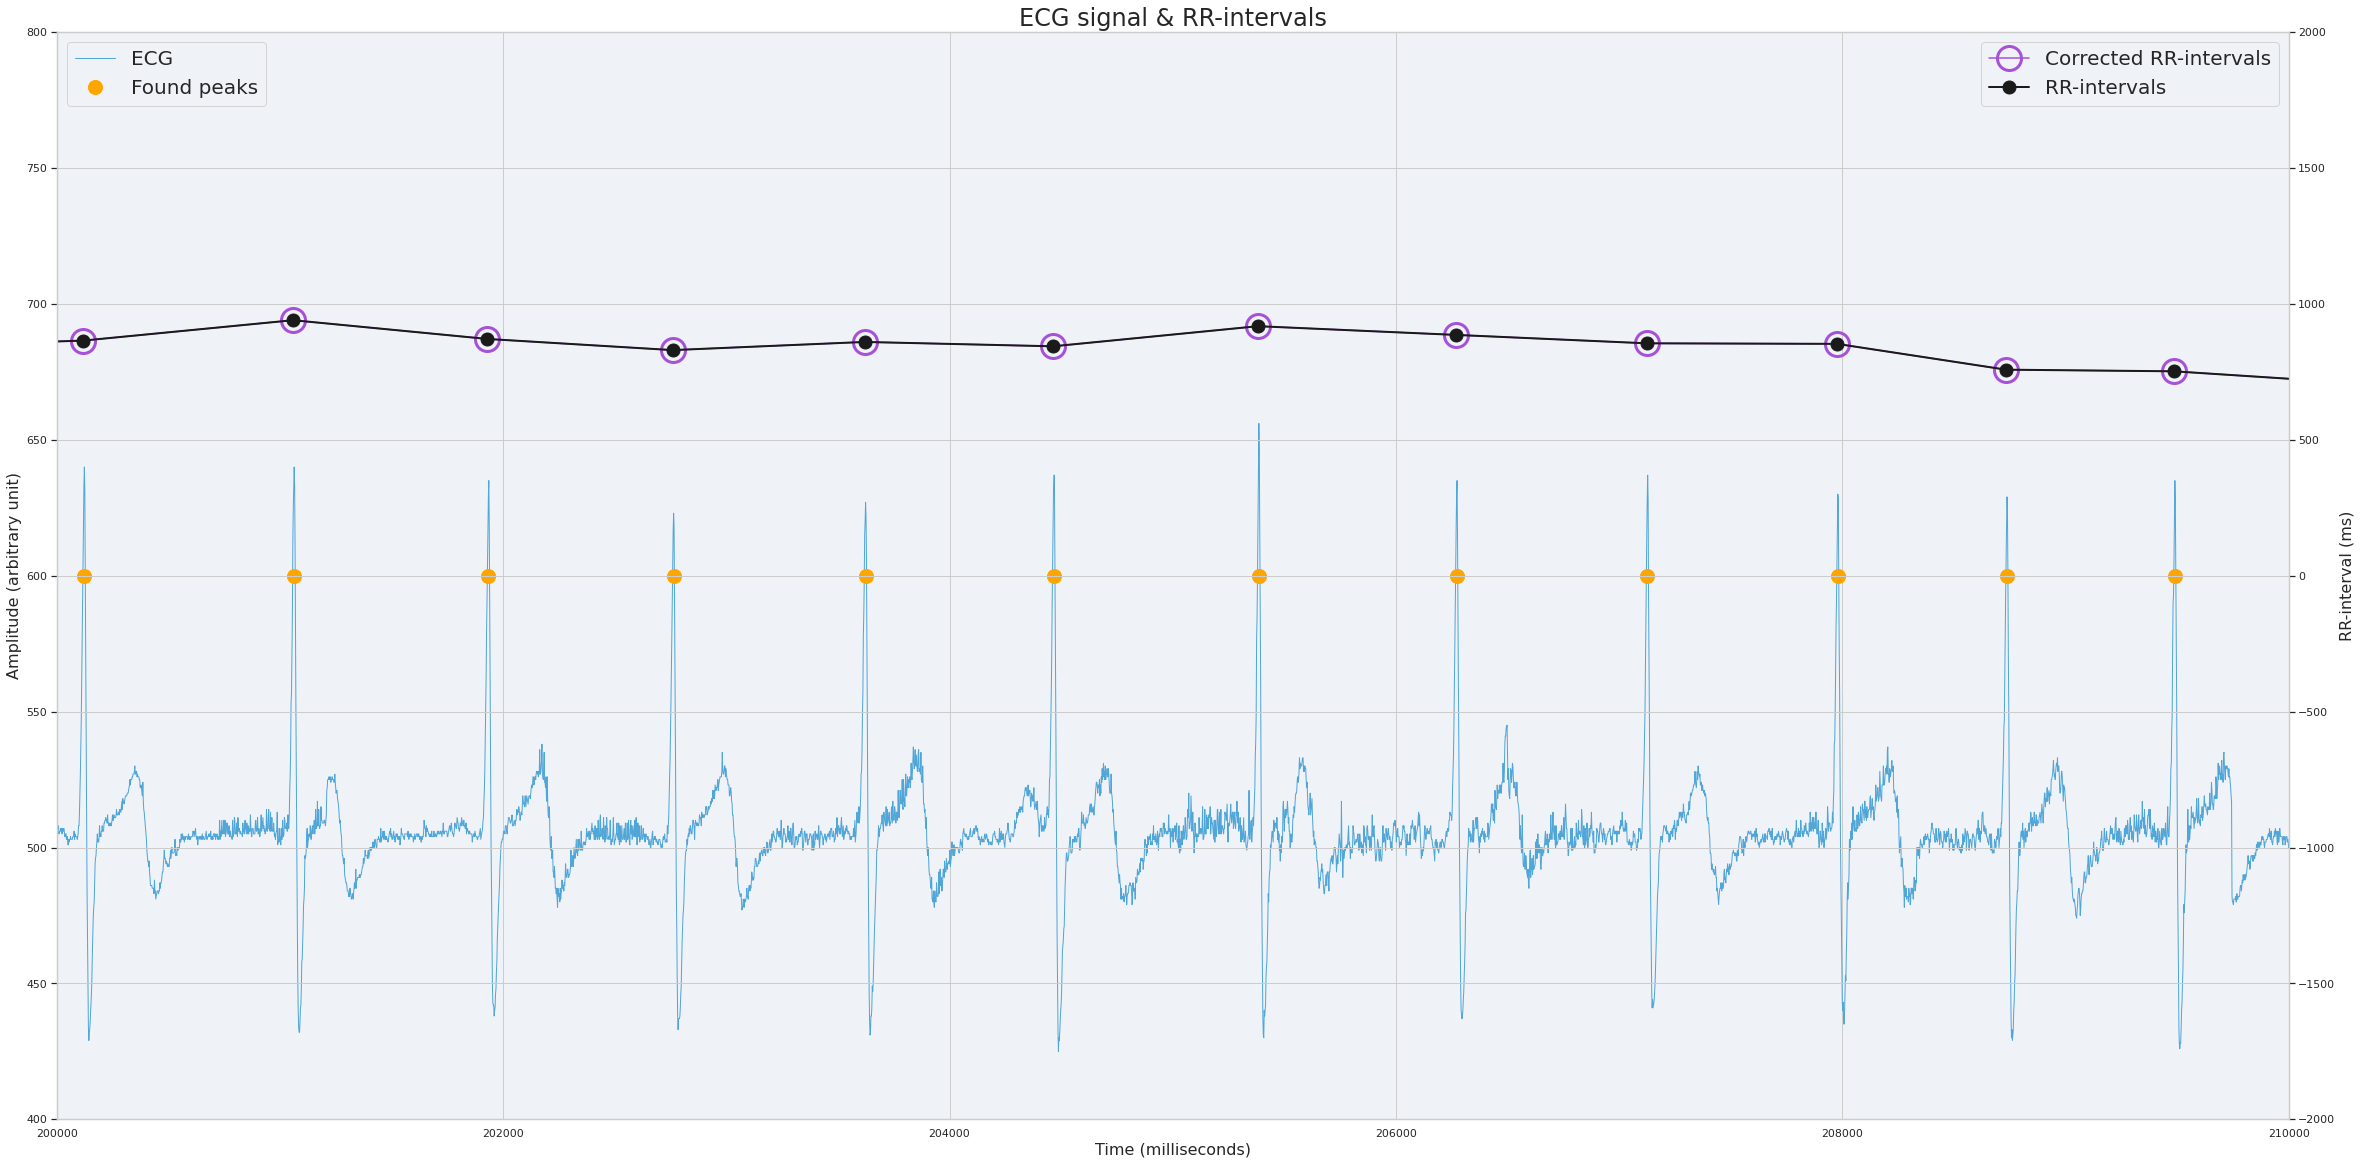

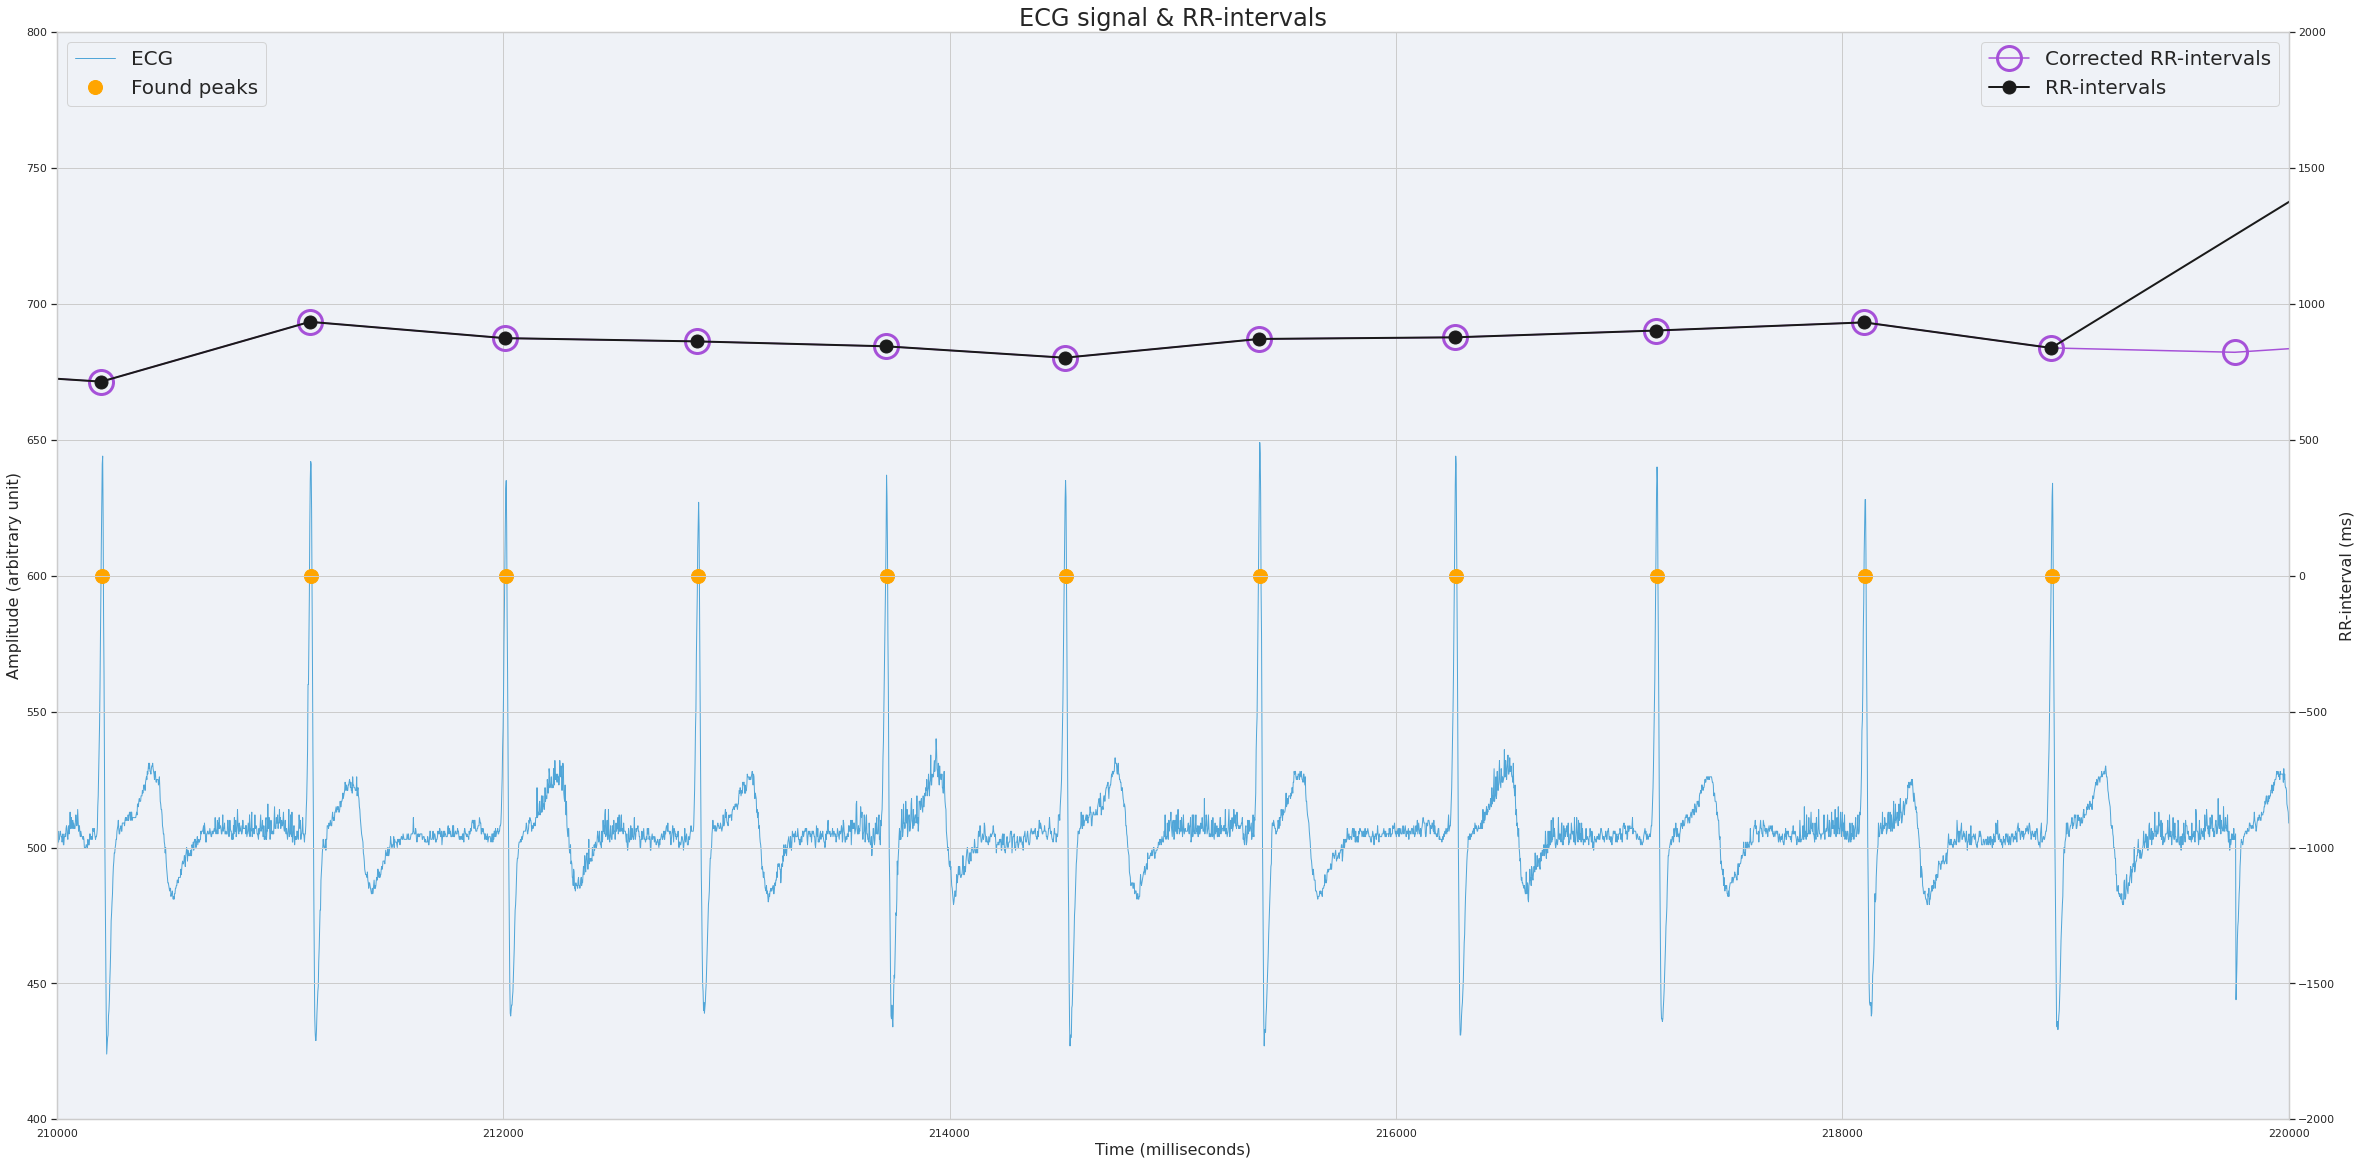

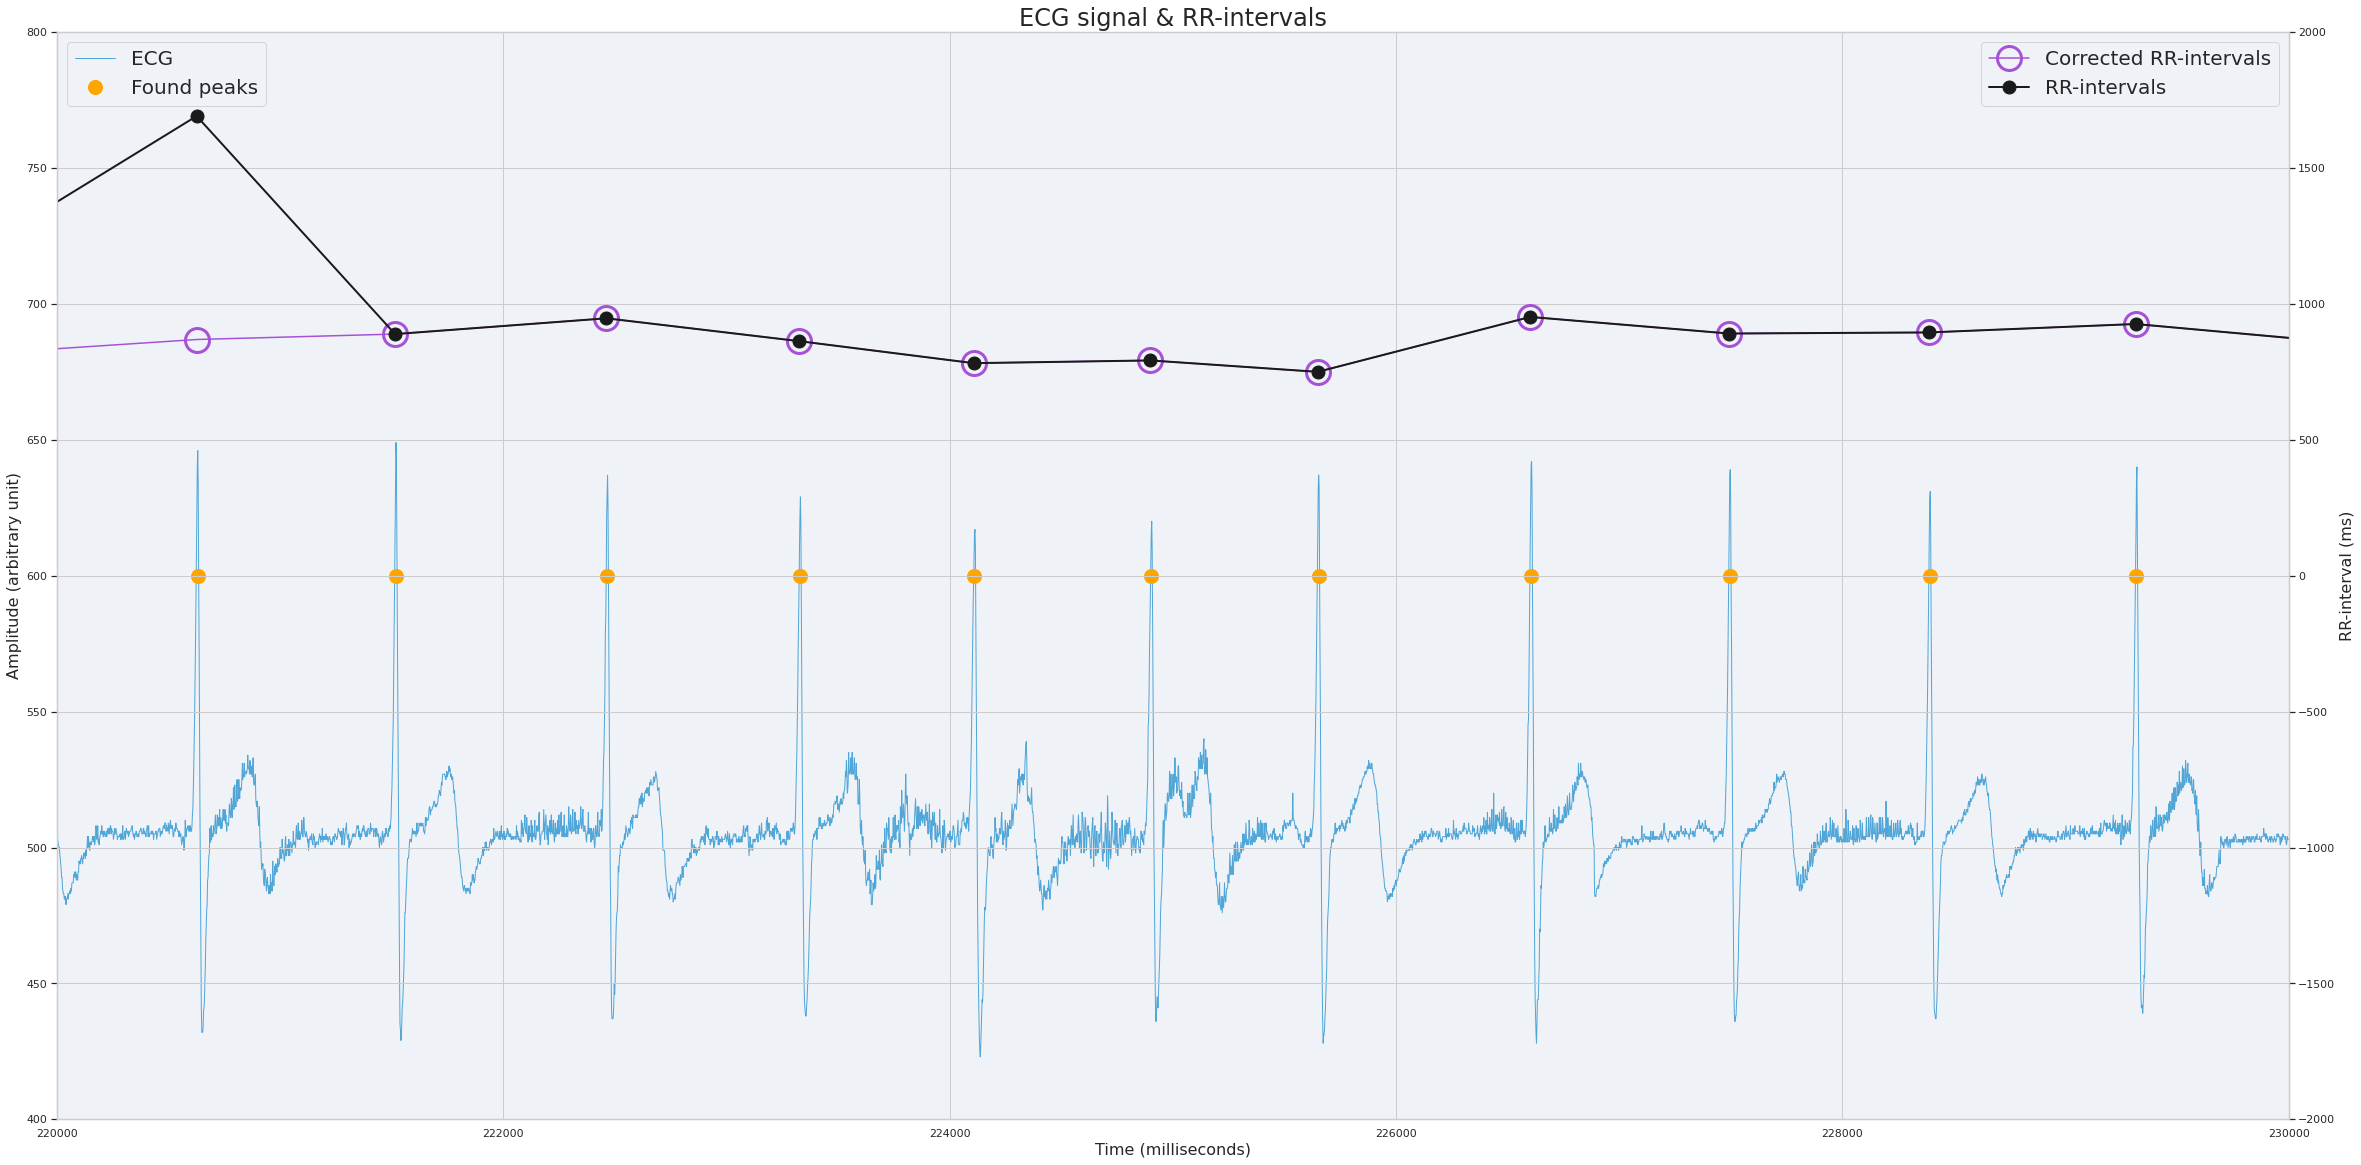

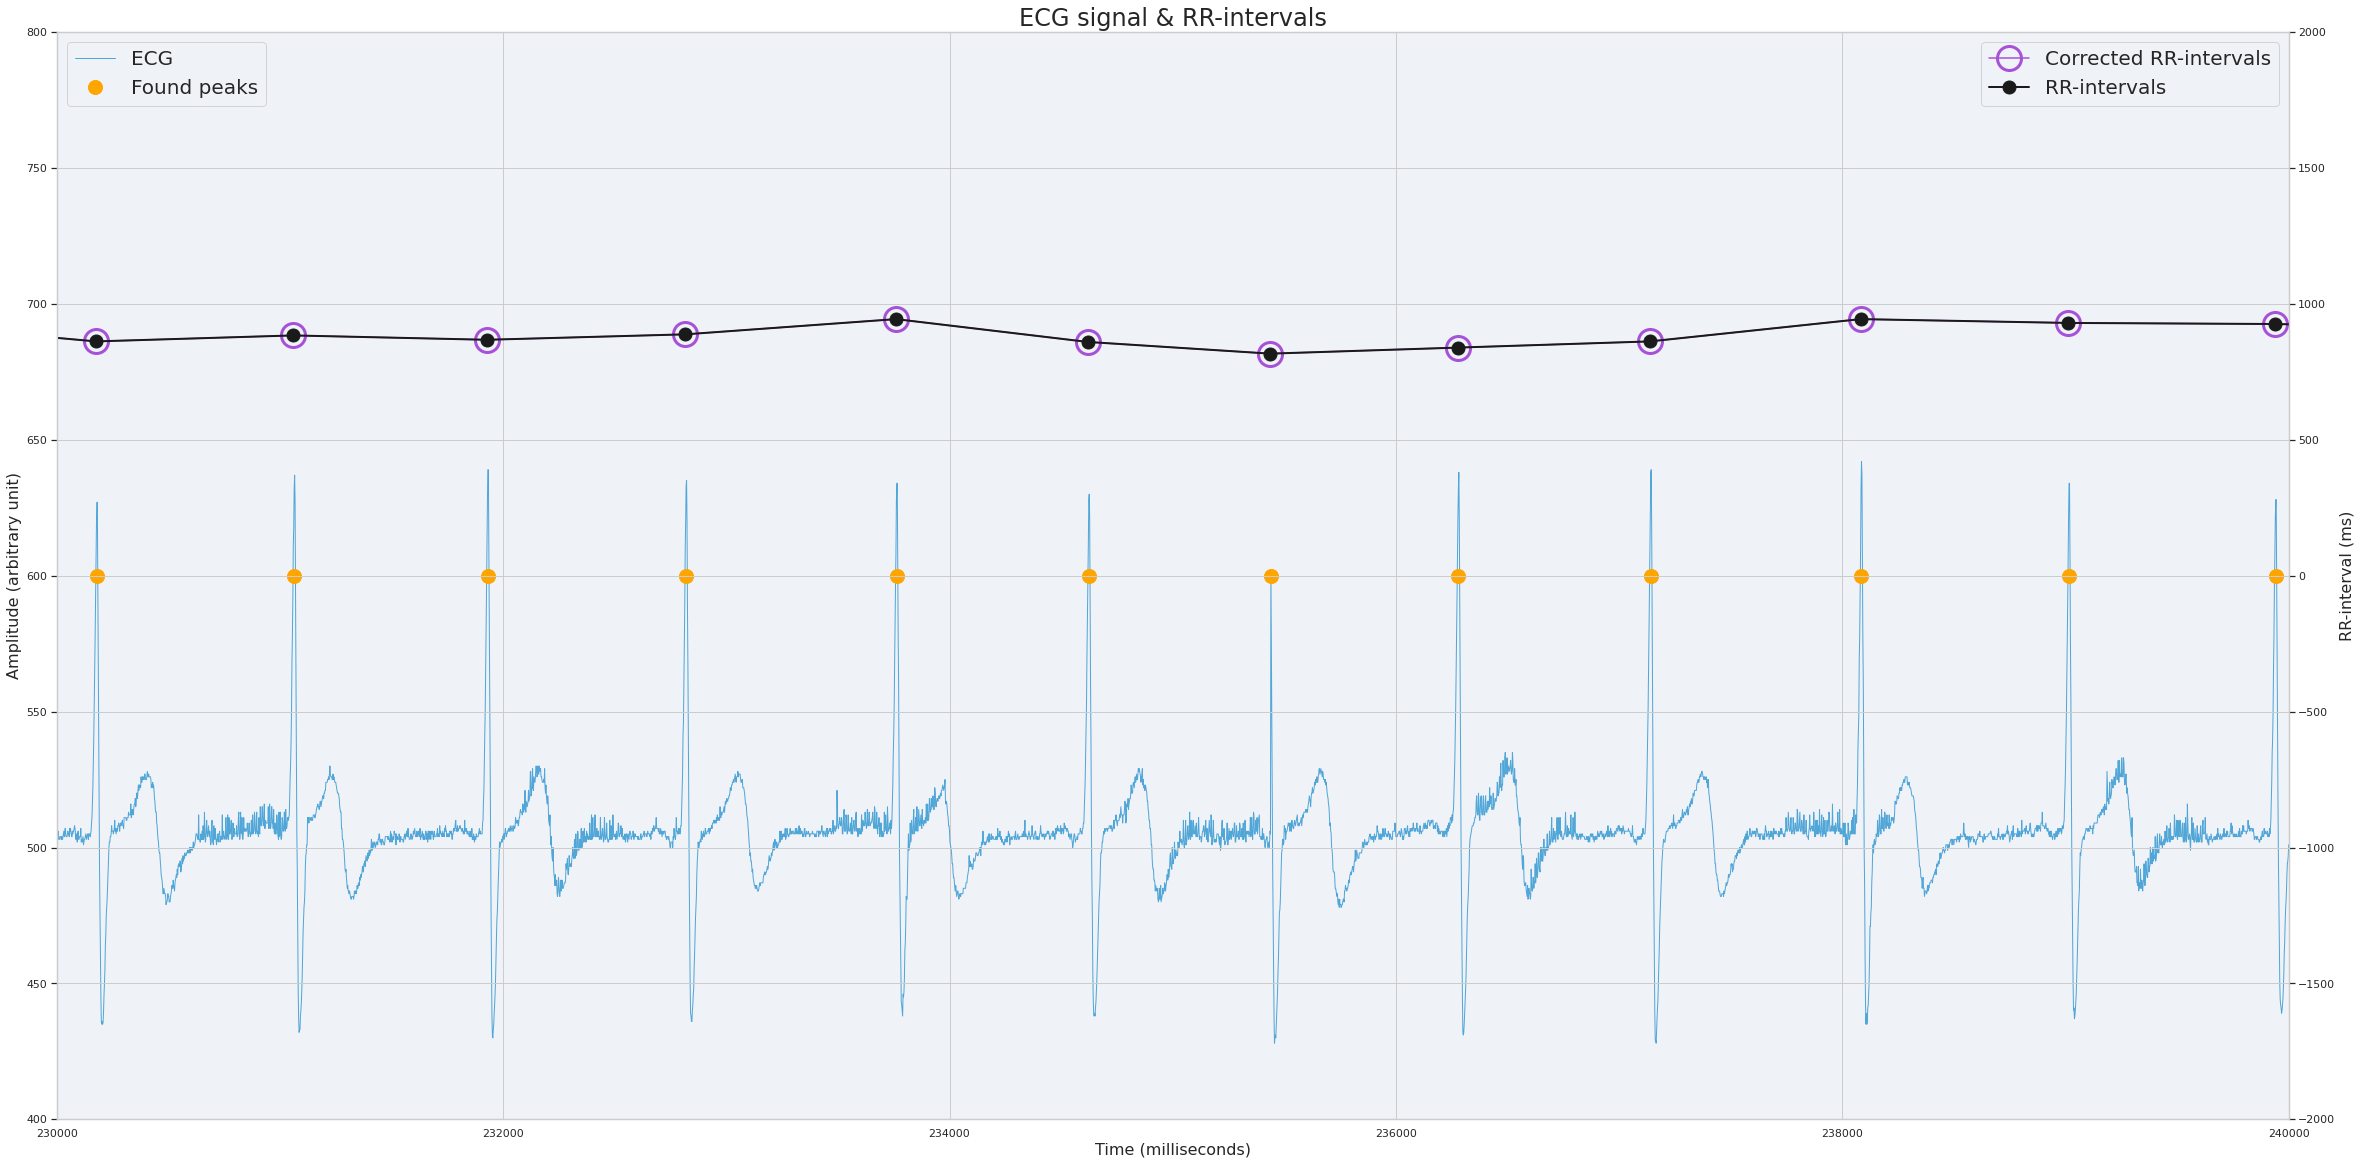

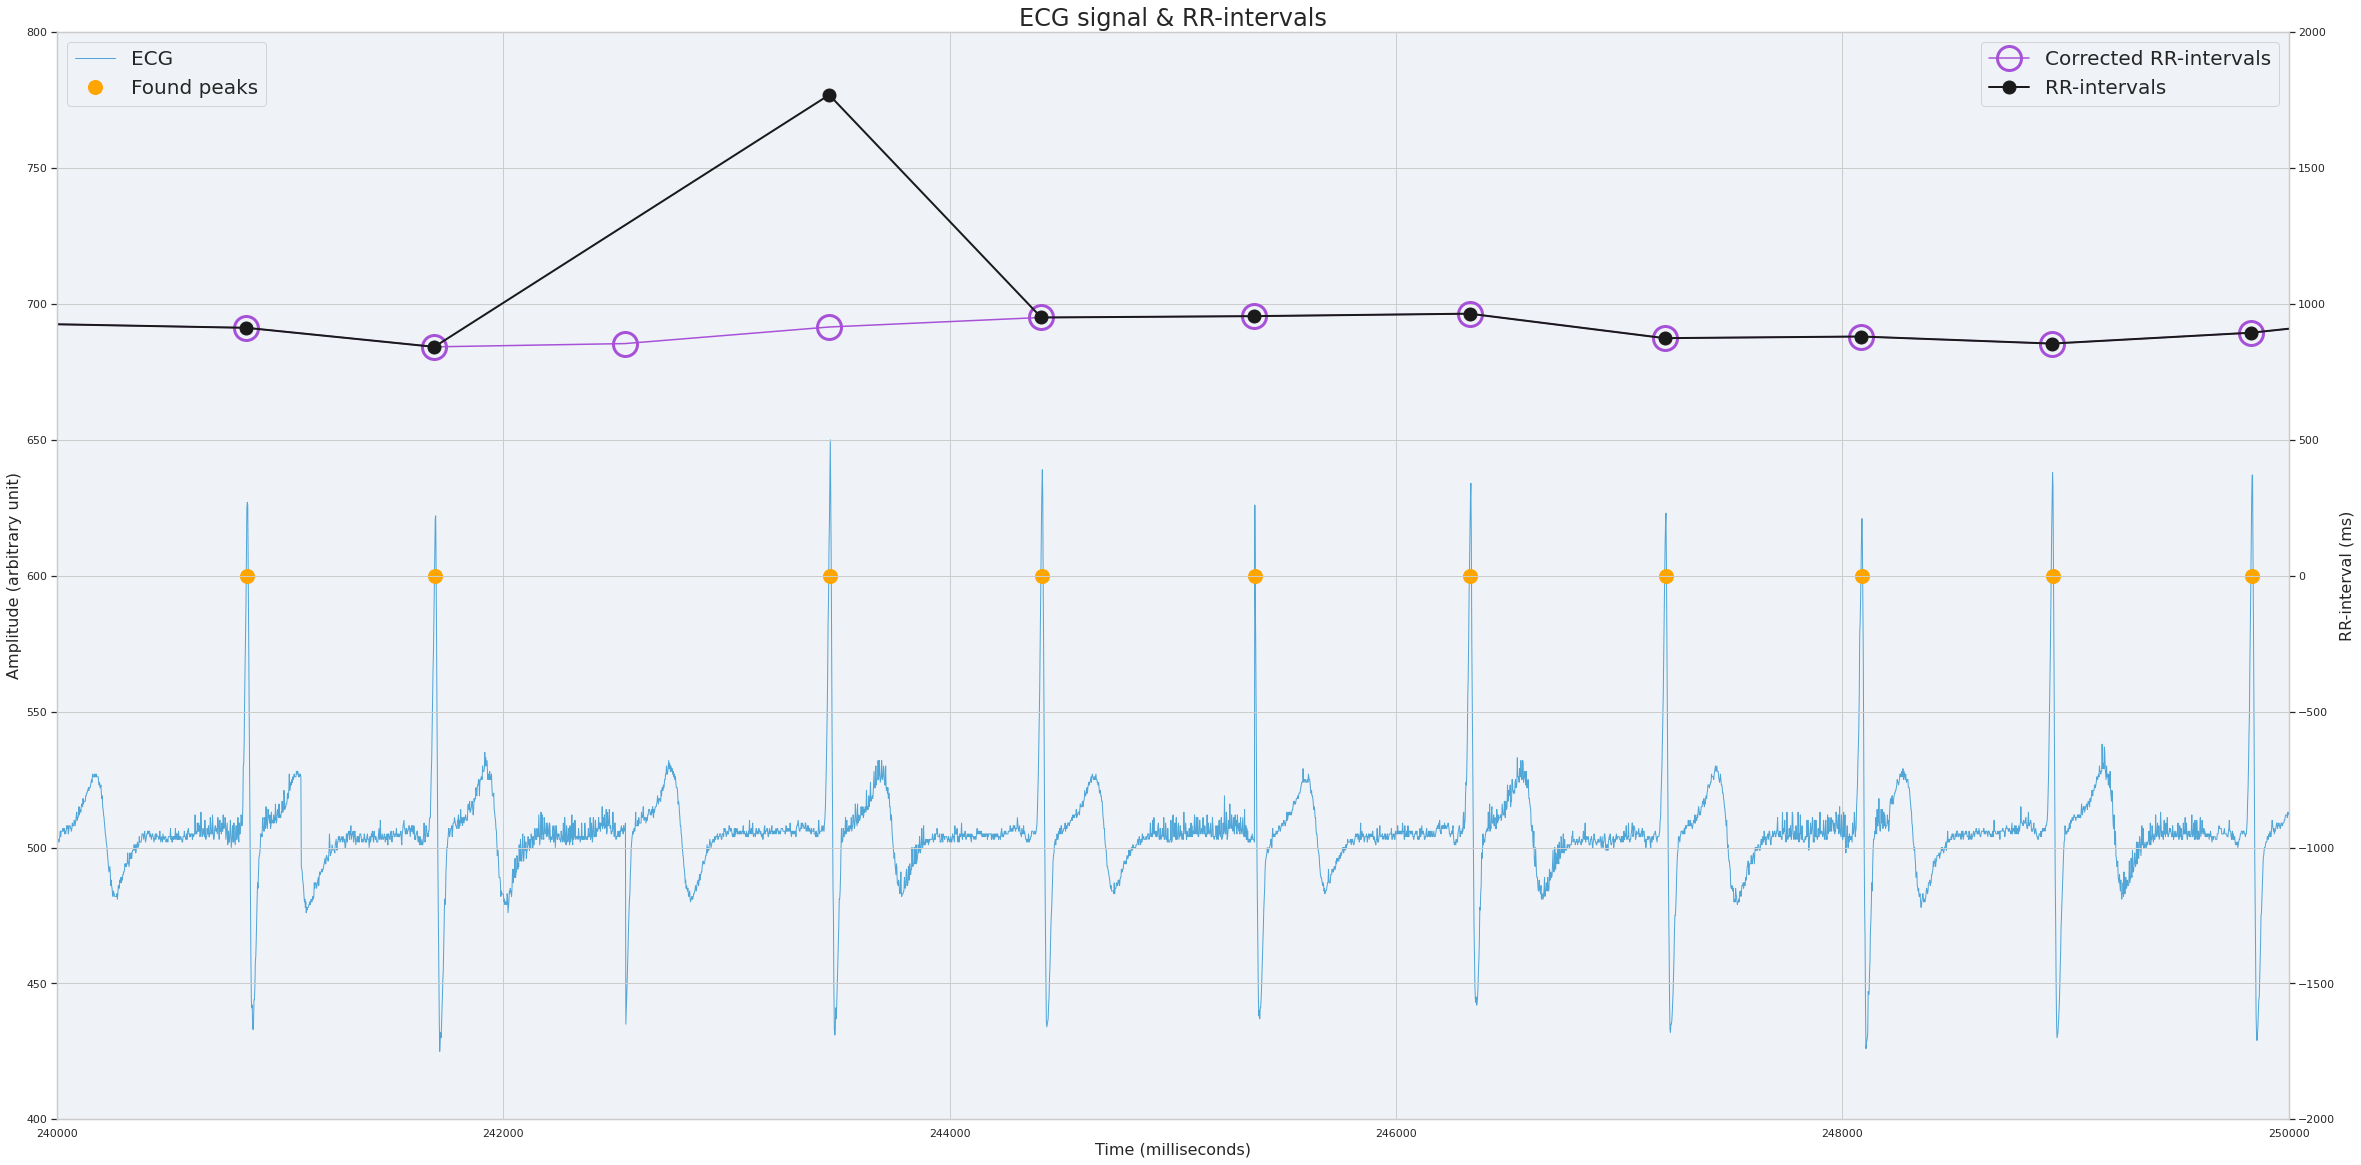

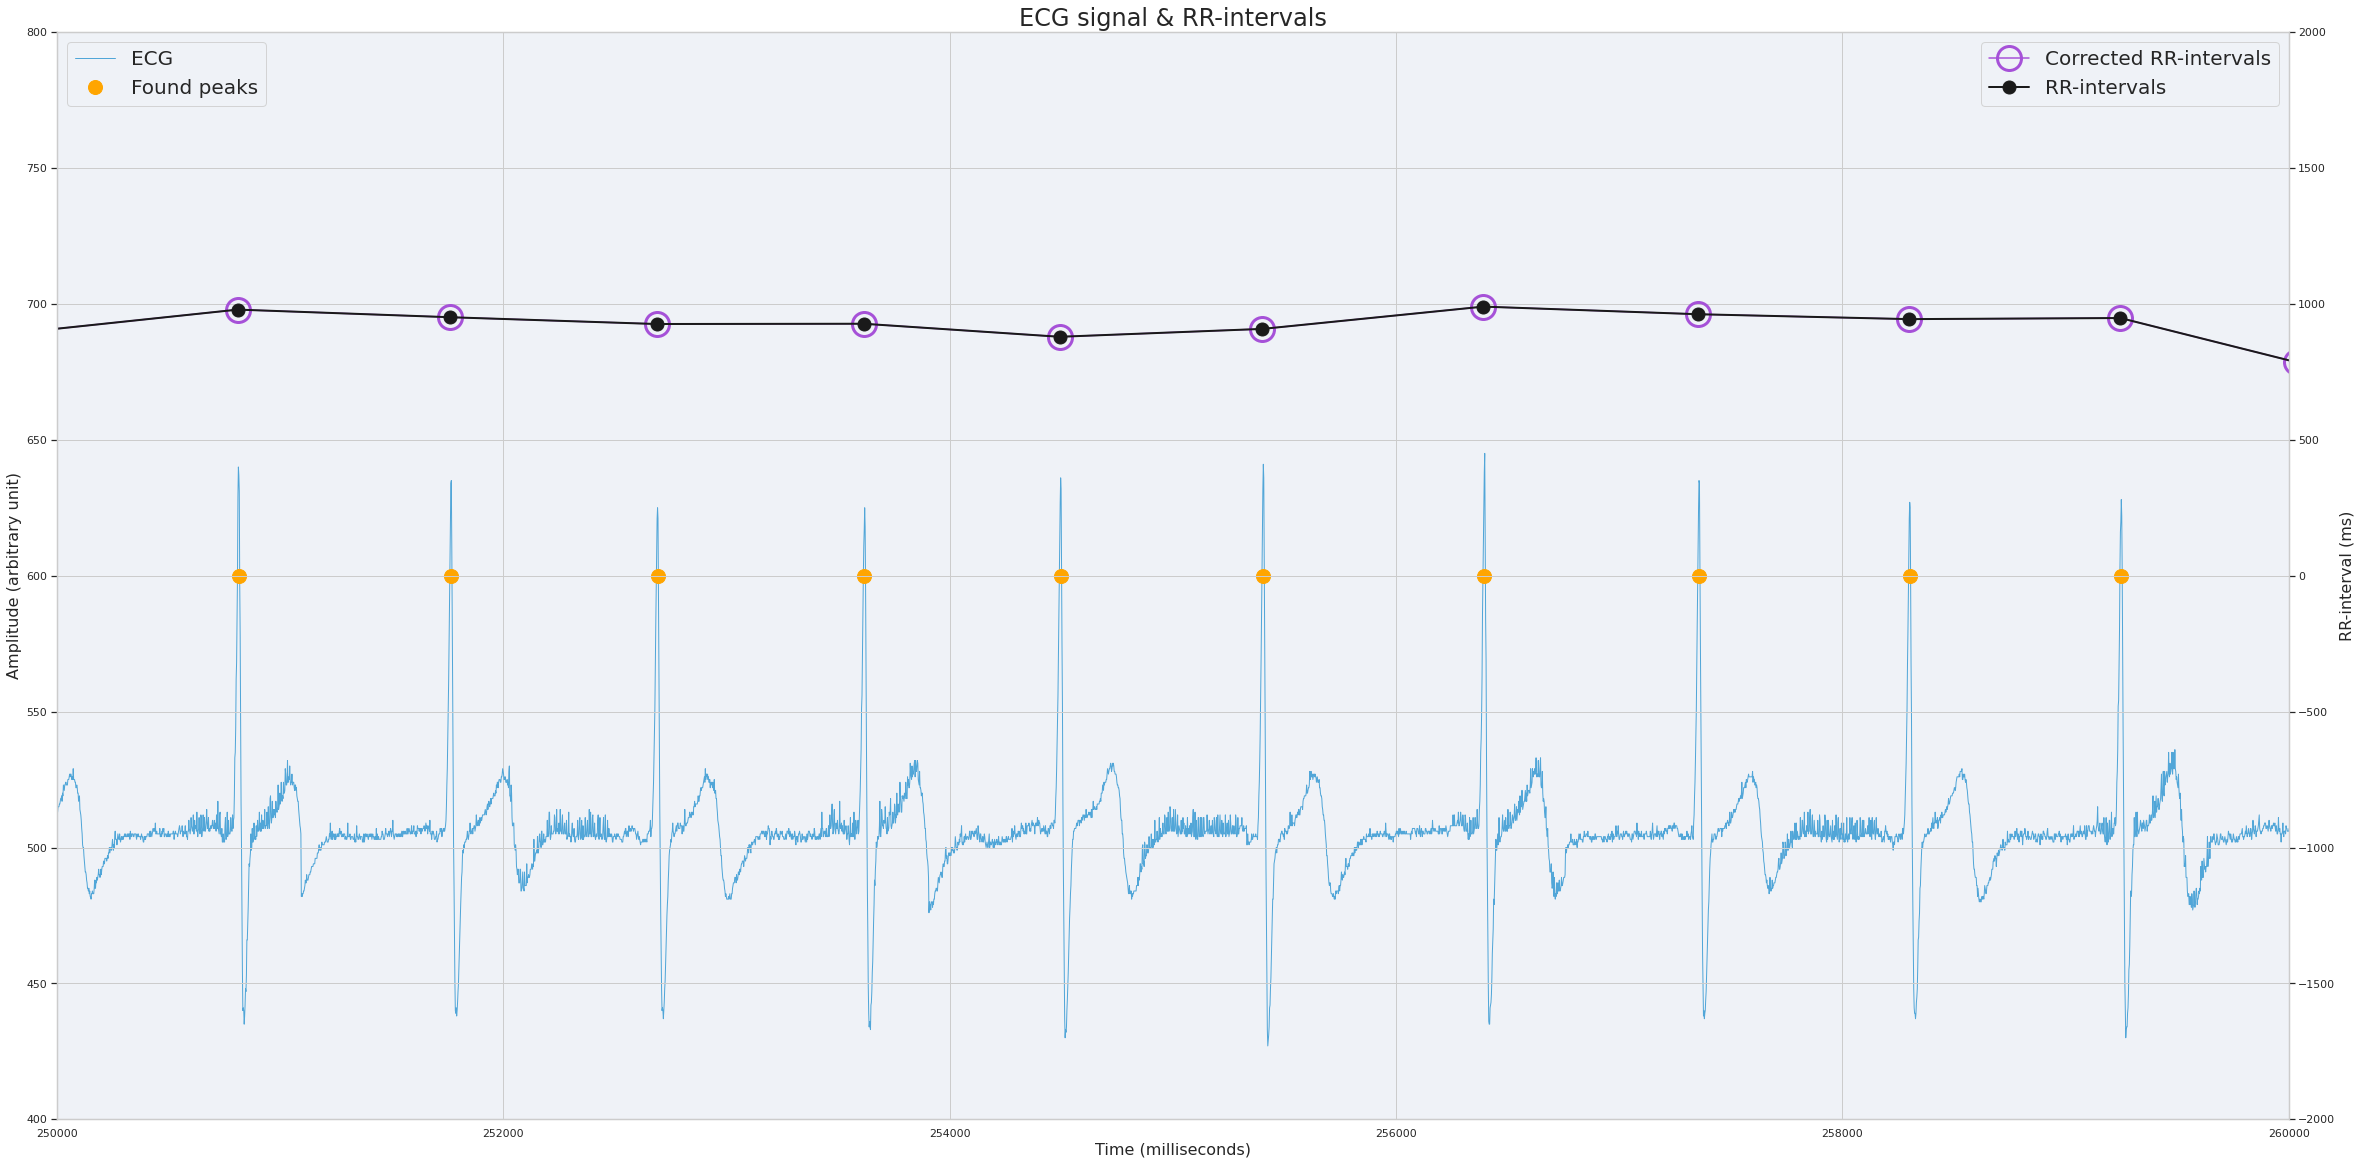

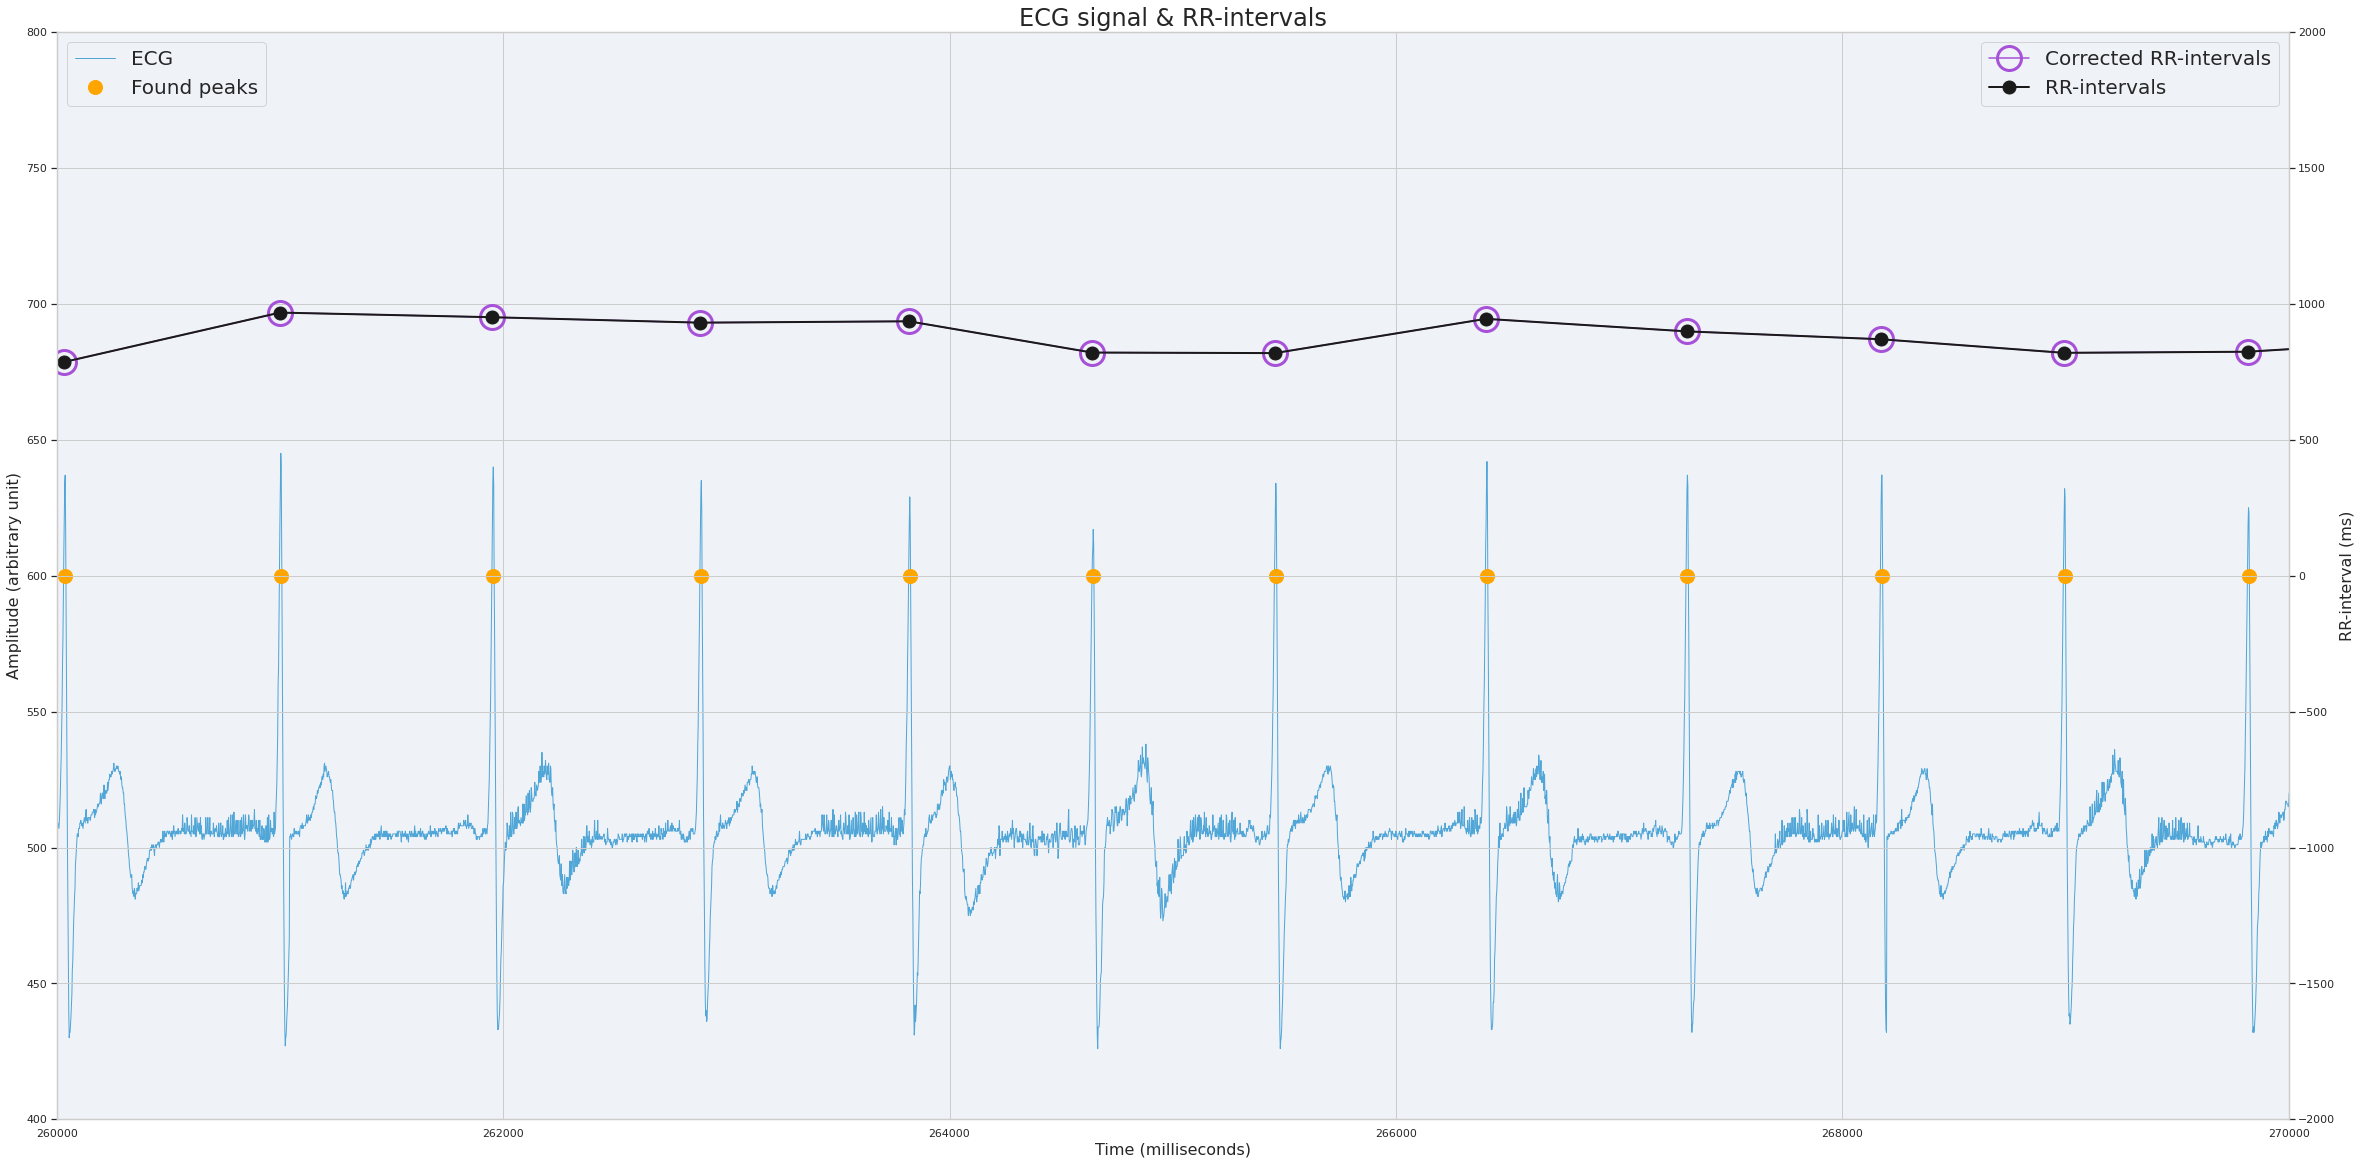

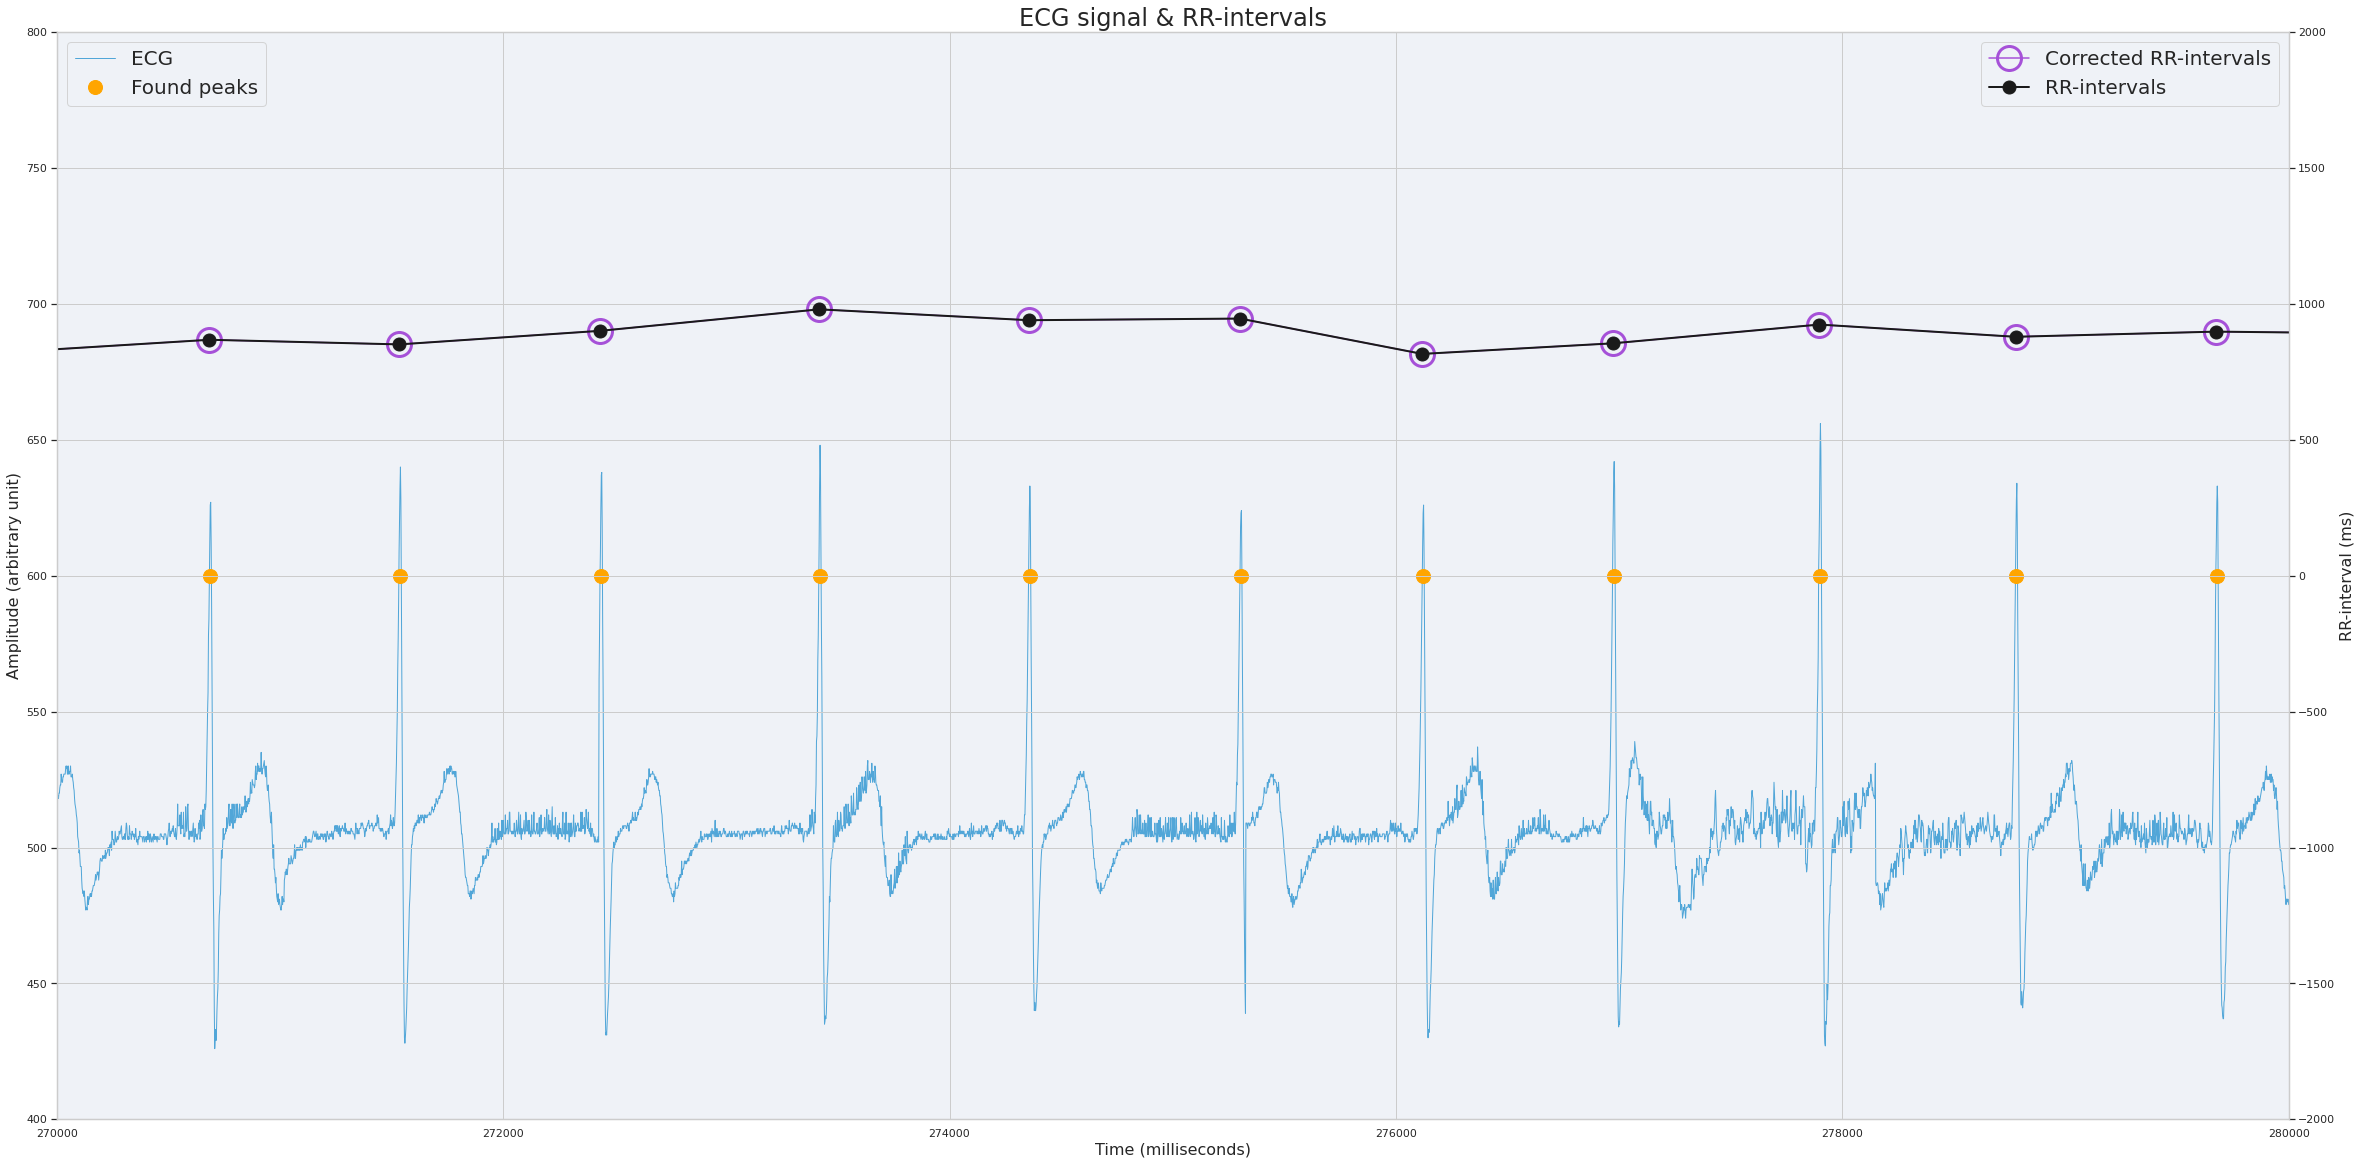

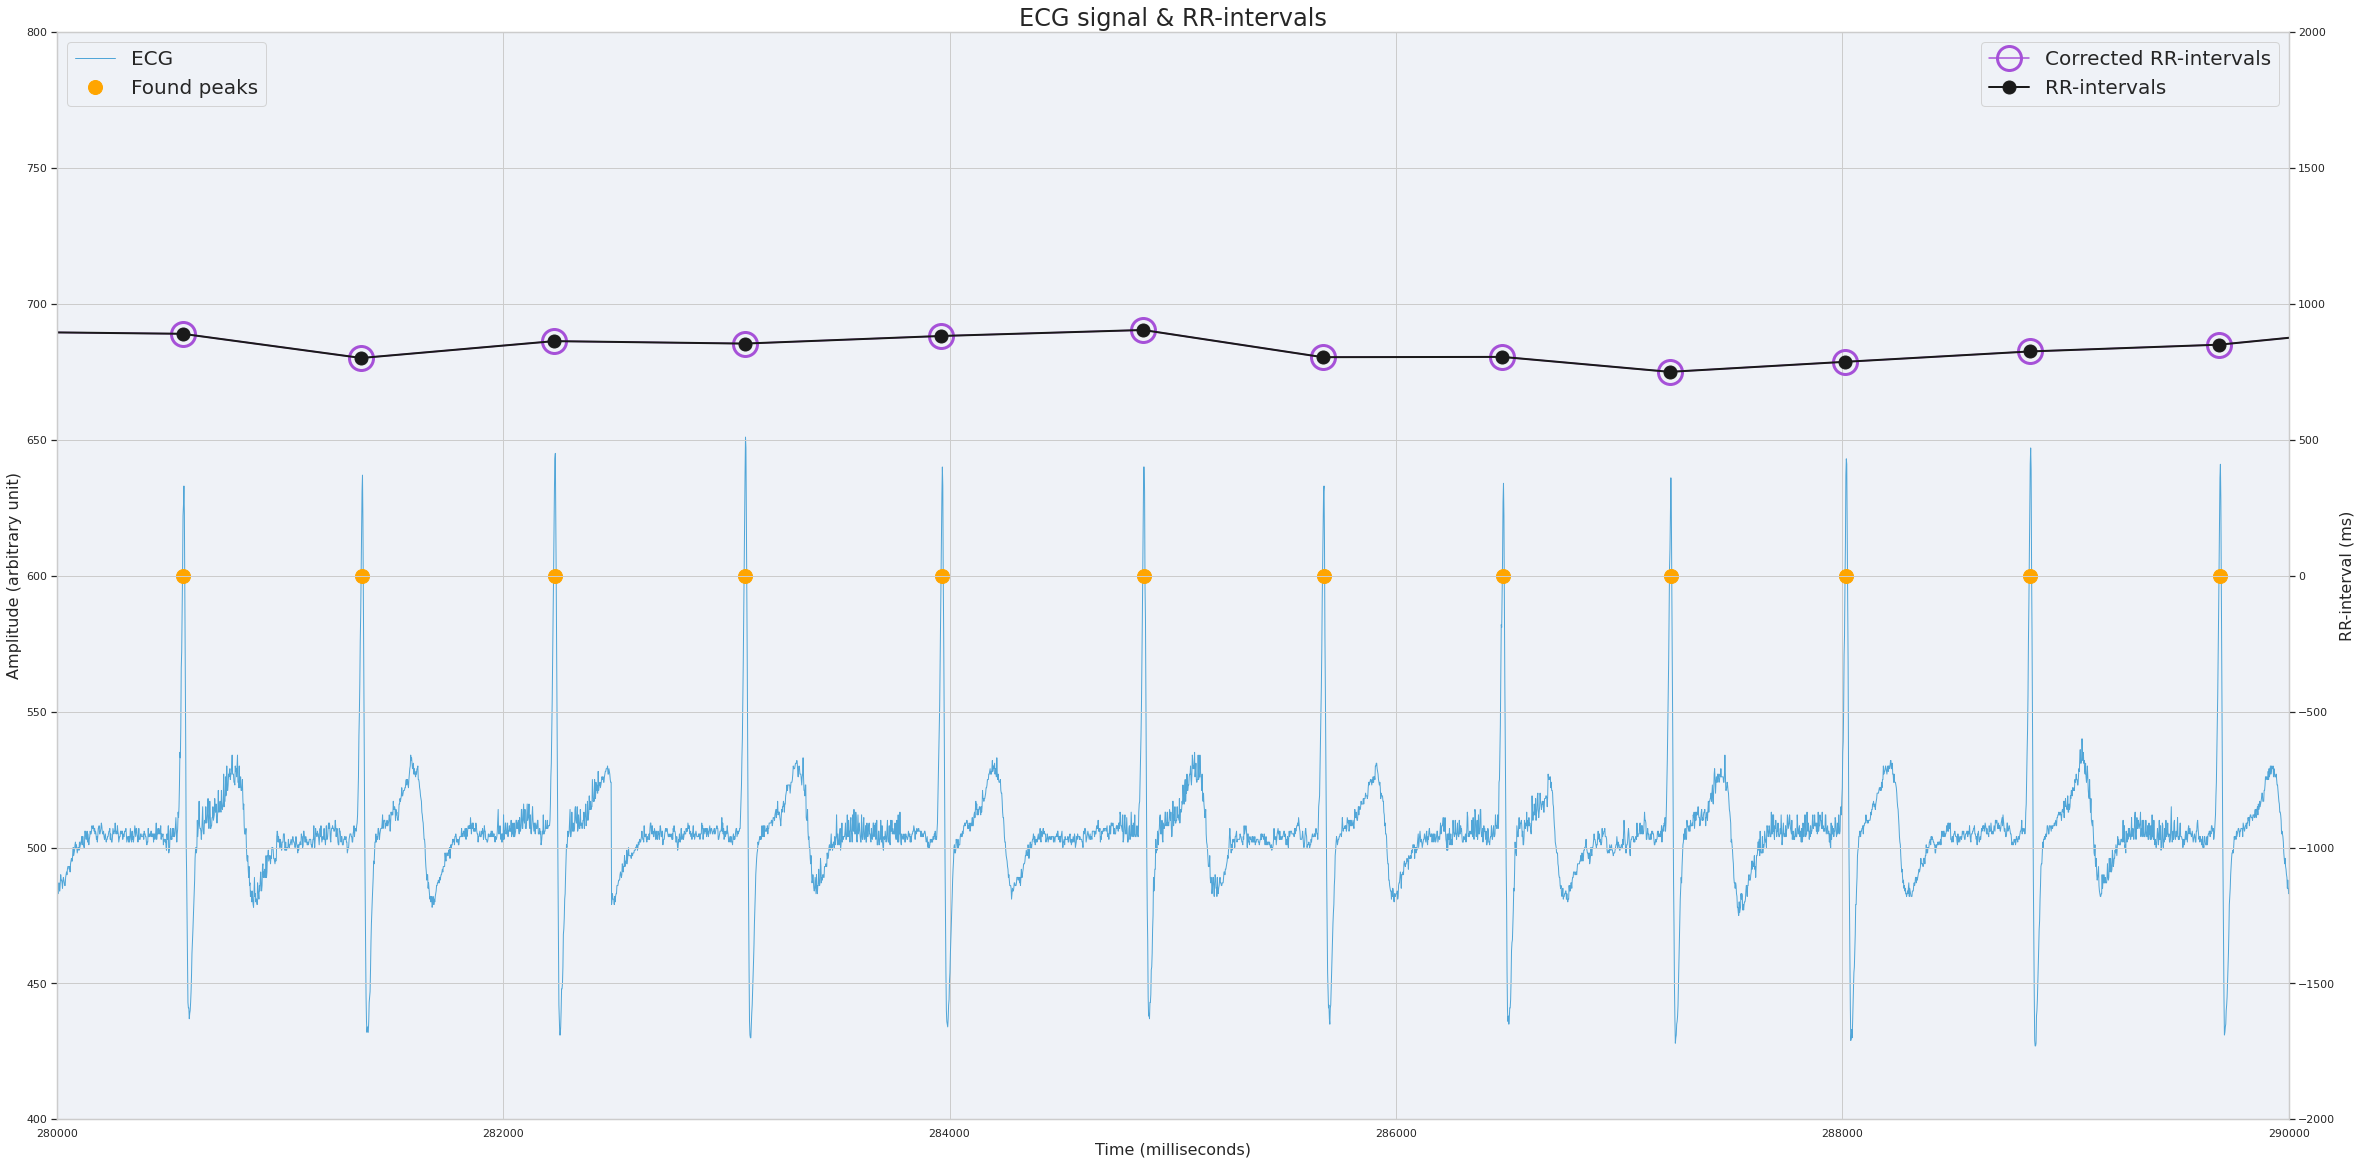

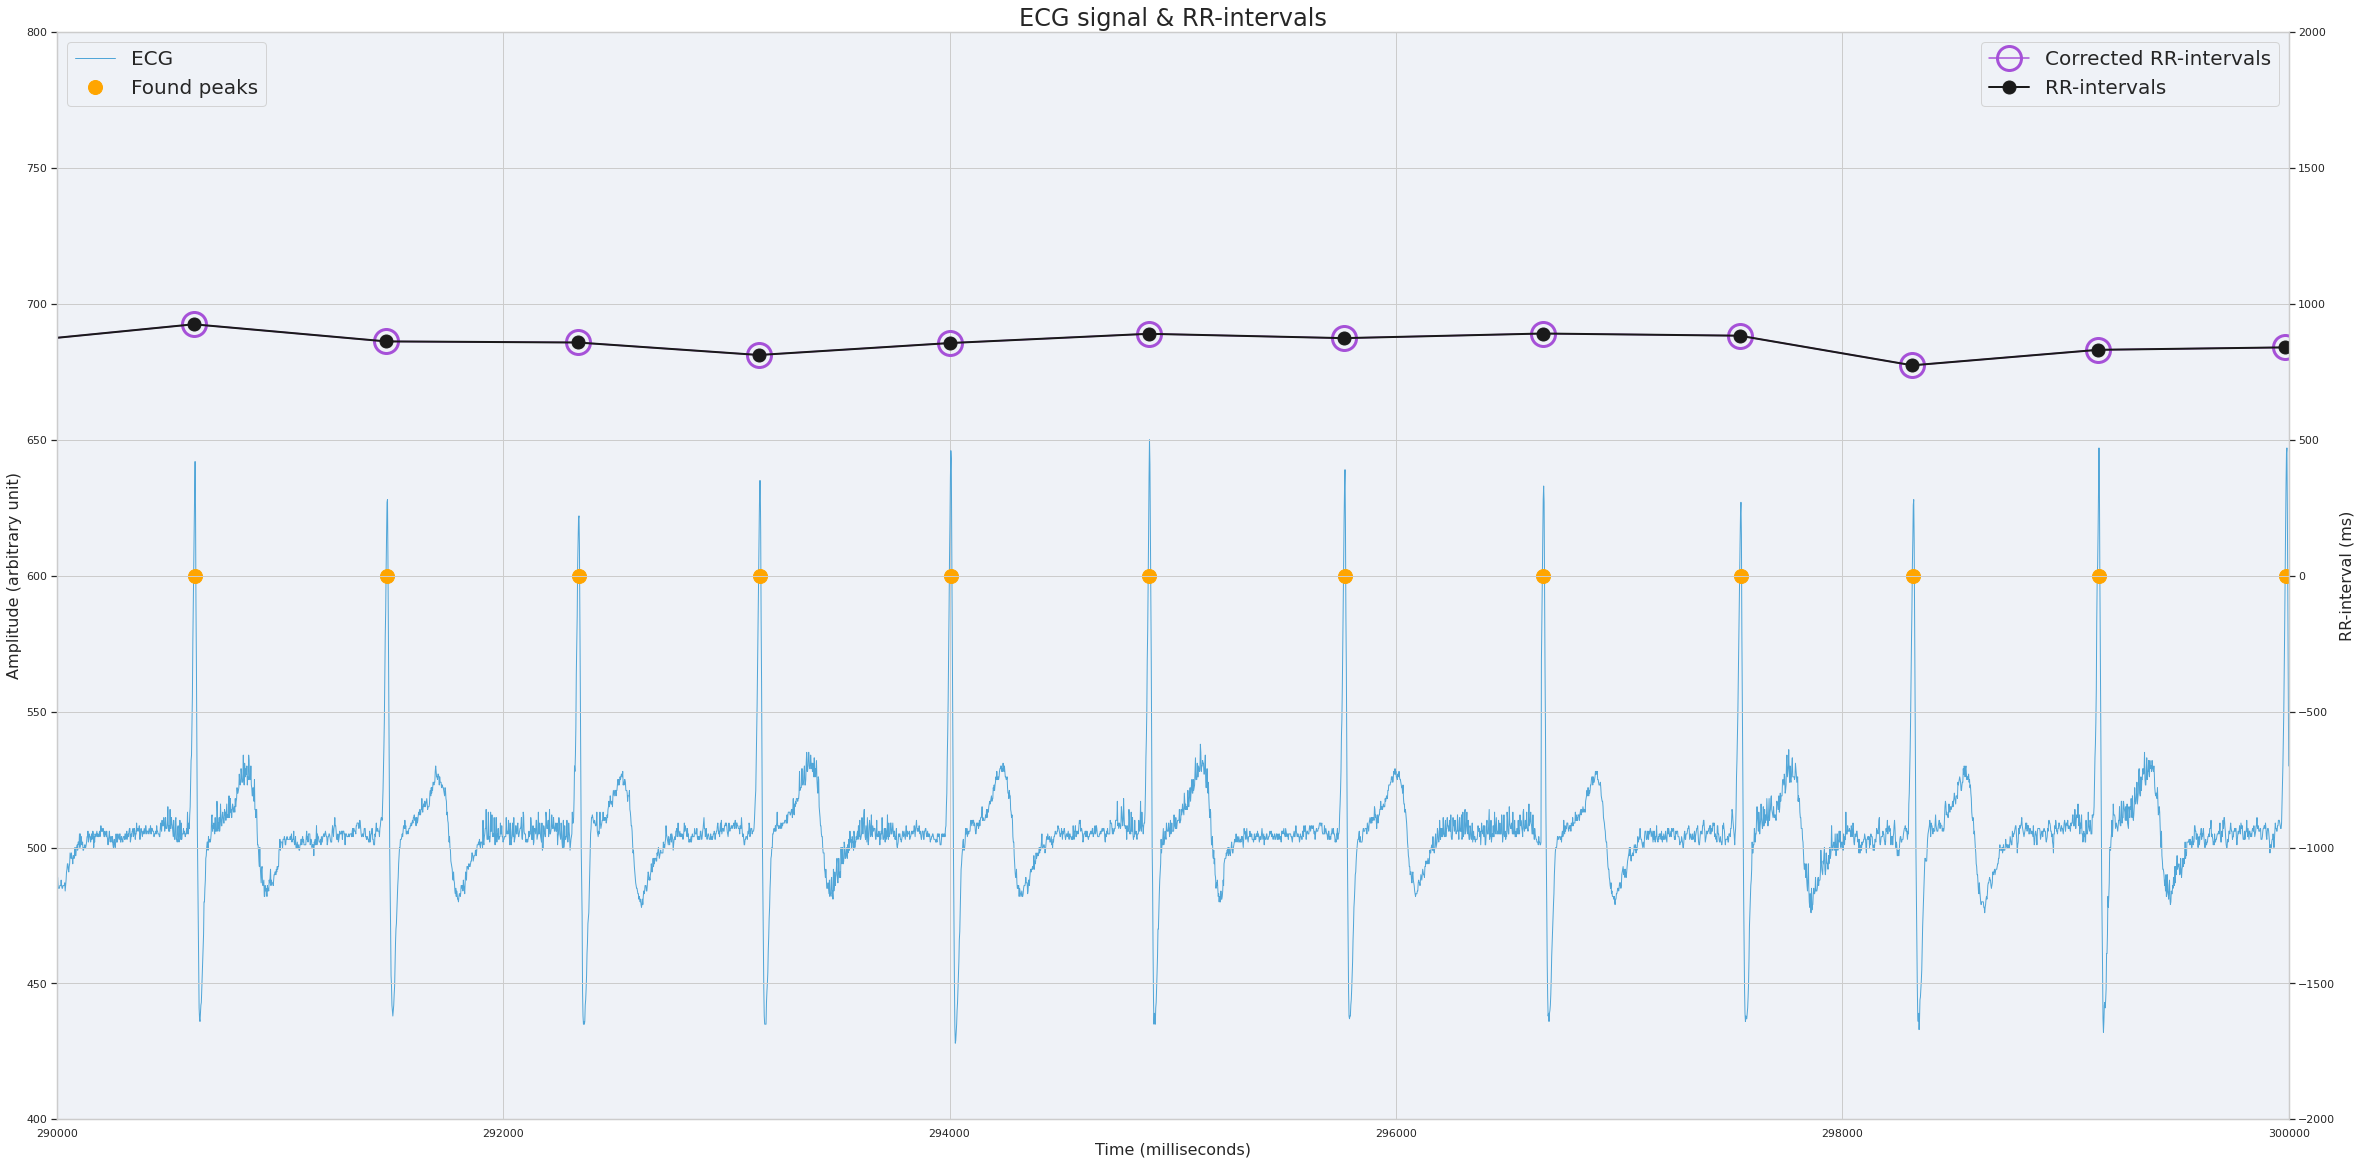

In [ ]:
sampfrom = 200000
sampto = 300000
nr_plots = 10

# detect peaks
peaks, similarity = detect_peaks(df.heartrate, threshold=0.3)

# group peaks so we get a single peak per beat (hopefully)
grouped_peaks = group_peaks(peaks)

# RR-intervals are the differences between successive peaks
rr = np.diff(grouped_peaks)

for start, stop in get_plot_ranges(sampfrom, sampto, nr_plots):
    # plot similarity
    plt.figure(figsize=(40, 20))

    plt.title("ECG signal & RR-intervals", fontsize=24)
    plt.plot(df.index, df.heartrate, label="ECG", color="#51A6D8", linewidth=1)
    plt.plot(grouped_peaks, np.repeat(600, grouped_peaks.shape[0]), markersize=14, label="Found peaks", color="orange", marker="o", linestyle="None")
    plt.legend(loc="upper left", fontsize=20)
    plt.xlabel("Time (milliseconds)", fontsize=16)
    plt.ylabel("Amplitude (arbitrary unit)", fontsize=16)
    plt.gca().set_ylim(400, 800)
    
    ax2 = plt.gca().twinx()
    ax2.plot(np.cumsum(rr_manual)+peaks[0], rr_manual, label="Corrected RR-intervals", fillstyle="none", color="#A651D8", markeredgewidth=3, marker="o", markersize=24)
    ax2.plot(np.cumsum(rr)+peaks[0], rr, label="RR-intervals", color="k", linewidth=2, marker=".", markersize=26)
    
    ax2.set_xlim(start, stop)
    ax2.set_ylim(-2000, 2000)
    ax2.legend(loc="upper right", fontsize=20)
    plt.xlabel("Time (ms)", fontsize=16)
    plt.ylabel("RR-interval (ms)", fontsize=16)

    plt.savefig(os.path.join(output_path, "ecg-with-corrected-rr-%s-%s.png" % (start, stop)))

## Timedomain

In [ ]:
rr = np.loadtxt(os.path.join(data_path, "rr.txt"), dtype=int)
rr_manual = np.loadtxt(os.path.join(data_path, "manual-correction-rr.txt"), dtype=int)

In [ ]:
def timedomain(rr):
    results = {}
    
    hr = 60000/rr
    
    # mean RR-interval
    results['Mean RR (ms)'] = np.mean(rr)
    results['STD RR/SDNN (ms)'] = np.std(rr)
    results['Mean HR (Kubios\' style) (beats/min)'] = 60000/np.mean(rr)
    results['Mean HR (beats/min)'] = np.mean(hr)
    results['STD HR (beats/min)'] = np.std(hr)
    results['Min HR (beats/min)'] = np.min(hr)
    results['Max HR (beats/min)'] = np.max(hr)
    results['RMSSD (ms)'] = np.sqrt(np.mean(np.square(np.diff(rr))))
    results['NNxx'] = np.sum(np.abs(np.diff(rr)) > 50)*1
    results['pNNxx (%)'] = 100 * np.sum((np.abs(np.diff(rr)) > 50)*1) / len(rr)
    return results

print("Time domain metrics - automatically corrected RR-intervals:")
for k, v in timedomain(rr).items():
    print("- %s: %.2f" % (k, v))

print()
print("Time domain metrics - manually corrected RR-intervals:")
for k, v in timedomain(rr_manual).items():
    print("- %s: %.2f" % (k, v))

Time domain metrics - automatically corrected RR-intervals:
- Mean RR (ms): 866.54
- STD RR/SDNN (ms): 62.25
- Mean HR (Kubios' style) (beats/min): 69.24
- Mean HR (beats/min): 69.61
- STD HR (beats/min): 5.22
- Min HR (beats/min): 58.37
- Max HR (beats/min): 88.76
- RMSSD (ms): 60.51
- NNxx: 123.00
- pNNxx (%): 35.45

Time domain metrics - manually corrected RR-intervals:
- Mean RR (ms): 866.81
- STD RR/SDNN (ms): 62.58
- Mean HR (Kubios' style) (beats/min): 69.22
- Mean HR (beats/min): 69.60
- STD HR (beats/min): 5.24
- Min HR (beats/min): 58.37
- Max HR (beats/min): 88.76
- RMSSD (ms): 60.37
- NNxx: 122.00
- pNNxx (%): 35.26


## Frequency domain

### Interpolate

In [ ]:
# sample rate for interpolation
fs = 4.0
steps = 1 / fs

# create interpolation function based on the rr-samples. 
x = np.cumsum(rr_manual) / 1000.0
f = interp1d(x, rr_manual, kind='cubic')

# now we can sample from interpolation function
xx = np.arange(1, np.max(x), steps)
rr_interpolated = f(xx)

In [ ]:
plt.figure(figsize=(30, 20))

plt.subplot(211)
plt.title("RR intervals", fontsize=24)
plt.plot(x, rr_manual, label="RR-Intervals", color="k", markerfacecolor="#A651D8", markeredgewidth=0, marker="o", markersize=12)
plt.xlabel("Time (s)")
plt.ylabel("RR-interval (ms)")
plt.title("Interpolated", fontsize=24)
plt.gca().set_xlim(0, 20)

plt.subplot(212)
plt.title("RR intervals, interpolated", fontsize=24)
plt.plot(xx, rr_interpolated, label="RR-Intervals (interpolated)", color="k", markerfacecolor="#51A6D8", markeredgewidth=0, marker="o", markersize=10)
plt.gca().set_xlim(0, 20)
plt.xlabel("Time (s)", fontsize=16)
plt.ylabel("RR-interval (ms)", fontsize=16)

In [ ]:
def frequency_domain(rri, fs=4):
    # Estimate the spectral density using Welch's method
    fxx, pxx = signal.welch(x=rr_interpolated, fs=fs)
    
    '''
    Segement found frequencies in the bands 
     - Very Low Frequency (VLF): 0-0.04Hz 
     - Low Frequency (LF): 0.04-0.15Hz 
     - High Frequency (HF): 0.15-0.4Hz
    '''
    cond_vlf = (fxx >= 0) & (fxx < 0.04)
    cond_lf = (fxx >= 0.04) & (fxx < 0.15)
    cond_hf = (fxx >= 0.15) & (fxx < 0.4)
    
    # calculate power in each band by integrating the spectral density 
    vlf = trapz(pxx[cond_vlf], fxx[cond_vlf])
    lf = trapz(pxx[cond_lf], fxx[cond_lf])
    hf = trapz(pxx[cond_hf], fxx[cond_hf])
    
    # sum these up to get total power
    total_power = vlf + lf + hf

    # find which frequency has the most power in each band
    peak_vlf = fxx[cond_vlf][np.argmax(pxx[cond_vlf])]
    peak_lf = fxx[cond_lf][np.argmax(pxx[cond_lf])]
    peak_hf = fxx[cond_hf][np.argmax(pxx[cond_hf])]

    # fraction of lf and hf
    lf_nu = 100 * lf / (lf + hf)
    hf_nu = 100 * hf / (lf + hf)
    
    results = {}
    results['Power VLF (ms2)'] = vlf
    results['Power LF (ms2)'] = lf
    results['Power HF (ms2)'] = hf   
    results['Power Total (ms2)'] = total_power

    results['LF/HF'] = (lf/hf)
    results['Peak VLF (Hz)'] = peak_vlf
    results['Peak LF (Hz)'] = peak_lf
    results['Peak HF (Hz)'] = peak_hf

    results['Fraction LF (nu)'] = lf_nu
    results['Fraction HF (nu)'] = hf_nu
    return results, fxx, pxx

print("Frequency domain metrics:")
results, fxx, pxx = frequency_domain(rr_interpolated)

for k, v in results.items():
    print("- %s: %.2f" % (k, v))

Frequency domain metrics:
- Power VLF (ms2): 541.45
- Power LF (ms2): 581.36
- Power HF (ms2): 1873.23
- Power Total (ms2): 2996.04
- LF/HF: 0.31
- Peak VLF (Hz): 0.02
- Peak LF (Hz): 0.14
- Peak HF (Hz): 0.17
- Fraction LF (nu): 23.68
- Fraction HF (nu): 76.32


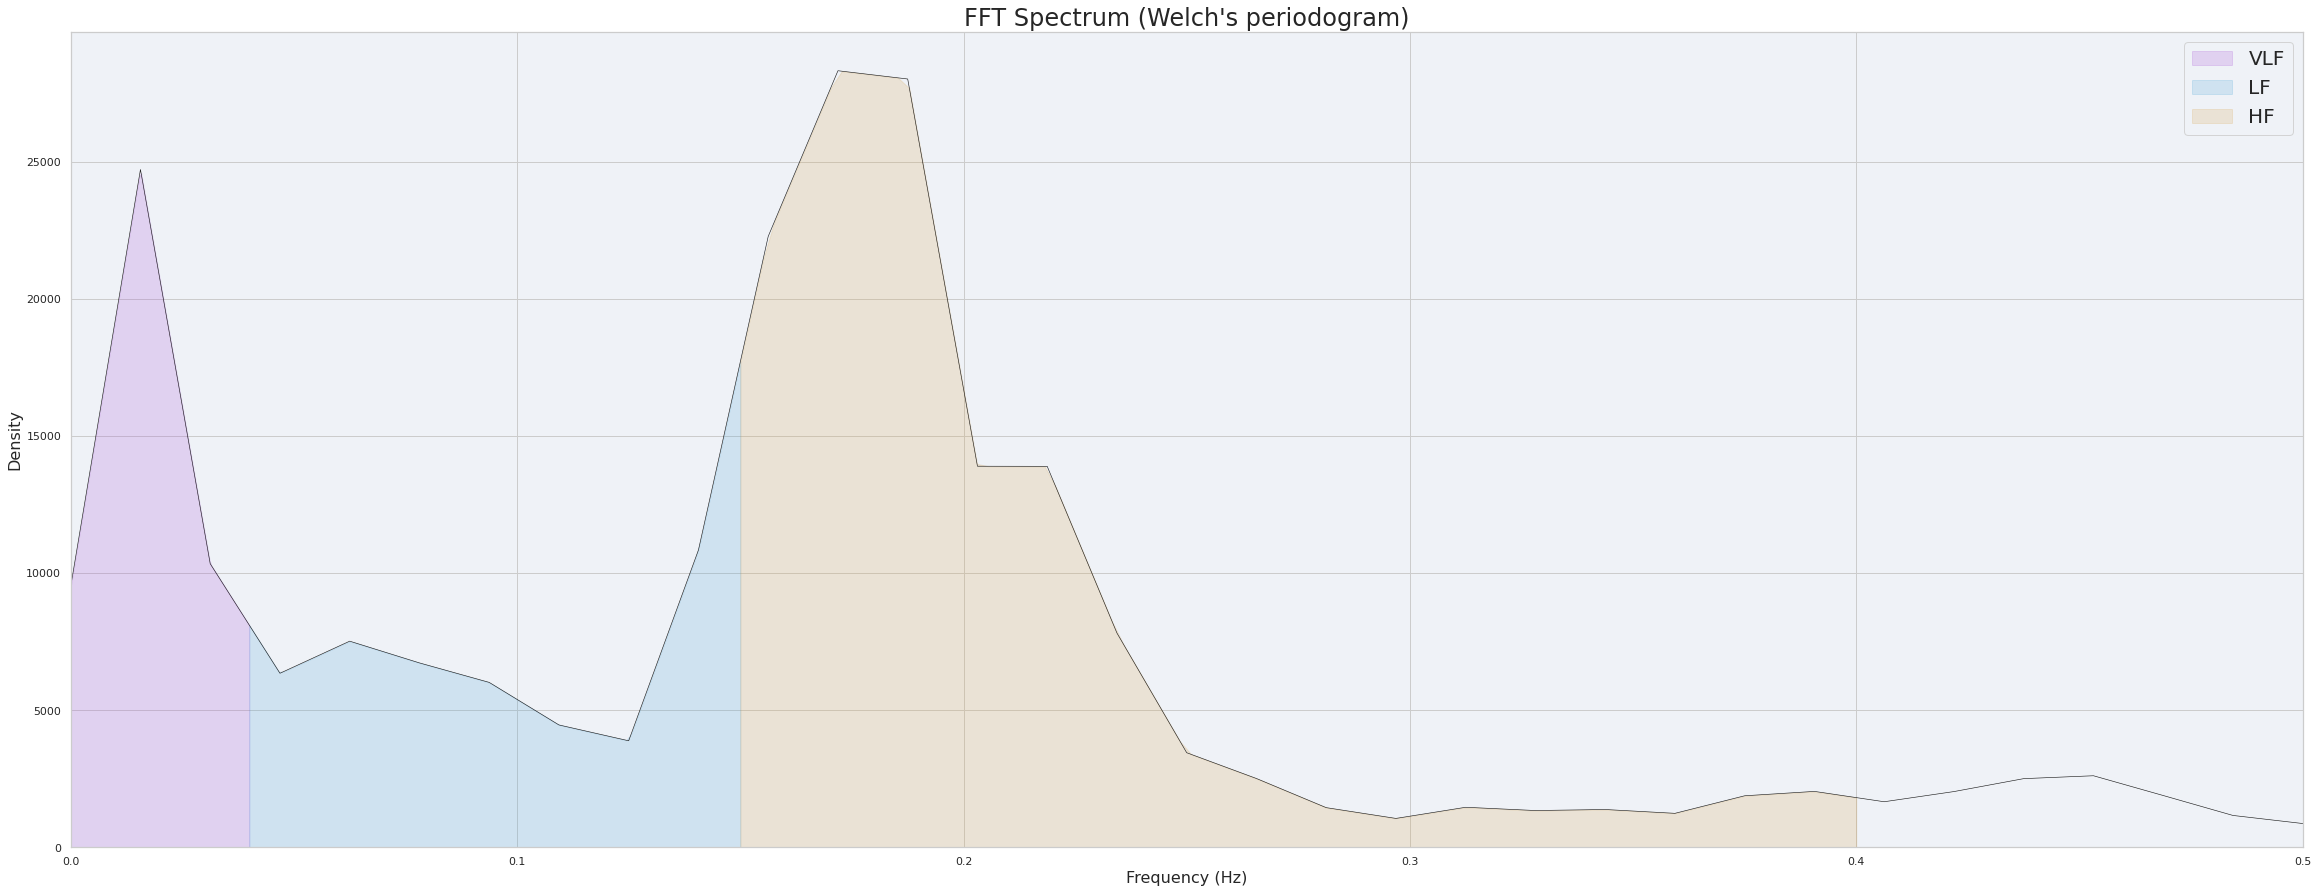

In [ ]:
plt.figure(figsize=(40, 15))
plt.plot(fxx, pxx, color="k", linewidth=0.6)
plt.title("FFT Spectrum (Welch's periodogram)", fontsize=24)

# create interpolation function for plotting frequency bands
psd_f = interp1d(fxx, pxx)

# setup frequency bands for plotting
x_vlf = np.linspace(0, 0.04, 100)
x_lf = np.linspace(0.04, 0.15, 100)
x_hf = np.linspace(0.15, 0.4, 100)

plt.gca().fill_between(x_vlf, psd_f(x_vlf), alpha=0.2, color="#A651D8", label="VLF")
plt.gca().fill_between(x_lf, psd_f(x_lf), alpha=0.2, color="#51A6D8", label="LF")
plt.gca().fill_between(x_hf, psd_f(x_hf), alpha=0.2, color="#D8A651", label="HF")

plt.gca().set_xlim(0, 0.5)
plt.gca().set_ylim(0)
plt.xlabel("Frequency (Hz)", fontsize=16)
plt.ylabel("Density", fontsize=16)
plt.legend(fontsize=20)

### Poincare

SD1: 104.158 ms
SD2: 124.209 ms


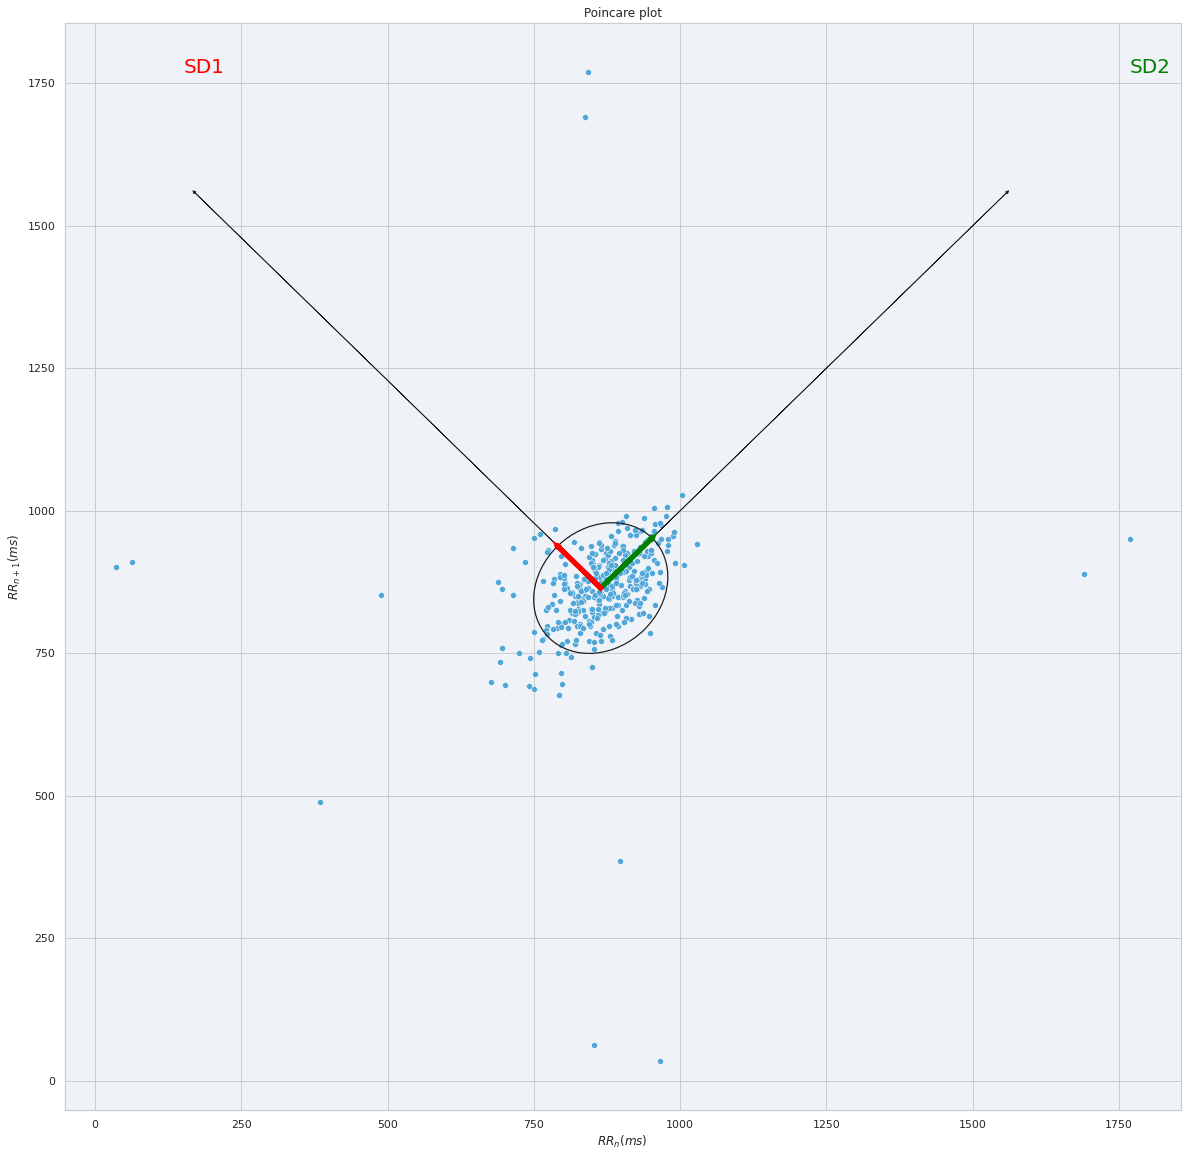

In [ ]:
def plot_poincare(rr):
    rr_n = rr[:-1]
    rr_n1 = rr[1:]

    sd1 = np.sqrt(0.5) * np.std(rr_n1 - rr_n)
    sd2 = np.sqrt(0.5) * np.std(rr_n1 + rr_n)

    m = np.mean(rr)
    min_rr = np.min(rr)
    max_rr = np.max(rr)
    
    plt.figure(figsize=(20, 20))
    plt.title("Poincare plot")

    sns.scatterplot(x=rr_n, y=rr_n1, color="#51A6D8")

    plt.xlabel(r'$RR_n (ms)$')
    plt.ylabel(r'$RR_{n+1} (ms)$')

    e1 = Ellipse((m, m), 2*sd1, 2*sd2, angle=-45, linewidth=1.2, fill=False, color="k")
    plt.gca().add_patch(e1)

    plt.arrow(m, m, (max_rr-min_rr)*0.4, (max_rr-min_rr)*0.4, color="k", linewidth=0.8, head_width=5, head_length=5)
    plt.arrow(m, m, (min_rr-max_rr)*0.4, (max_rr-min_rr)*0.4, color="k", linewidth=0.8, head_width=5, head_length=5)

    plt.arrow(m, m, sd2 * np.sqrt(0.5), sd2 * np.sqrt(0.5), color="green", linewidth=5)
    plt.arrow(m, m, -sd1 * np.sqrt(0.5), sd1 * np.sqrt(0.5), color="red", linewidth=5)

    plt.text(max_rr, max_rr, "SD2", fontsize=20, color="green")
    plt.text(m-(max_rr-min_rr)*0.4-20, max_rr, "SD1", fontsize=20, color="red")
    
    return sd1, sd2

sd1, sd2 = plot_poincare(rr)
print("SD1: %.3f ms" % sd1)
print("SD2: %.3f ms" % sd2)